# Still to Fix:

* function: timeseries_model

# Imports for project

In [1]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2


In [2]:
# DO NOT REMOVE This
%reload_ext autoreload

In [3]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py

#import src.base with alias to avoid namespace clashes

from src import clean_data as cln
from src import visualize as viz
from src import model as md
from src.clean_data import *
from src.model import *


# Library Imports

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from datetime import datetime
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore")

# Data Importing

In [5]:
zillow_df = pd.read_csv('../data/raw/zillow_data.csv')

In [6]:
zillow_df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [7]:
len(zillow_df['City'].unique())

7554

* There are 7554 unique cities in our dataset.
* Let's focus on one city in particular; **Chicago**

# Data Cleaning

## Initial Cleaning
* Only Chicago Data
* Dates as the Index
* Zipcodes as the columns

### Filter Dataframe for Chicago's Data

In [8]:
chicago_df = zillow_df[zillow_df['City']=='Chicago']
chicago_df.head(3)

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0     84654       60657  Chicago    IL  Chicago       Cook         1   
3     84616       60614  Chicago    IL  Chicago       Cook         4   
7     84640       60640  Chicago    IL  Chicago       Cook         8   

    1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
3  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
7  216500.0  216700.0  216900.0  ...   798000   787100   776100   774900   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
3  1296600  1299000  1302700  1306400  1308500  1307000  
7   777900   777900   778500   780500   782800   782800  

[3 rows x 272 columns]

In [9]:
chicago_dates = chicago_df[chicago_df.columns[7:]]  # Take the dates from the 8th column onwards, drop previous columns
chicago_dates.head(3)

1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
0  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0   
3  498100.0  500900.0  503100.0  504600.0  505500.0  505700.0  505300.0   
7  216500.0  216700.0  216900.0  217000.0  217100.0  217200.0  217500.0   

    1996-11   1996-12   1997-01  ...  2017-07  2017-08  2017-09  2017-10  \
0  341300.0  342600.0  344400.0  ...  1005500  1007500  1007800  1009600   
3  504200.0  503600.0  503400.0  ...  1289800  1287700  1287400  1291500   
7  217900.0  218600.0  219700.0  ...   798000   787100   776100   774900   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
3  1296600  1299000  1302700  1306400  1308500  1307000  
7   777900   777900   778500   780500   782800   782800  

[3 rows x 265 columns]

### Change dates to datetime format

In [10]:
chicago_df = chicago_dates.T  # Transpose dataframe to put the column headings as row headings and give each date its own row.
chicago_df.reset_index(inplace=True)  # Bring the dates out of the index, so we can change their type
chicago_df['index'] = pd.to_datetime(chicago_df['index'])  # change dates to datetime

### Set the Index to be the dates

In [11]:
chicago_df.set_index('index', inplace=True)

In [12]:
chicago_df.head(3)

0         3         7         16        19        40    \
index                                                                    
1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   

               48        50       74        79    ...      2360      2420  \
index                                             ...                       
1996-04-01  93400.0  148900.0  76400.0  435200.0  ...  100900.0  215600.0   
1996-05-01  94100.0  149300.0  77000.0  435200.0  ...  101400.0  215100.0   
1996-06-01  94600.0  149600.0  77400.0  435100.0  ...  101900.0  214500.0   

                2585      2830      3149      3156      3960      4040  \
index                                                                    
1996-04-01  165400.0  103700.0  180900.0  166300.0  125700.0  197300.0   
1996-05-01  165300.0  104400.0  182200.0  166900.0  126300.0  198900.0   
1996-06-01  165000.0  104700.0  183100.0  167200.0  126600.0  200100.0   

                4362     7863  
index                          
1996-04-01  224100.0  77900.0  
1996-05-01  223300.0  78200.0  
1996-06-01  222400.0  78300.0  

[3 rows x 41 columns]

### Chicago Zipcodes as column headings

In [13]:
chicago_zips = zillow_df['RegionName'][zillow_df['City']=='Chicago'] # Grab the Chicago zipcodes from original dataframe
chicago_df.columns = list(chicago_zips) # use Chicago's zipcodes as column headings
chicago_df.head(3)

60657     60614     60640     60647     60618     60613  \
index                                                                    
1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   

              60629     60625    60619     60610  ...     60612     60607  \
index                                             ...                       
1996-04-01  93400.0  148900.0  76400.0  435200.0  ...  100900.0  215600.0   
1996-05-01  94100.0  149300.0  77000.0  435200.0  ...  101400.0  215100.0   
1996-06-01  94600.0  149600.0  77400.0  435100.0  ...  101900.0  214500.0   

               60659     60652     60631     60656     60655     60646  \
index                                                                    
1996-04-01  165400.0  103700.0  180900.0  166300.0  125700.0  197300.0   
1996-05-01  165300.0  104400.0  182200.0  166900.0  126300.0  198900.0   
1996-06-01  165000.0  104700.0  183100.0  167200.0  126600.0  200100.0   

               60642    60633  
index                          
1996-04-01  224100.0  77900.0  
1996-05-01  223300.0  78200.0  
1996-06-01  222400.0  78300.0  

[3 rows x 41 columns]

### Save the new csv file

In [14]:
chicago_df.to_csv('../data/processed/chicago_jan1996_to_april2018')

## Initial Visualization

### Check the trend 1996-2018

In [15]:
# Build a DataFrame with the date alongside the mean of all the median chicago house prices

chicago_dates_list = pd.to_datetime(list(chicago_dates.columns)) # date column
chicago_dates_mean = list(chicago_df.mean(axis=1))  # mean column

chicago_df_mean = pd.DataFrame({'date': chicago_dates_list, 'mean': chicago_dates_mean})
chicago_df_mean.head(3)

date      mean
0 1996-04-01  176757.5
1 1996-05-01  177220.0
2 1996-06-01  177500.0

#### Visualize 1996-2018 mean trend

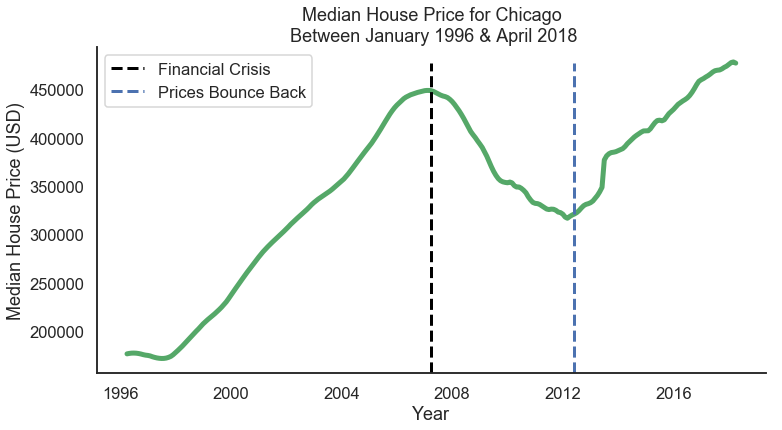

In [16]:
# Set figuresize and style
sns.set(rc={'figure.figsize':(12,6)},style="white", context="talk")

# Plot
    # Data
ax = sns.lineplot('date', 'mean', data=chicago_df_mean, color='g', lw=5);
    # Financial crisis vertical line
ax.axvline(x='2007-04', ymin=0, ymax=0.95, ls= "--", lw=3, color='black', label='Financial Crisis')
    # Upward trend vertical line
ax.axvline(x='2012-06', ymin=0, ymax=0.95, ls= "--", lw=3, color='b', label='Prices Bounce Back')

# Formatting
    # Title
title = 'Median House Price for Chicago\n Between January 1996 & April 2018'
ax.set_title(title)
    # Axis labels
xlabel = 'Year'
ylabel = "Median House Price (USD)"
ax.set(xlabel=xlabel, ylabel=ylabel)
    # Take off the border
sns.despine()
    # Show legend
plt.legend();

# Save the model as a png file
plt.savefig('../reports/figures/chicago_price_over_time_with_cutoffs.png', bbox_inches='tight')

* We can see from the chart that the house prices fall dramatically in 2007, perhaps due to the financial crisis.
* The house prices begin to bounce back in June 2012
* Due to the limitations in an ARIMA model, we decide to cut our dataset to be from June 2012 onwards

### Cut our Dataset from 2012-06 onwards

* Using CPI from:
https://liberalarts.oregonstate.edu/sites/liberalarts.oregonstate.edu/files/polisci/faculty-research/sahr/inflation-conversion/pdf/cv2017.pdf

2012 = 0.937

In [17]:
# Take data from 2012-06 onwards
chicago_df = chicago_df['2012-06':]
chicago_df.tail(3)

60657      60614     60640     60647     60618      60613  \
index                                                                       
2018-02-01  1030700.0  1306400.0  780500.0  475100.0  459000.0  1059300.0   
2018-03-01  1033800.0  1308500.0  782800.0  472600.0  462500.0  1060200.0   
2018-04-01  1030600.0  1307000.0  782800.0  470200.0  464300.0  1055300.0   

               60629     60625     60619      60610  ...     60612     60607  \
index                                                ...                       
2018-02-01  164000.0  464200.0  126800.0  1050400.0  ...  352300.0  579700.0   
2018-03-01  164000.0  463200.0  128000.0  1045000.0  ...  349000.0  579200.0   
2018-04-01  163800.0  461100.0  129600.0  1039700.0  ...  345400.0  577600.0   

               60659     60652     60631     60656     60655     60646  \
index                                                                    
2018-02-01  368300.0  174700.0  356400.0  300800.0  232400.0  398400.0   
2018-03-01  370800.0  174300.0  356900.0  303000.0  233000.0  400600.0   
2018-04-01  371400.0  173500.0  356200.0  304000.0  232600.0  401300.0   

               60642     60633  
index                           
2018-02-01  605800.0  112800.0  
2018-03-01  606700.0  113300.0  
2018-04-01  604400.0  113000.0  

[3 rows x 41 columns]

### Save the new csv file

In [18]:
chicago_df.to_csv('../data/processed/chicago_june2012_to_april2018')

## Deflating using CPI

### New DataFrame for deflation factors (values from Oregon State University, see README for details)

In [19]:
# New Dataframe
deflation_factors_2012_to_2019 = pd.DataFrame({'year': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                          'factor': [0.937, 0.950, 0.966, 0.967, 0.979, 1.000, 1.020, 1.042]})
# Change the year column to datetime format
deflation_factors_2012_to_2019['year'] = pd.to_datetime(deflation_factors_2012_to_2019['year'], format='%Y')
# Set the year column to be the index
deflation_factors_2012_to_2019.set_index('year', inplace=True)
# Expand dataframe to have each month of the years alongside its deflation factor
deflation_factors_2012_to_2019 = deflation_factors_2012_to_2019.resample('M').ffill()
# Take off the months we don't need for now
deflation_factors_2012_to_2018 = deflation_factors_2012_to_2019[5:-9]  # 2012-06 to 2018-04
# Change the index (dates) to datetime
deflation_factors_2012_to_2018.index = [pd.datetime(x.year, x.month, 1) for x in deflation_factors_2012_to_2018.index.tolist()]
print(deflation_factors_2012_to_2018.head(3))
print(deflation_factors_2012_to_2018.tail(3))

            factor
2012-06-01   0.937
2012-07-01   0.937
2012-08-01   0.937
            factor
2018-02-01    1.02
2018-03-01    1.02
2018-04-01    1.02


### Reduce each price by the CPI deflation value

In [20]:
# Concatenate 2 dataframes
chicago_df_defl = pd.concat([chicago_df, deflation_factors_2012_to_2018], axis=1)

# Divide each price value by the corresponding CPI deflation value
for column in chicago_df_defl.columns[:-1]:
    chicago_df_defl[column] = chicago_df_defl[column].div(chicago_df_defl['factor'])

# Drop factor column
chicago_df_defl.drop('factor', axis=1, inplace=True)
    
chicago_df_defl.head(3)

60657         60614          60640          60647  \
2012-06-01  800960.512273  1.030309e+06  588046.958378  294770.544290   
2012-07-01  811526.147279  1.041515e+06  581963.713981  296371.398079   
2012-08-01  823692.636073  1.050694e+06  583244.397012  300320.170758   

                    60618          60613          60629          60625  \
2012-06-01  321451.440768  795517.609392  113980.789755  344930.629669   
2012-07-01  326360.725720  800106.723586  114194.236926  345037.353255   
2012-08-01  331483.457844  807043.756670  115368.196371  345144.076841   

                    60619          60610  ...          60612          60607  \
2012-06-01  114621.131270  839167.556030  ...  214300.960512  428068.303095   
2012-07-01  116862.326574  838420.490928  ...  218890.074707  430736.392743   
2012-08-01  119423.692636  839487.726788  ...  224012.806830  435112.059765   

                    60659          60652          60631          60656  \
2012-06-01  279615.795091  135325.506937  276307.363927  229348.986126   
2012-07-01  277161.152615  135005.336179  275560.298826  230522.945571   
2012-08-01  275880.469584  134685.165422  275453.575240  231590.181430   

                    60655          60646          60642         60633  
2012-06-01  195731.056564  321878.335112  410779.082177  91568.836713  
2012-07-01  196478.121665  323906.083244  419637.139808  91675.560299  
2012-08-01  197545.357524  328175.026681  427748.132337  91248.665955  

[3 rows x 41 columns]

### Check for missing values

In [21]:
# chicago_df_defl.isna().sum()
chicago_df_defl.isna().sum().sort_values(ascending=False).head(3)

60611    13
60633     0
60660     0
dtype: int64

* Only zipcode 60611 has missing values

In [22]:
# Check which dates are missing in 60611
chicago_df_defl[60611][chicago_df_defl[60611].isna()]

2012-06-01   NaN
2012-07-01   NaN
2012-08-01   NaN
2012-09-01   NaN
2012-10-01   NaN
2012-11-01   NaN
2012-12-01   NaN
2013-01-01   NaN
2013-02-01   NaN
2013-03-01   NaN
2013-04-01   NaN
2013-05-01   NaN
2013-06-01   NaN
Name: 60611, dtype: float64

* Zipcode 60611 has 13 missing values, from 2012-06 to 2013-07
* As we have 40 other zipcodes to use, we will drop 60611

In [23]:
# Drop 60611 from dataframe
chicago_df_defl.drop([60611], axis=1, inplace=True)

### Save the new csv file

In [24]:
chicago_df_defl.to_csv('../data/processed/chicago_june2012_to_april2018_deflated')

# Transformation

## Train-Test split

In [25]:
chicago_df_defl_train = chicago_df_defl.loc['2012-06':'2017-10',:] # 5 years 4 months for train data
chicago_df_defl_test = chicago_df_defl.loc['2017-11':'2018-04',:] # 6 months for test data

## Visualize data prior to detrending

### Whole Price Range

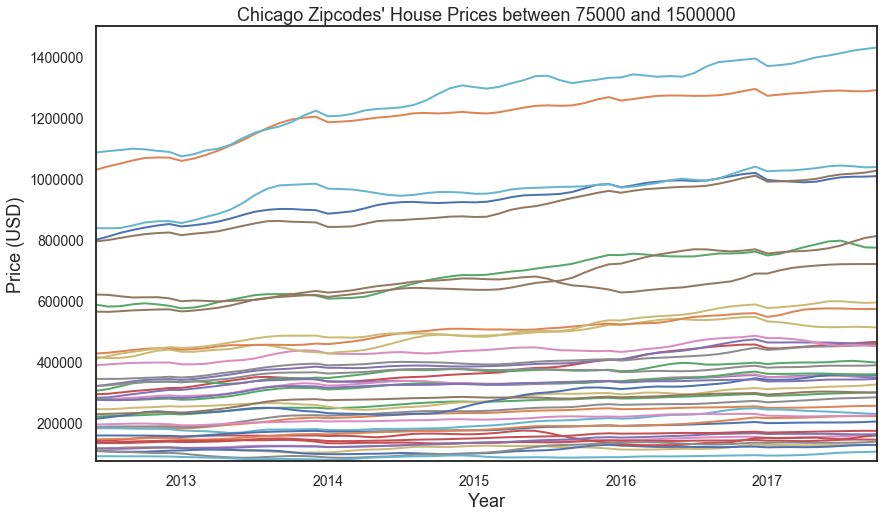

In [26]:
viz.price_over_time(chicago_df_defl_train)

* It is difficult to see the change in price for each zipcode, so we will adjust the y axis to take a closer look at different price ranges

#### Price Range < 500,000

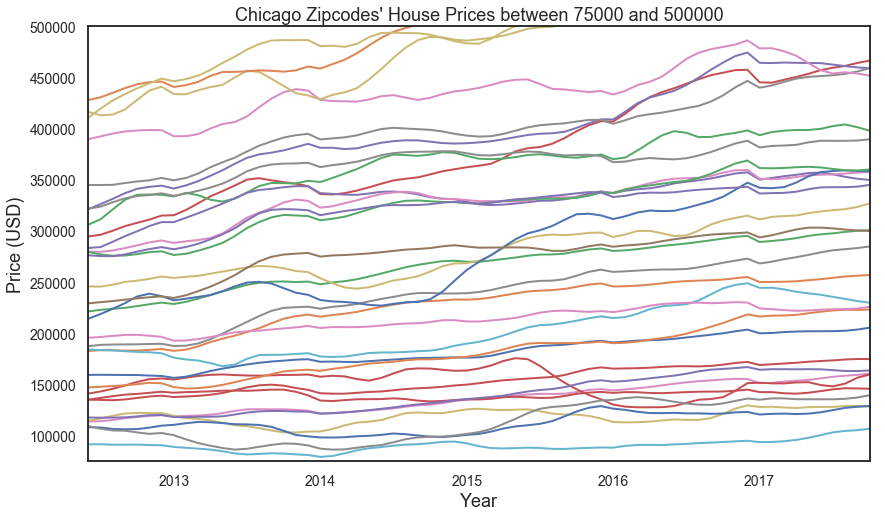

In [27]:
viz.price_over_time(chicago_df_defl_train, y_lim_max=500_000)

#### Price Range  400,000 to 800,000

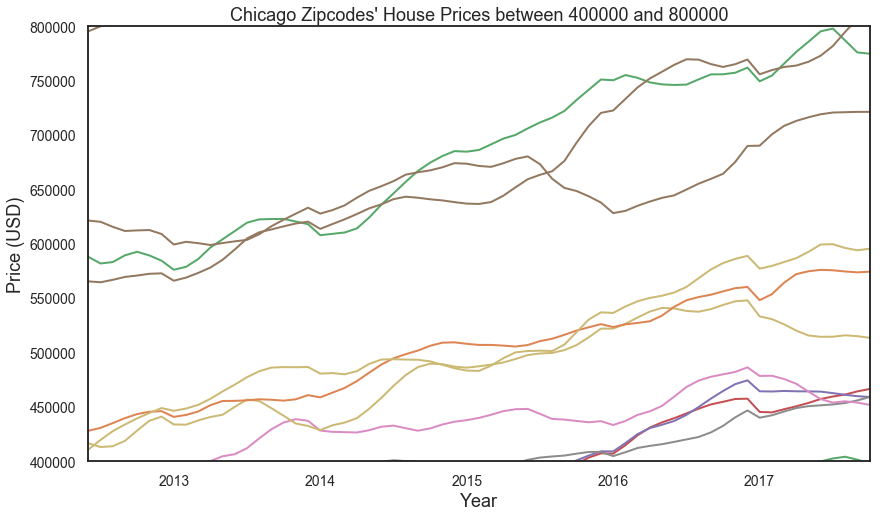

In [28]:
viz.price_over_time(chicago_df_defl_train, y_lim_min=400_000, y_lim_max=800_000)

#### Price Range 800,000 to 1,400,000

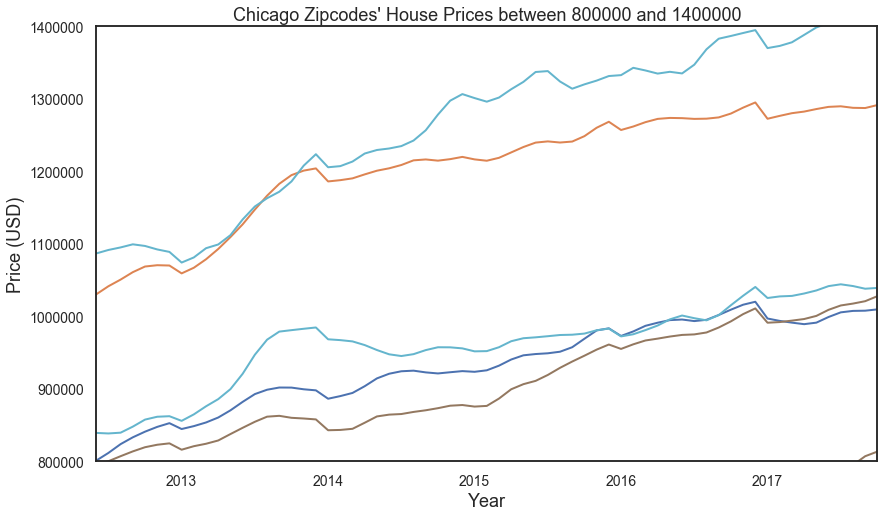

In [29]:
viz.price_over_time(chicago_df_defl_train, y_lim_min=800_000, y_lim_max=1_400_000)

### Takeaways from visualizations

* There appears to be no seasonality or cycles in the data, but there are upwards trends and random noise.
* In order to run analysis on the zipcode, we need to detrend our data from any trends

## Testing each Zipcode for stationarity

In [30]:
# Function to help us check whether a zipcode's price is stationary over time
def stationarity_check(TS, column, plot_std=True):
    '''Outputs a plot of the Rolling Mean and Standard Deviation and prints results of the Dickey-Fuller Test
      TS: Time Series, this is the dataframe from which you are pulling your information
      column: This is the column within the TS that you are interested in
      plot_std: optional to plot the standard deviation or not'''
    
    # Calculate rolling statistics
    rolmean = TS[column].rolling(window = 8, center = False).mean()
    rolstd = TS[column].rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column].dropna())
    
    # Formatting
    fig = plt.figure(figsize=(14,8))
    
    #Plot rolling statistics:
    orig = plt.plot(TS[column], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        # Optional plot of standard deviation
    if plot_std:
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.title('Rolling Mean & Standard Deviation for {}'.format(column)) # alternative title
    else:
        plt.title('Rolling Mean for {}'.format(column)) # alternative title
    
    # Legend and show
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value {}'.format(key)] = value
    print (dfoutput)

### Plots of zipcodes' original price with rolling mean and standard deviation, with Dickey Fuller test results

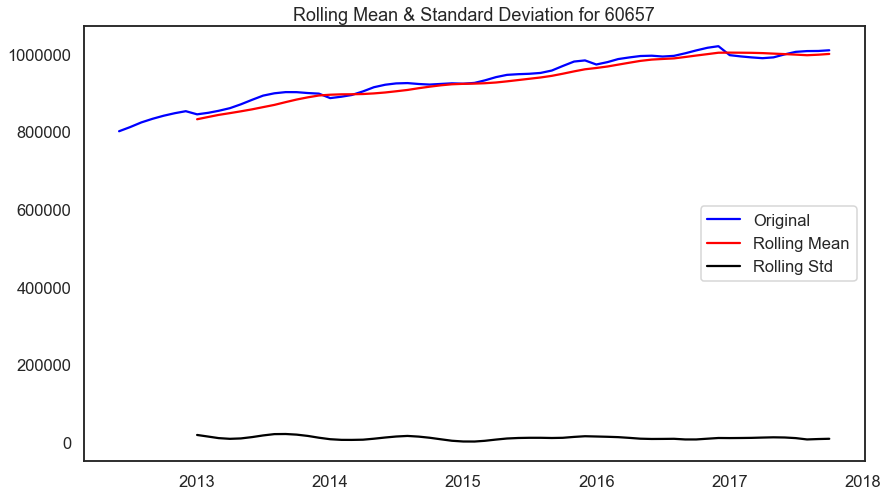

Results of Dickey-Fuller Test:
Test Statistic                 -1.760632
p-value                         0.400175
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


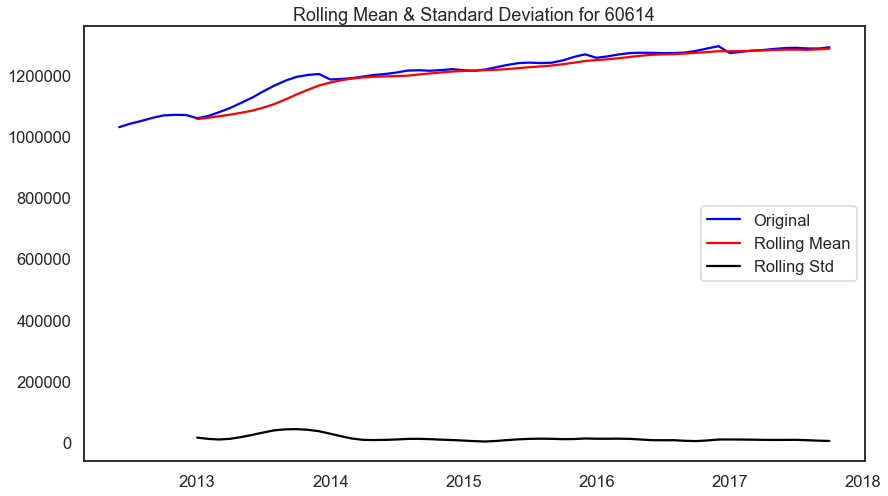

Results of Dickey-Fuller Test:
Test Statistic                 -2.243604
p-value                         0.190802
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


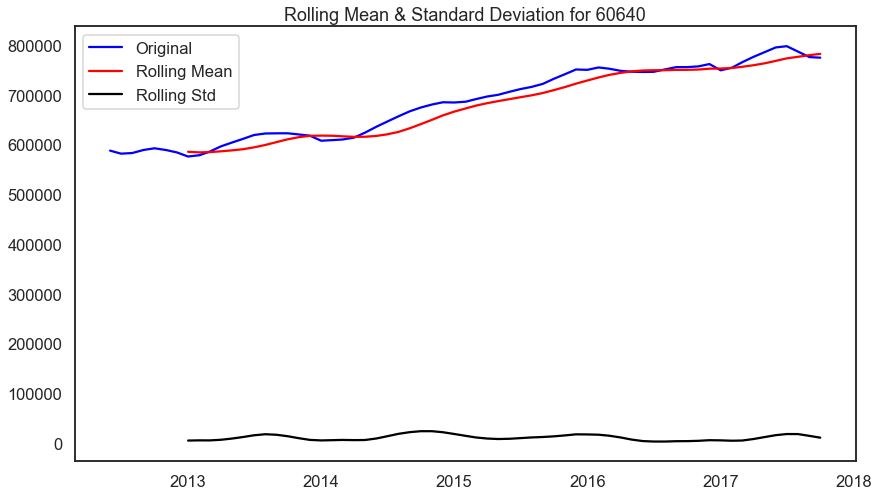

Results of Dickey-Fuller Test:
Test Statistic                 -0.565084
p-value                         0.878678
#Lags Used                      5.000000
Number of Observations Used    59.000000
Critical Value 1%              -3.546395
Critical Value 5%              -2.911939
Critical Value 10%             -2.593652
dtype: float64


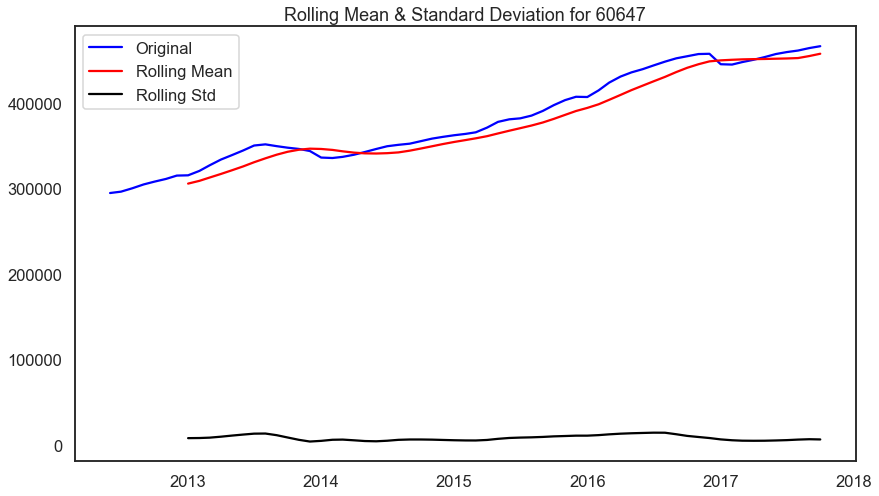

Results of Dickey-Fuller Test:
Test Statistic                 -0.600852
p-value                         0.870789
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


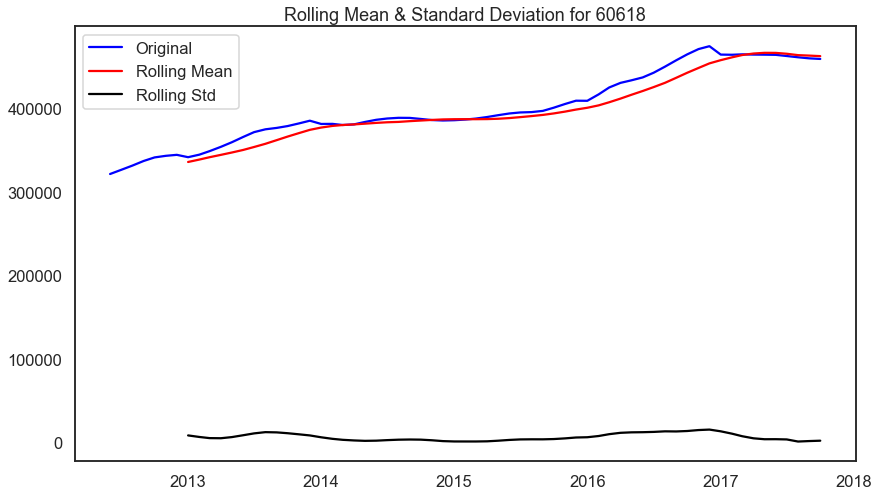

Results of Dickey-Fuller Test:
Test Statistic                 -1.146561
p-value                         0.696151
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


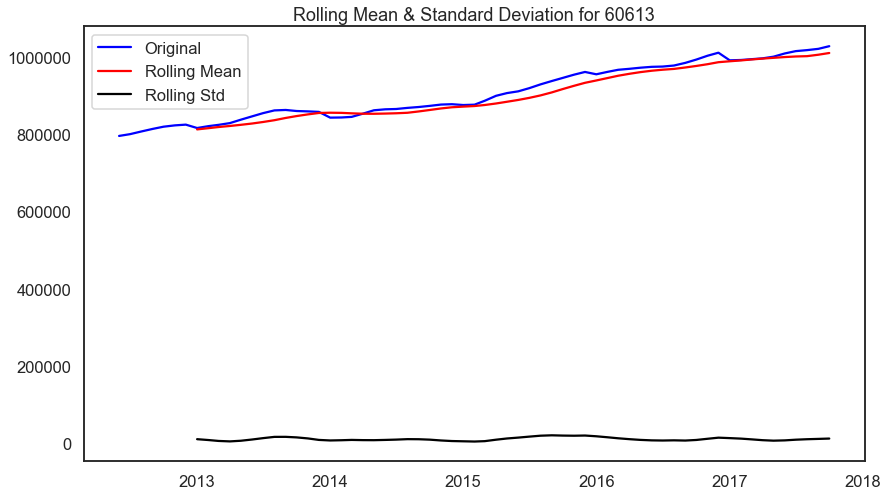

Results of Dickey-Fuller Test:
Test Statistic                 -0.091909
p-value                         0.950238
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


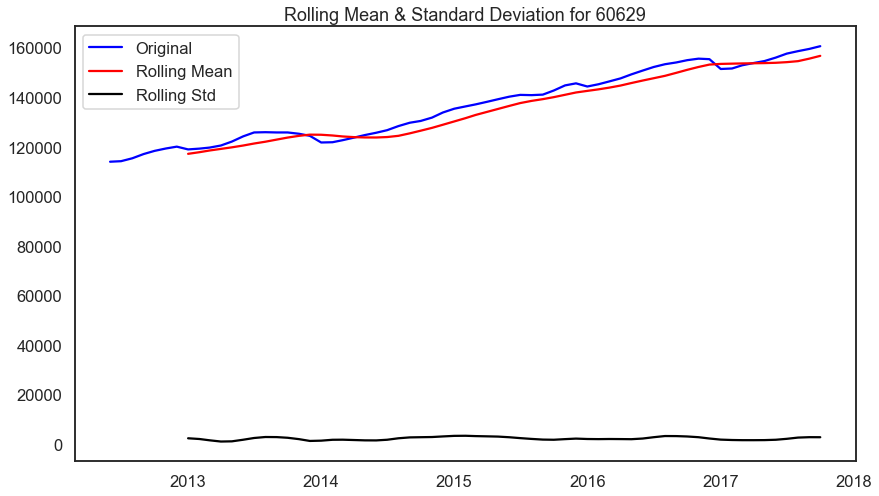

Results of Dickey-Fuller Test:
Test Statistic                 -0.307841
p-value                         0.924386
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


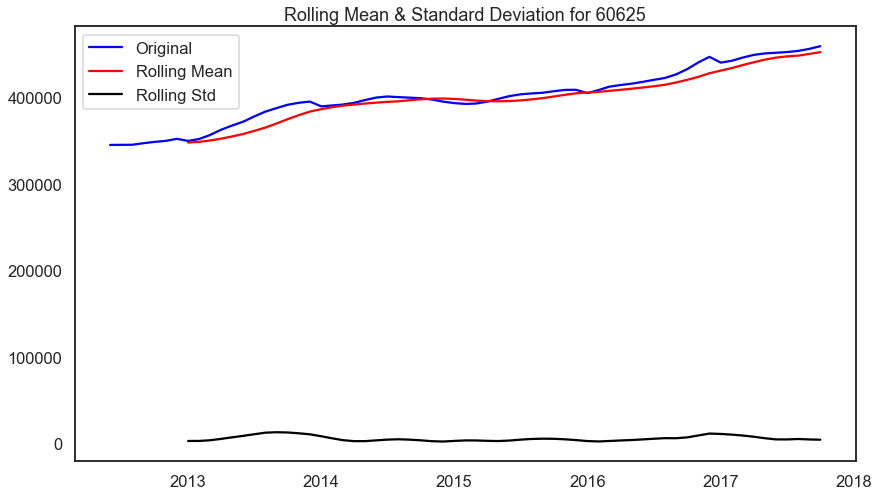

Results of Dickey-Fuller Test:
Test Statistic                 -0.487706
p-value                         0.894393
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


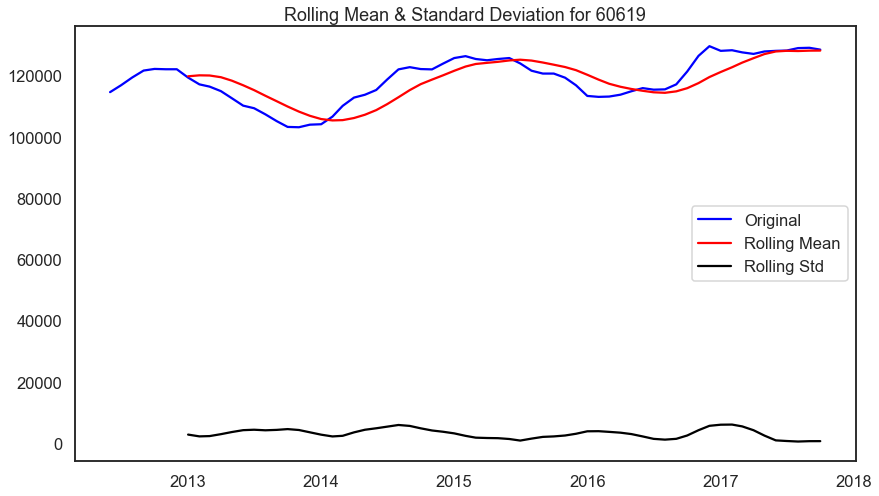

Results of Dickey-Fuller Test:
Test Statistic                 -2.567286
p-value                         0.099949
#Lags Used                      4.000000
Number of Observations Used    60.000000
Critical Value 1%              -3.544369
Critical Value 5%              -2.911073
Critical Value 10%             -2.593190
dtype: float64


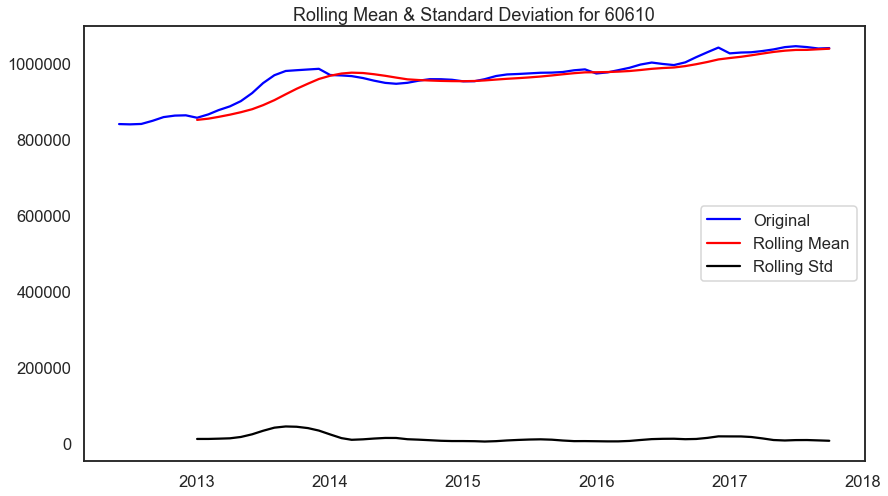

Results of Dickey-Fuller Test:
Test Statistic                 -2.033298
p-value                         0.272167
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


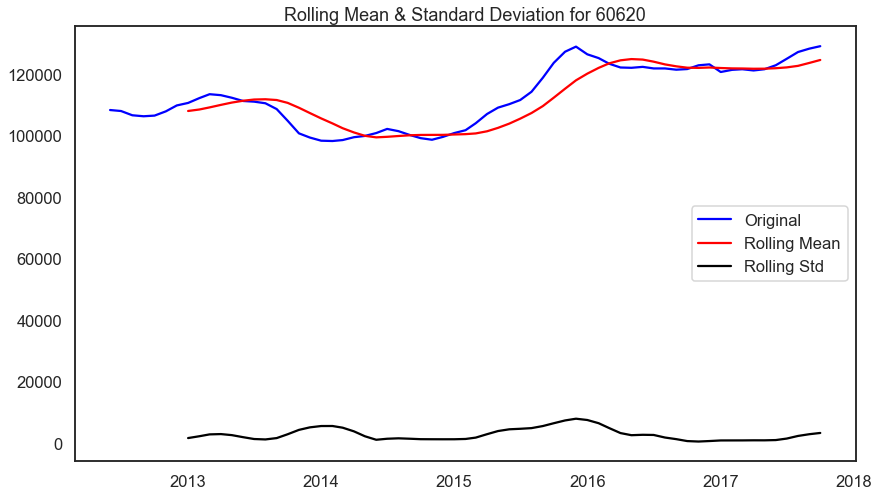

Results of Dickey-Fuller Test:
Test Statistic                 -1.021470
p-value                         0.745353
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


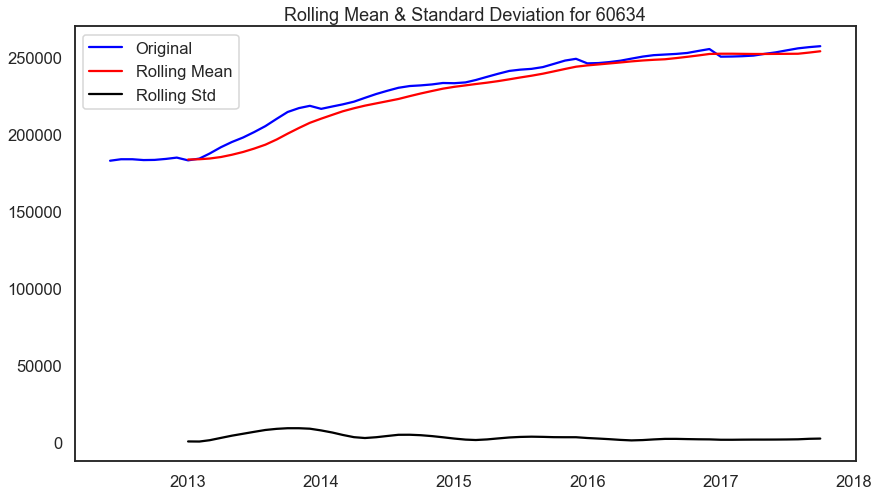

Results of Dickey-Fuller Test:
Test Statistic                 -1.719661
p-value                         0.421012
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


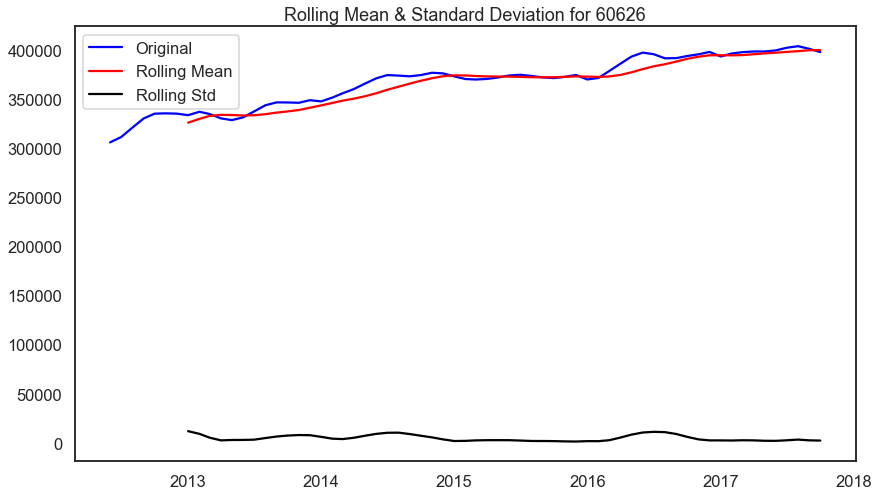

Results of Dickey-Fuller Test:
Test Statistic                 -1.491170
p-value                         0.537875
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


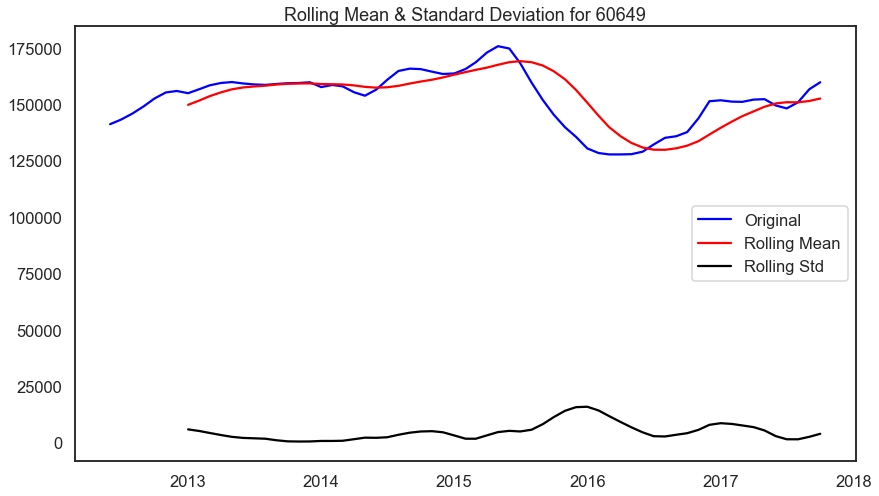

Results of Dickey-Fuller Test:
Test Statistic                 -2.354118
p-value                         0.155107
#Lags Used                      3.000000
Number of Observations Used    61.000000
Critical Value 1%              -3.542413
Critical Value 5%              -2.910236
Critical Value 10%             -2.592745
dtype: float64


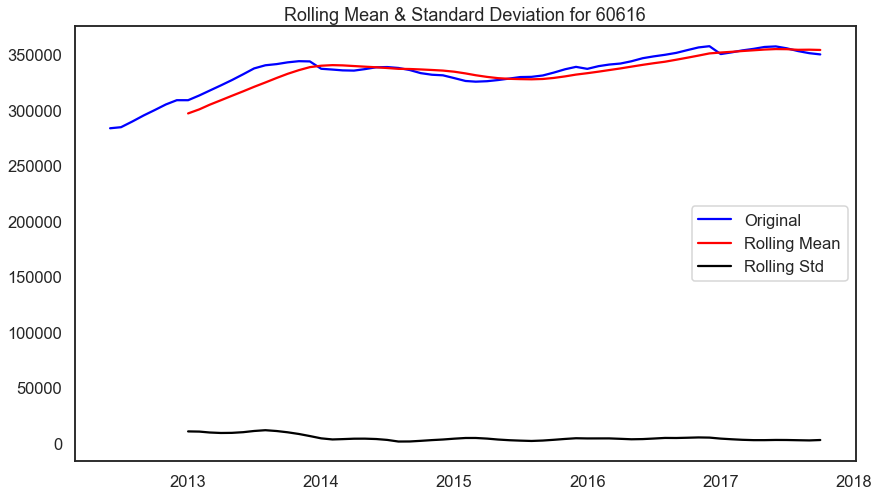

Results of Dickey-Fuller Test:
Test Statistic                 -3.516692
p-value                         0.007569
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


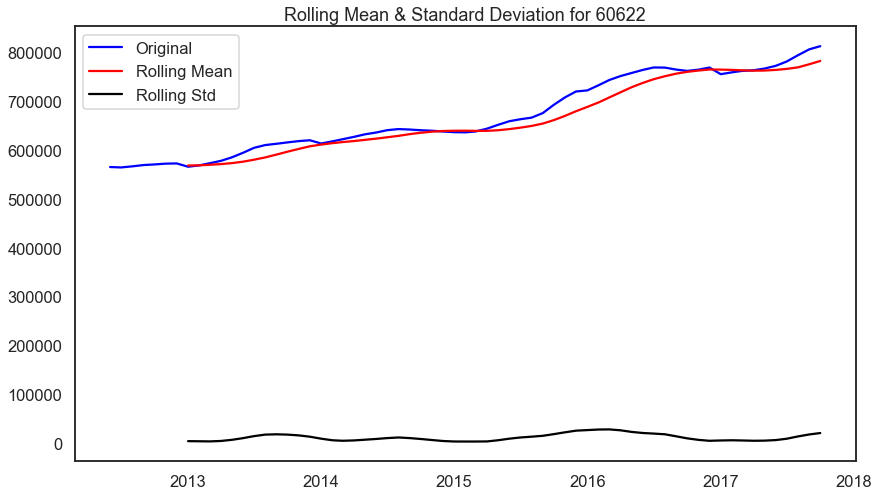

Results of Dickey-Fuller Test:
Test Statistic                  0.200546
p-value                         0.972292
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


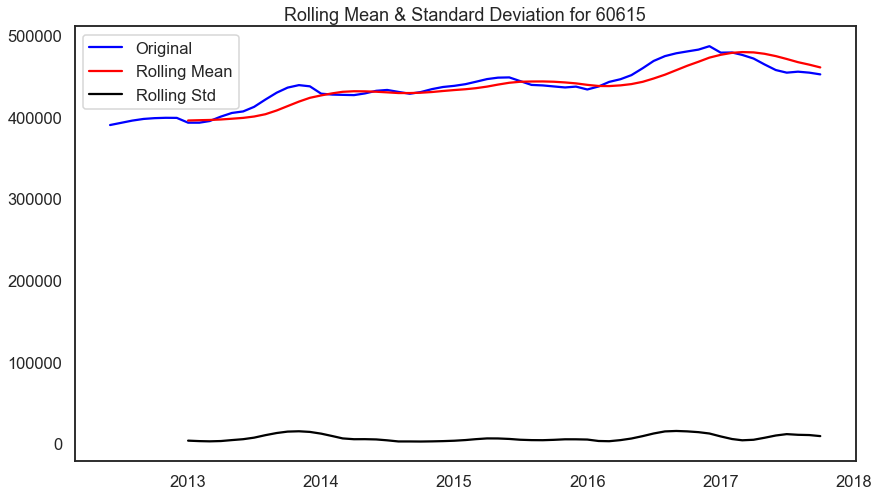

Results of Dickey-Fuller Test:
Test Statistic                 -1.829416
p-value                         0.365958
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


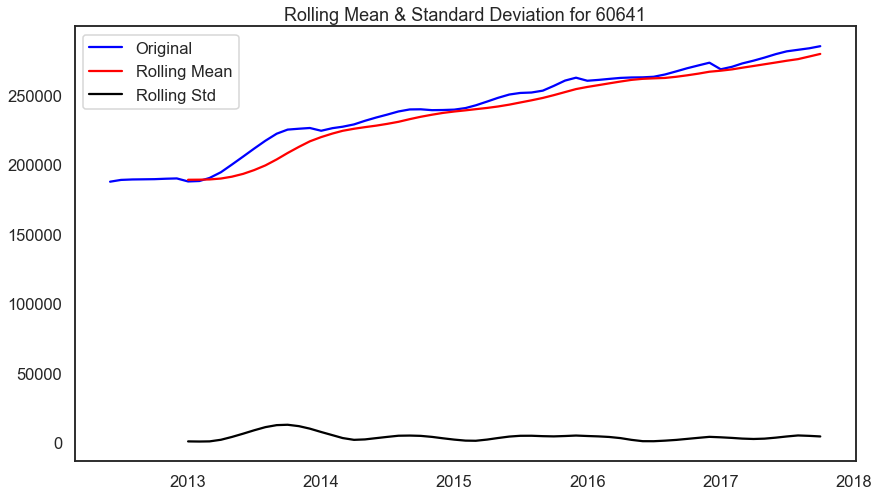

Results of Dickey-Fuller Test:
Test Statistic                 -0.907004
p-value                         0.785657
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


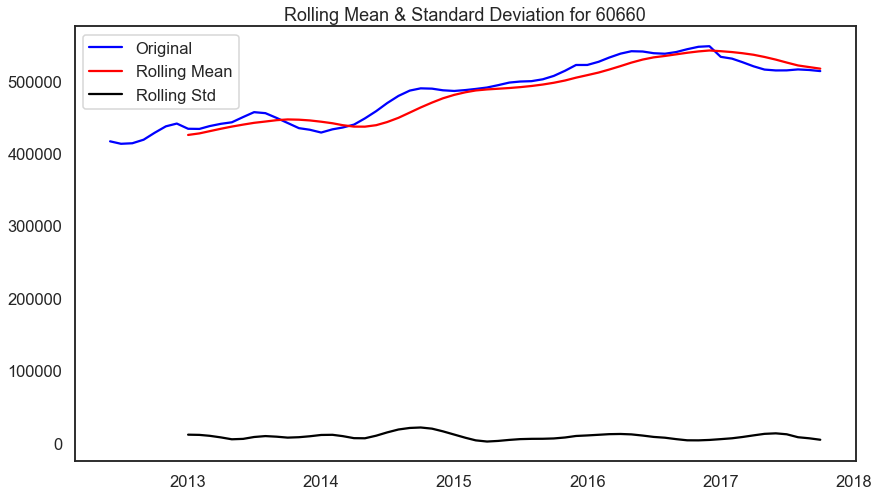

Results of Dickey-Fuller Test:
Test Statistic                 -1.892107
p-value                         0.335783
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


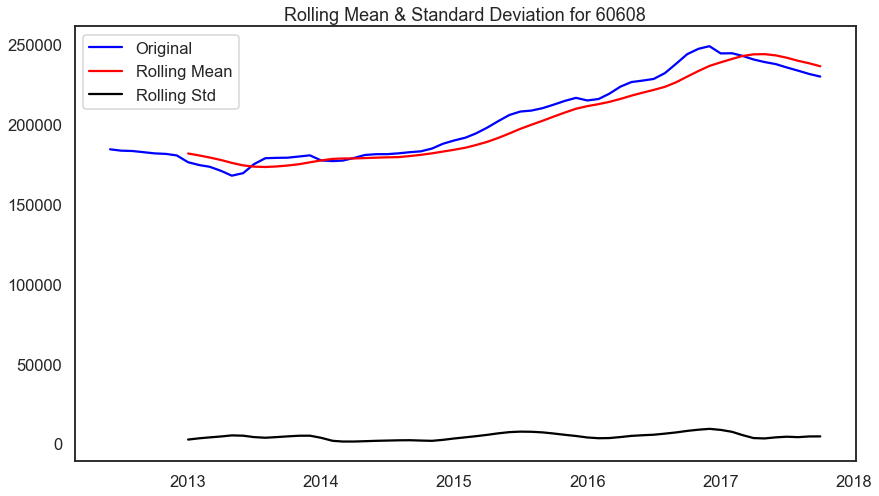

Results of Dickey-Fuller Test:
Test Statistic                 -0.584842
p-value                         0.874370
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


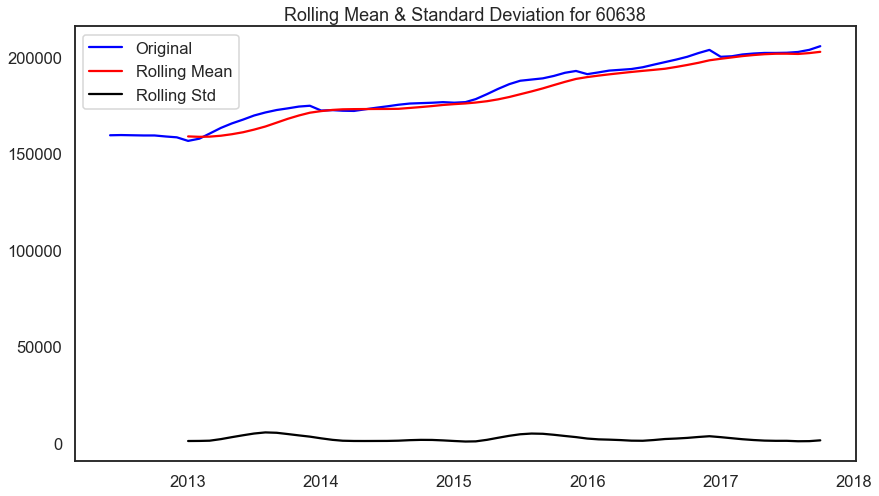

Results of Dickey-Fuller Test:
Test Statistic                 -0.332324
p-value                         0.920800
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


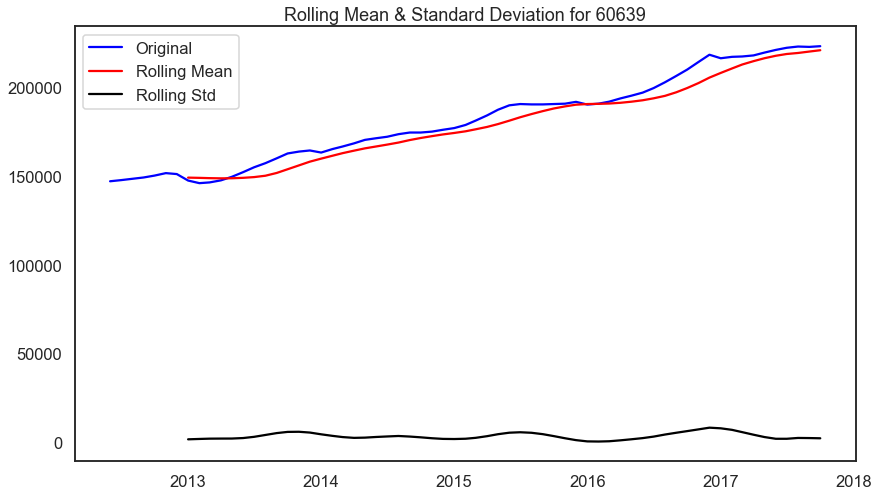

Results of Dickey-Fuller Test:
Test Statistic                 -0.105320
p-value                         0.948906
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


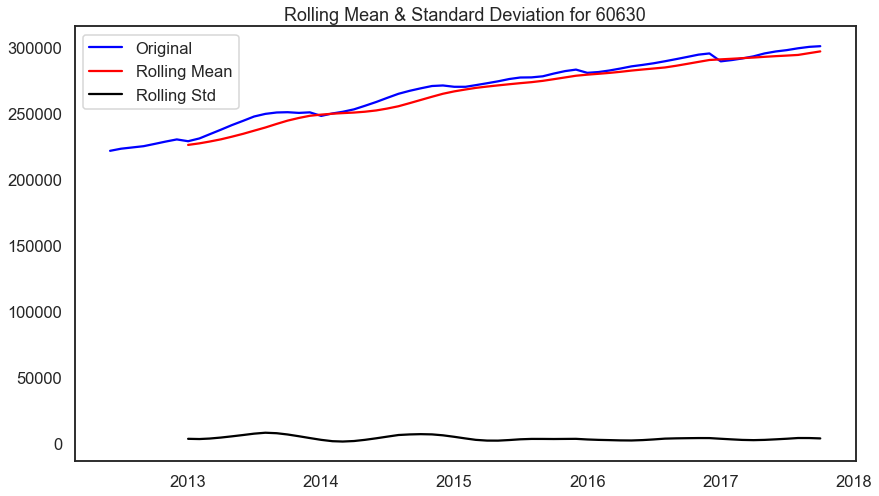

Results of Dickey-Fuller Test:
Test Statistic                 -4.096169
p-value                         0.000983
#Lags Used                     10.000000
Number of Observations Used    54.000000
Critical Value 1%              -3.557709
Critical Value 5%              -2.916770
Critical Value 10%             -2.596222
dtype: float64


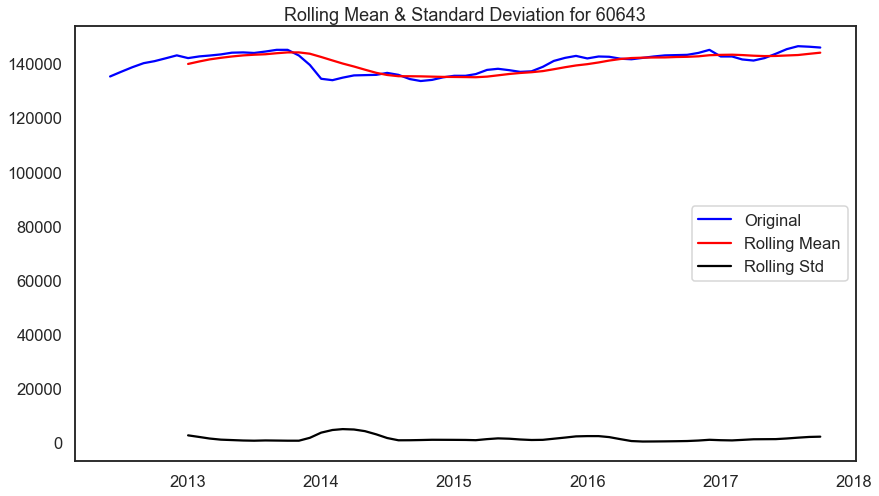

Results of Dickey-Fuller Test:
Test Statistic                 -2.217775
p-value                         0.199857
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


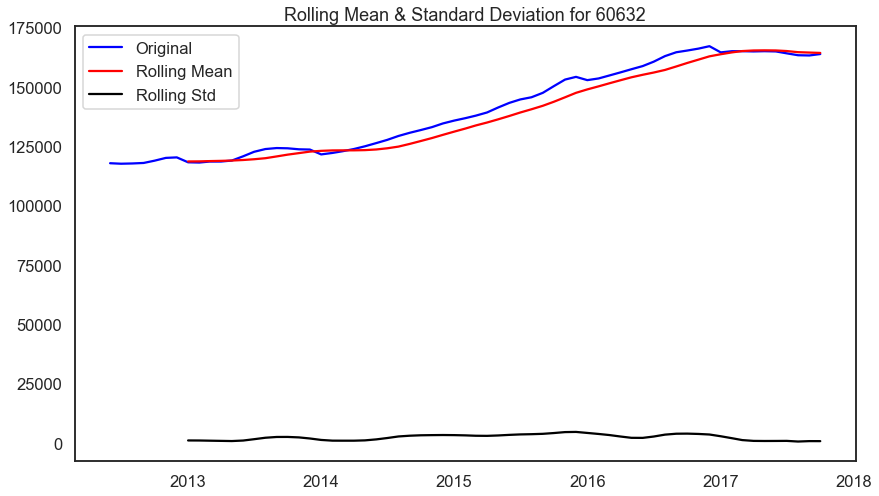

Results of Dickey-Fuller Test:
Test Statistic                 -0.455622
p-value                         0.900389
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


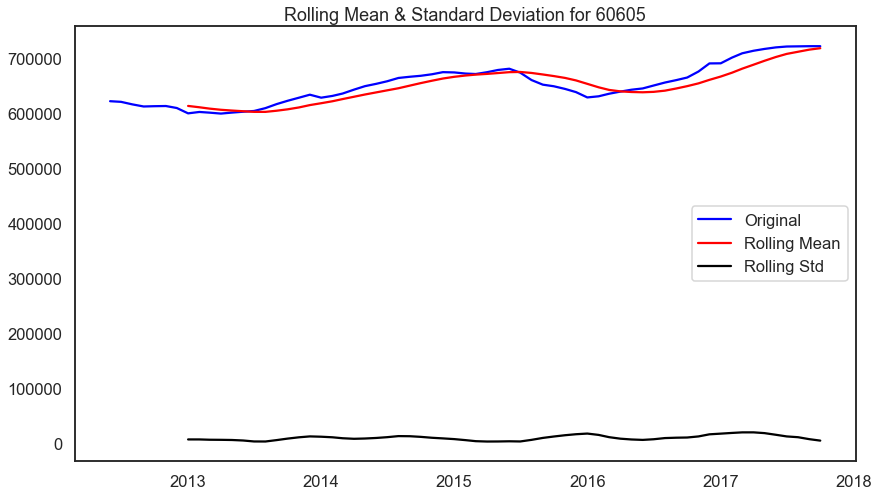

Results of Dickey-Fuller Test:
Test Statistic                 -0.606135
p-value                         0.869590
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


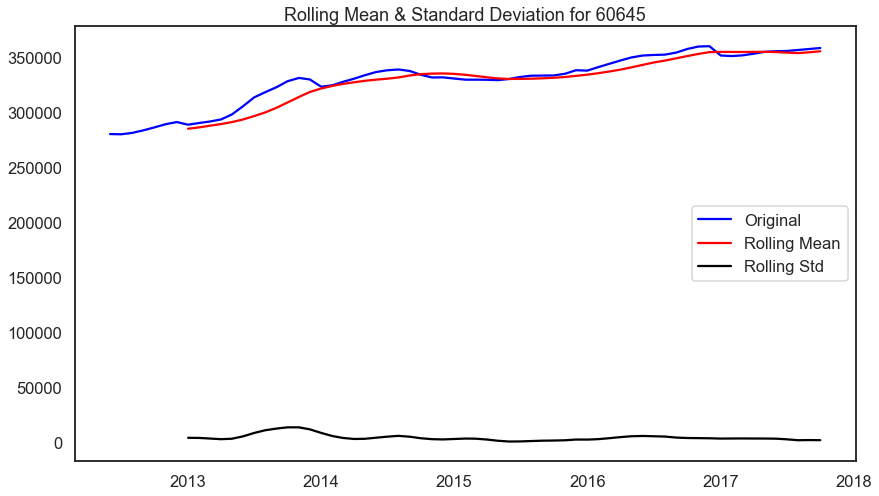

Results of Dickey-Fuller Test:
Test Statistic                 -2.059726
p-value                         0.261014
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


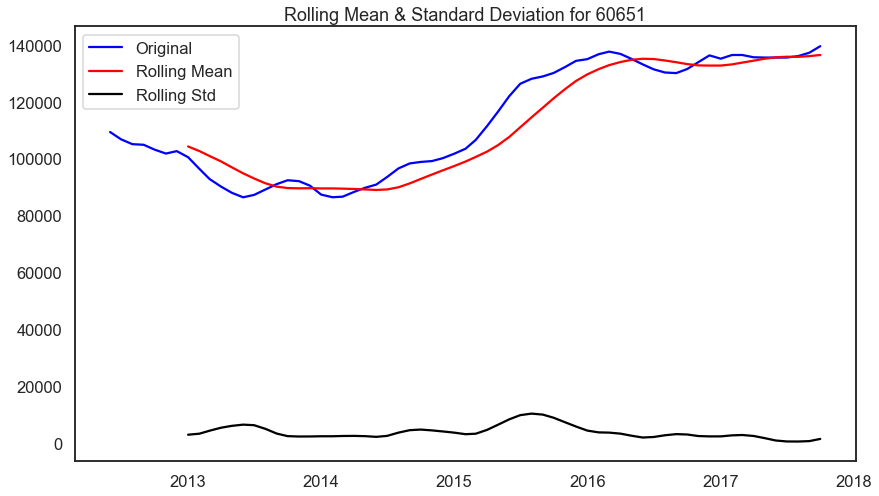

Results of Dickey-Fuller Test:
Test Statistic                 -0.402473
p-value                         0.909685
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


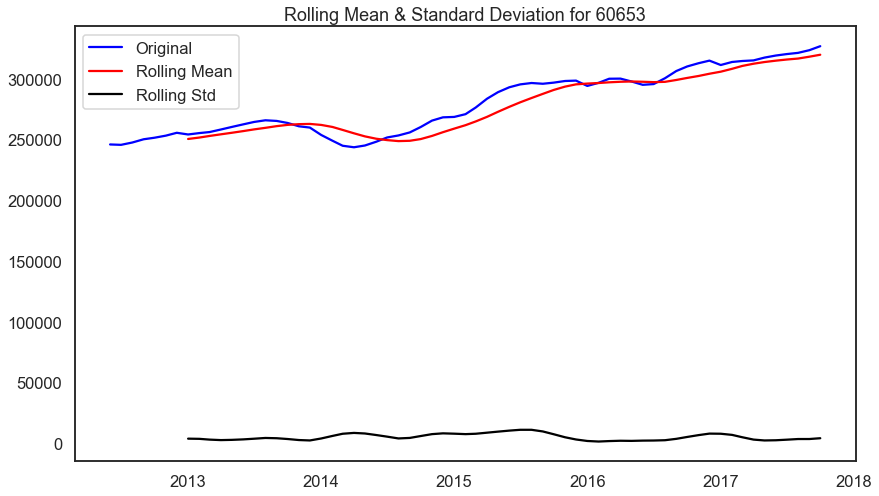

Results of Dickey-Fuller Test:
Test Statistic                 -0.331475
p-value                         0.920927
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


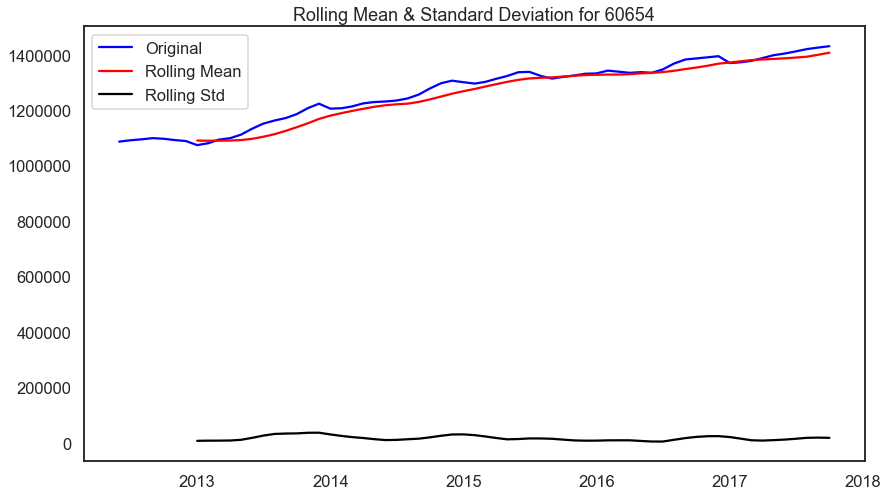

Results of Dickey-Fuller Test:
Test Statistic                 -0.802033
p-value                         0.818524
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


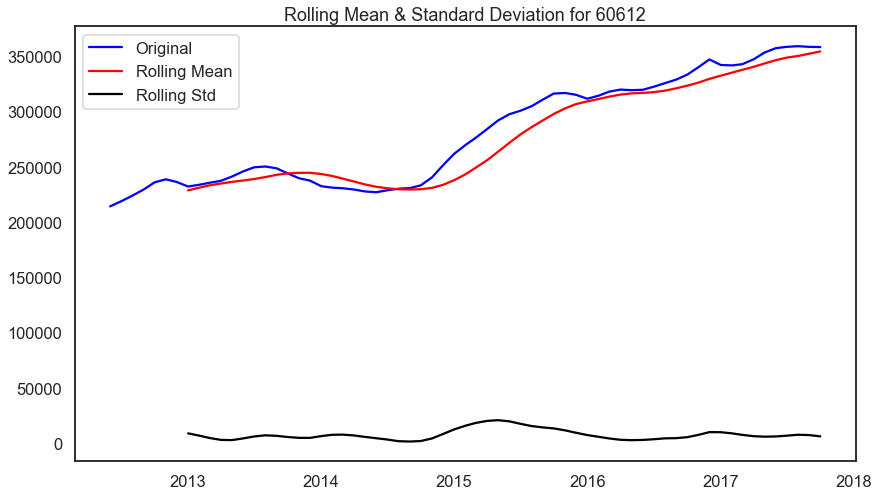

Results of Dickey-Fuller Test:
Test Statistic                 -0.163018
p-value                         0.942789
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


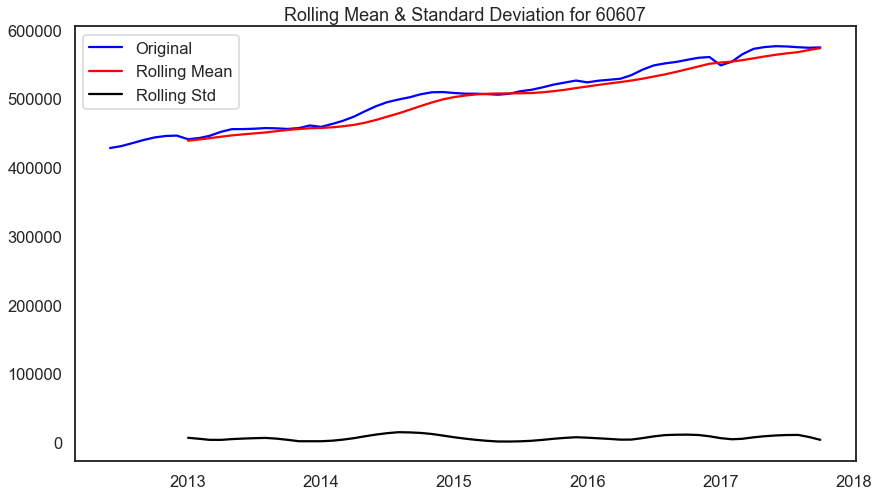

Results of Dickey-Fuller Test:
Test Statistic                 -0.622533
p-value                         0.865809
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


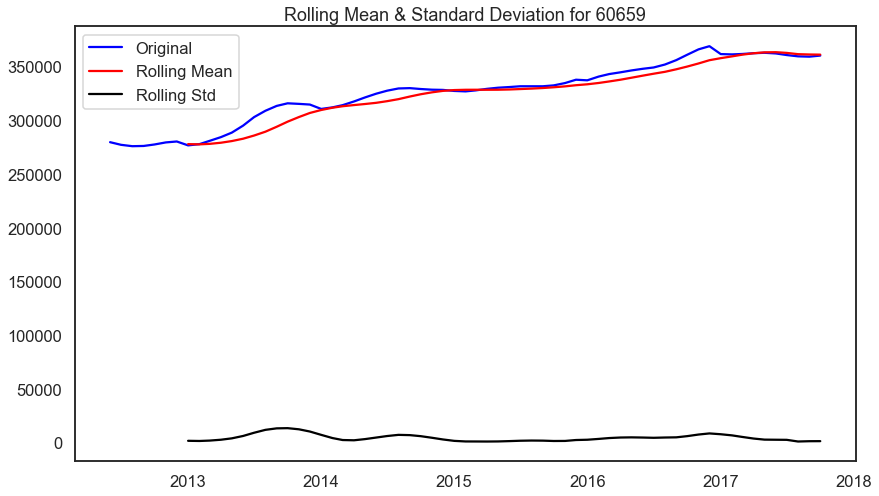

Results of Dickey-Fuller Test:
Test Statistic                 -1.600722
p-value                         0.483231
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


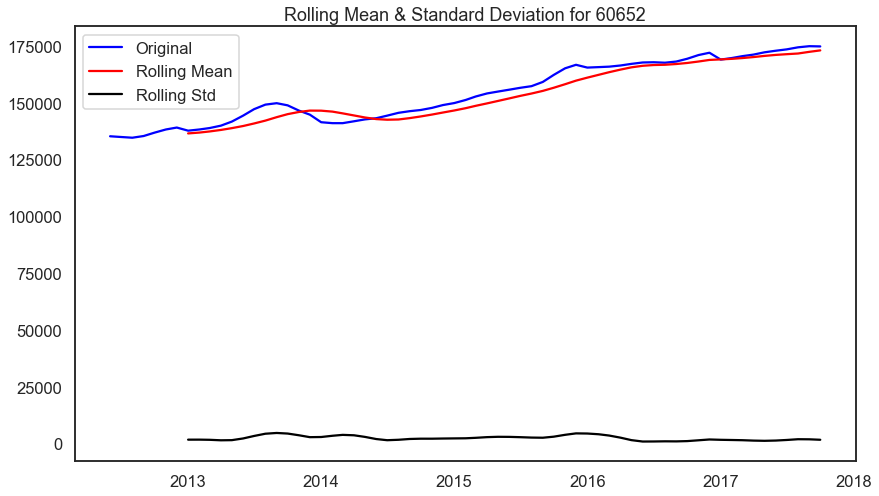

Results of Dickey-Fuller Test:
Test Statistic                 -0.836613
p-value                         0.808130
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


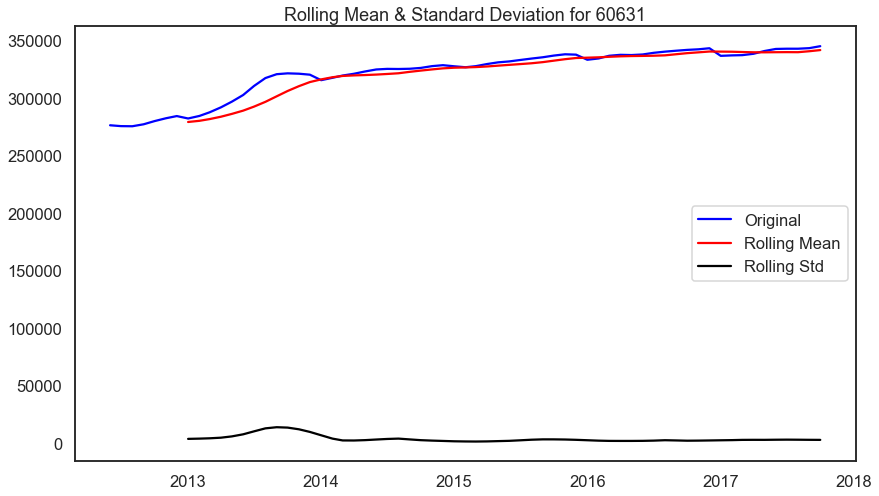

Results of Dickey-Fuller Test:
Test Statistic                 -2.466452
p-value                         0.123852
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


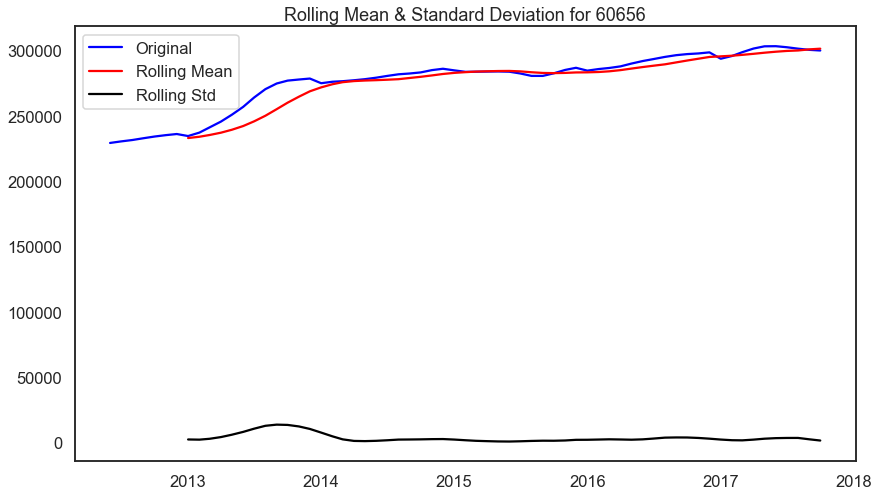

Results of Dickey-Fuller Test:
Test Statistic                 -2.260267
p-value                         0.185103
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


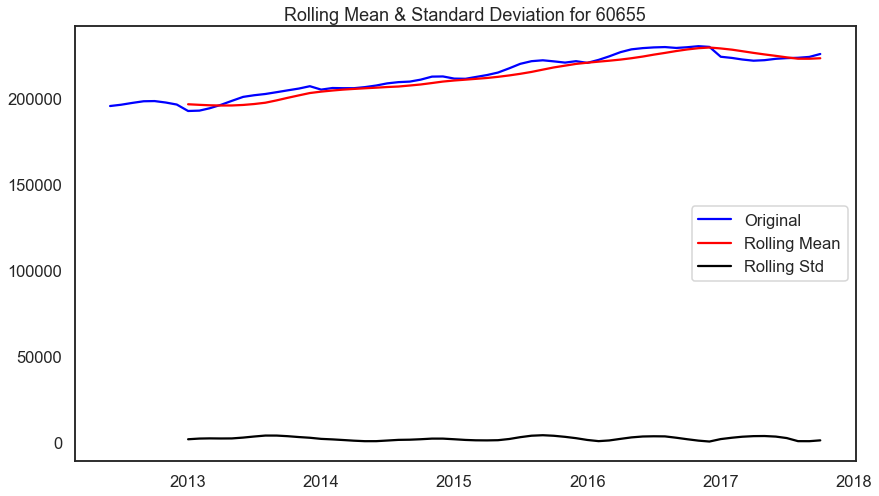

Results of Dickey-Fuller Test:
Test Statistic                 -1.036080
p-value                         0.739879
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


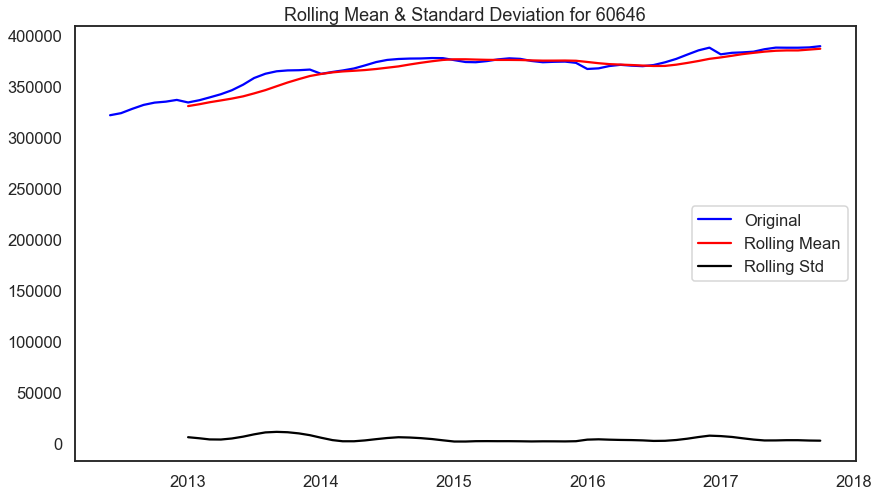

Results of Dickey-Fuller Test:
Test Statistic                 -2.457788
p-value                         0.126086
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


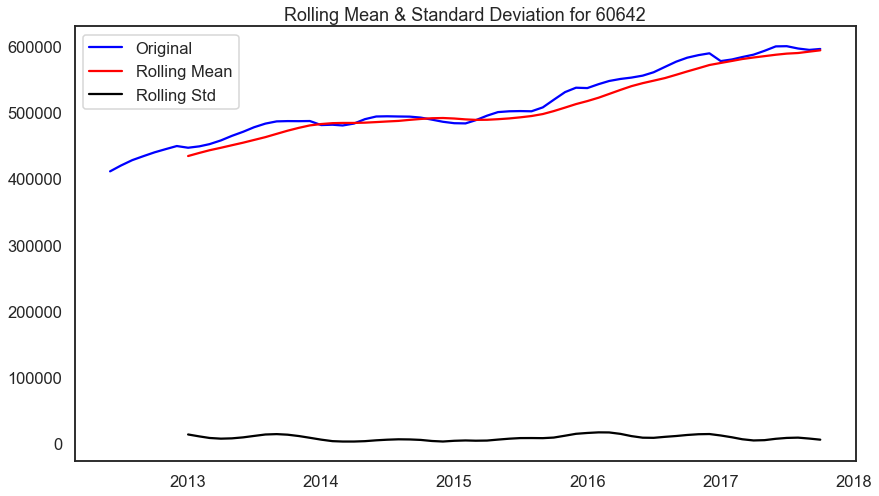

Results of Dickey-Fuller Test:
Test Statistic                 -0.718584
p-value                         0.841877
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


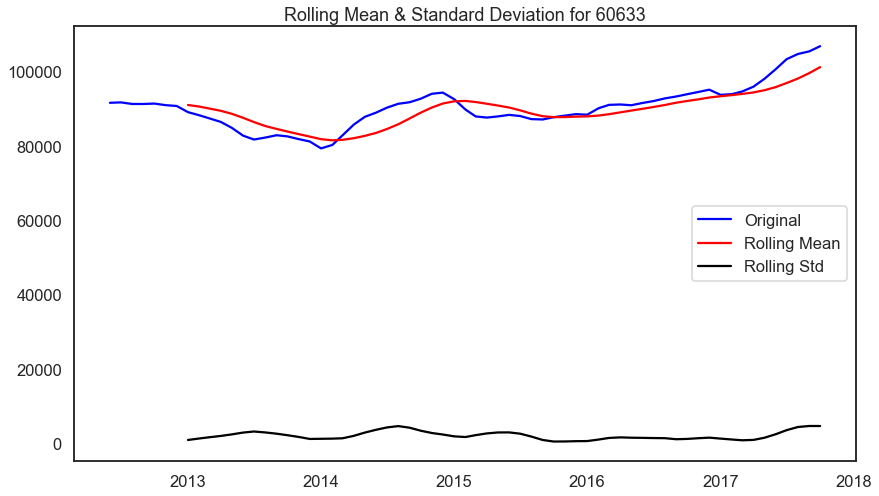

Results of Dickey-Fuller Test:
Test Statistic                  0.086287
p-value                         0.965112
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [31]:
[stationarity_check(chicago_df_defl_train,x, plot_std=True) for x in list(chicago_df_defl_train.columns)]

### Plots of zipcodes' original price with rolling mean, with Dickey Fuller test results

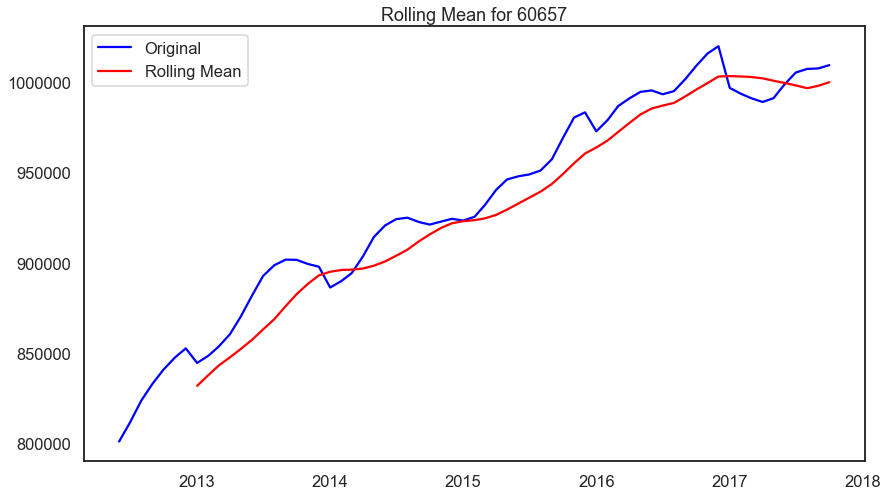

Results of Dickey-Fuller Test:
Test Statistic                 -1.760632
p-value                         0.400175
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


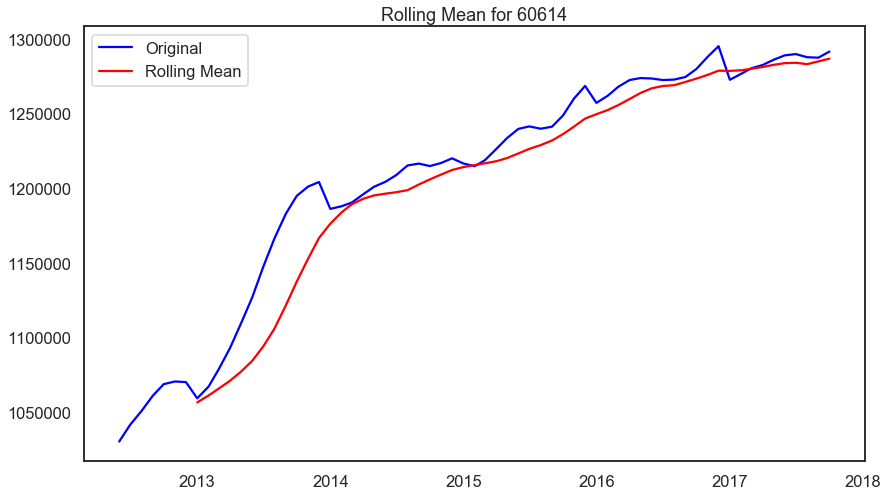

Results of Dickey-Fuller Test:
Test Statistic                 -2.243604
p-value                         0.190802
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


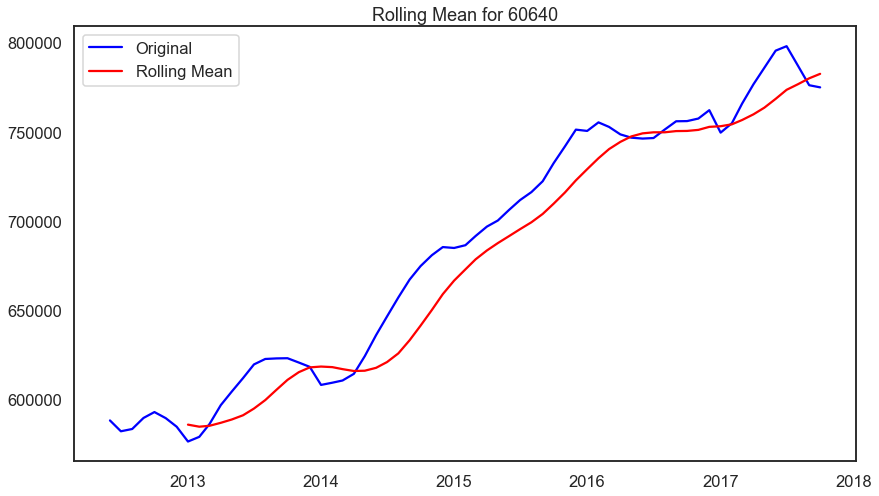

Results of Dickey-Fuller Test:
Test Statistic                 -0.565084
p-value                         0.878678
#Lags Used                      5.000000
Number of Observations Used    59.000000
Critical Value 1%              -3.546395
Critical Value 5%              -2.911939
Critical Value 10%             -2.593652
dtype: float64


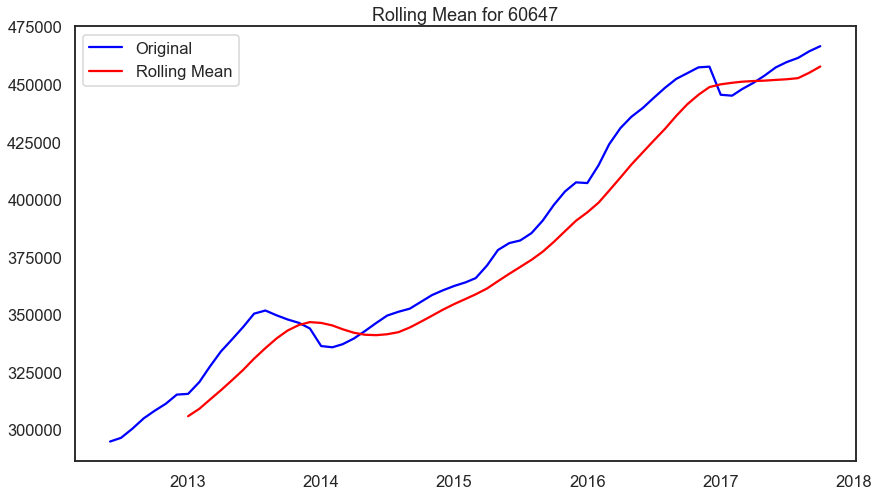

Results of Dickey-Fuller Test:
Test Statistic                 -0.600852
p-value                         0.870789
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


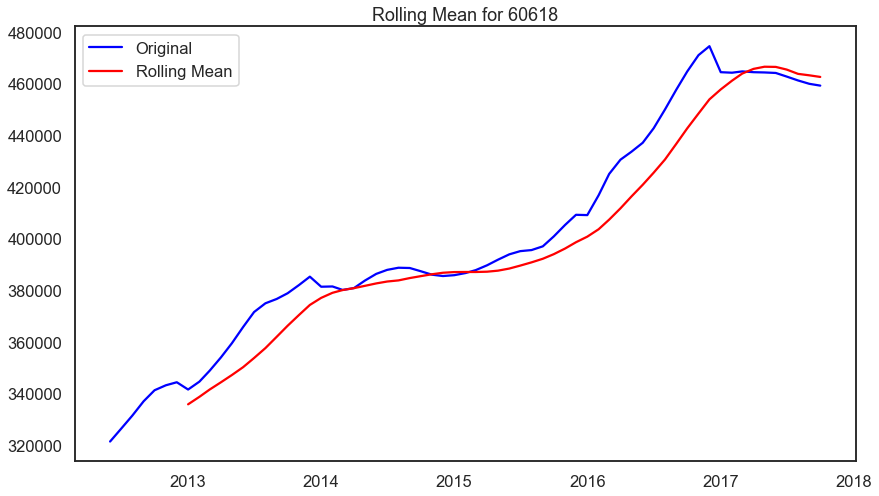

Results of Dickey-Fuller Test:
Test Statistic                 -1.146561
p-value                         0.696151
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


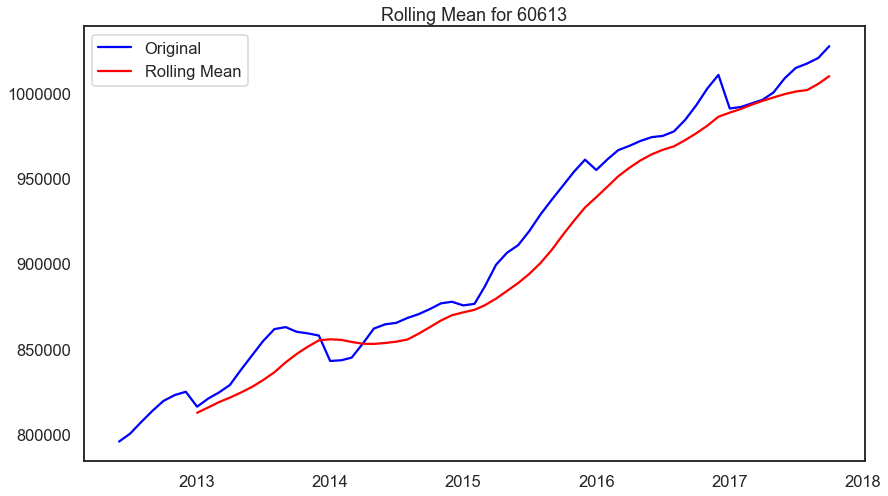

Results of Dickey-Fuller Test:
Test Statistic                 -0.091909
p-value                         0.950238
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


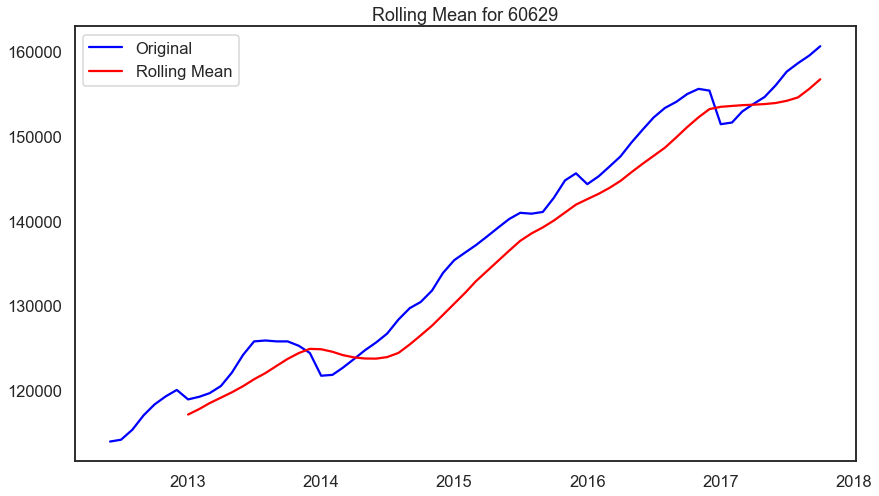

Results of Dickey-Fuller Test:
Test Statistic                 -0.307841
p-value                         0.924386
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


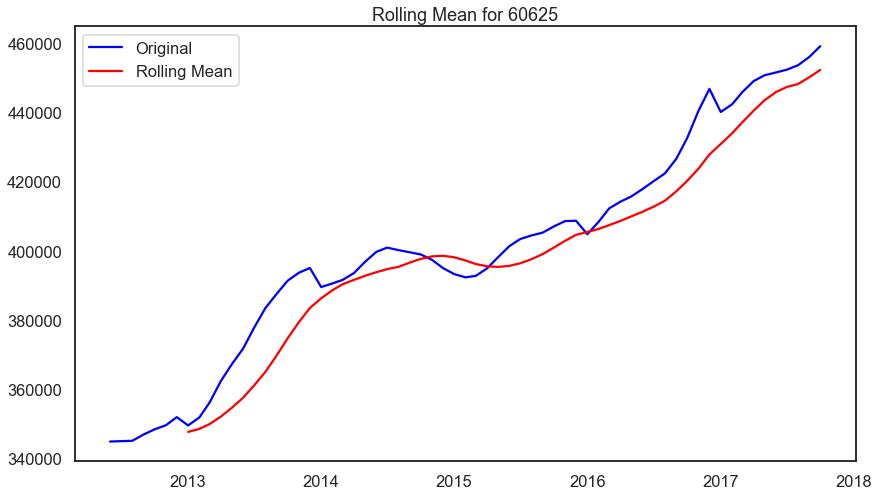

Results of Dickey-Fuller Test:
Test Statistic                 -0.487706
p-value                         0.894393
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


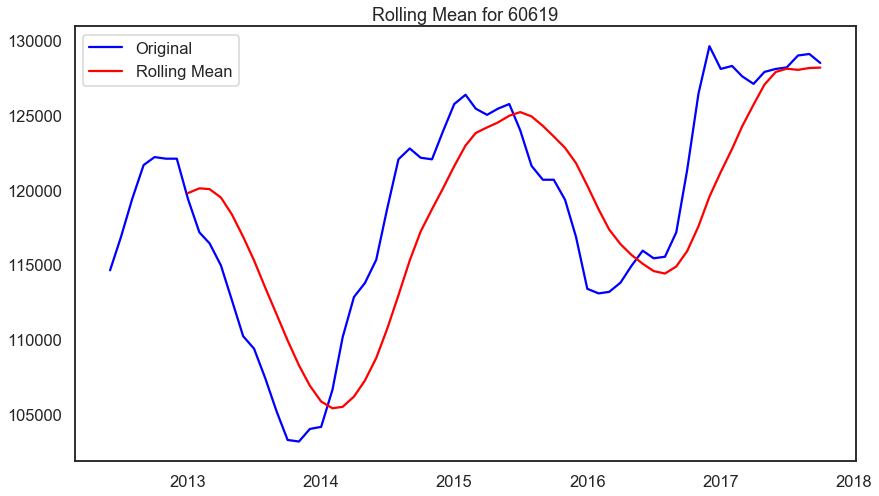

Results of Dickey-Fuller Test:
Test Statistic                 -2.567286
p-value                         0.099949
#Lags Used                      4.000000
Number of Observations Used    60.000000
Critical Value 1%              -3.544369
Critical Value 5%              -2.911073
Critical Value 10%             -2.593190
dtype: float64


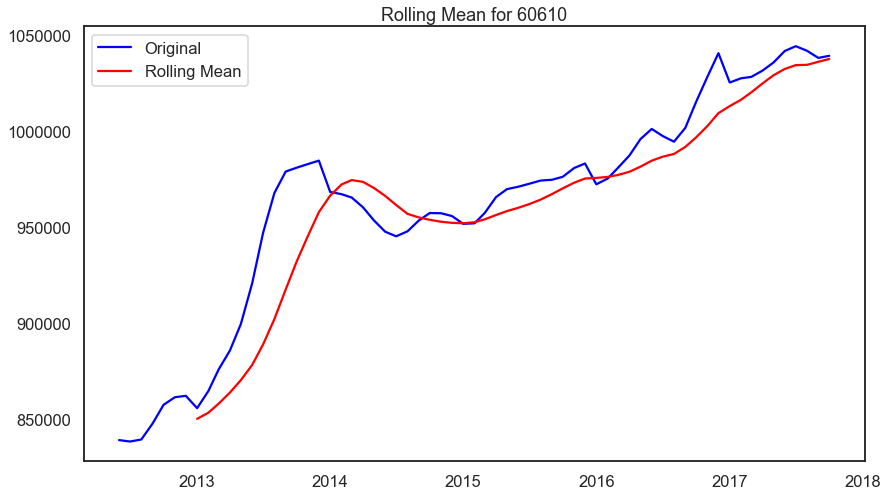

Results of Dickey-Fuller Test:
Test Statistic                 -2.033298
p-value                         0.272167
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


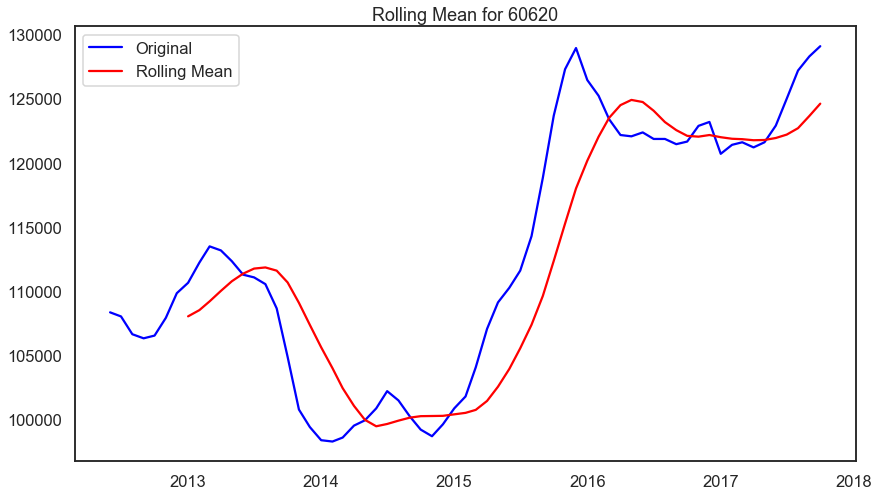

Results of Dickey-Fuller Test:
Test Statistic                 -1.021470
p-value                         0.745353
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


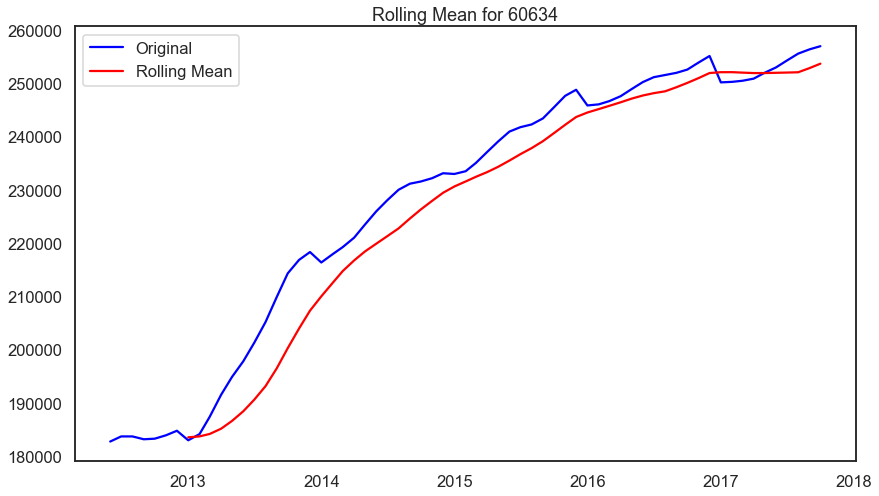

Results of Dickey-Fuller Test:
Test Statistic                 -1.719661
p-value                         0.421012
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


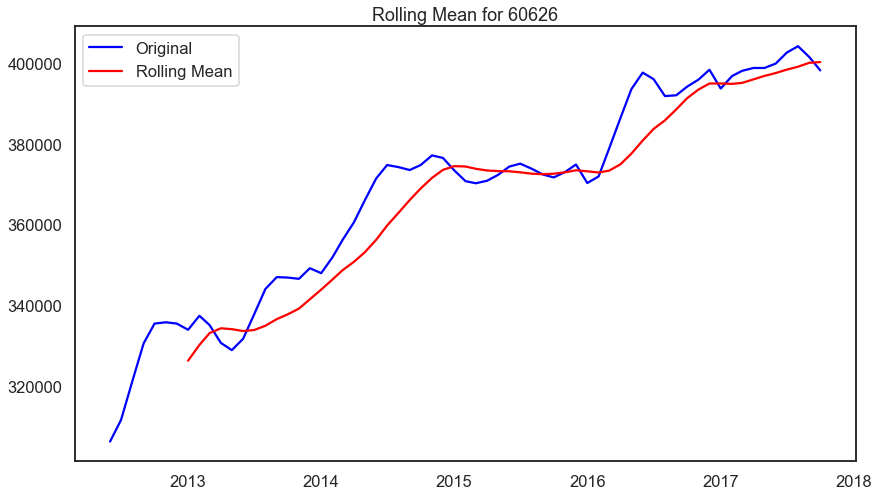

Results of Dickey-Fuller Test:
Test Statistic                 -1.491170
p-value                         0.537875
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


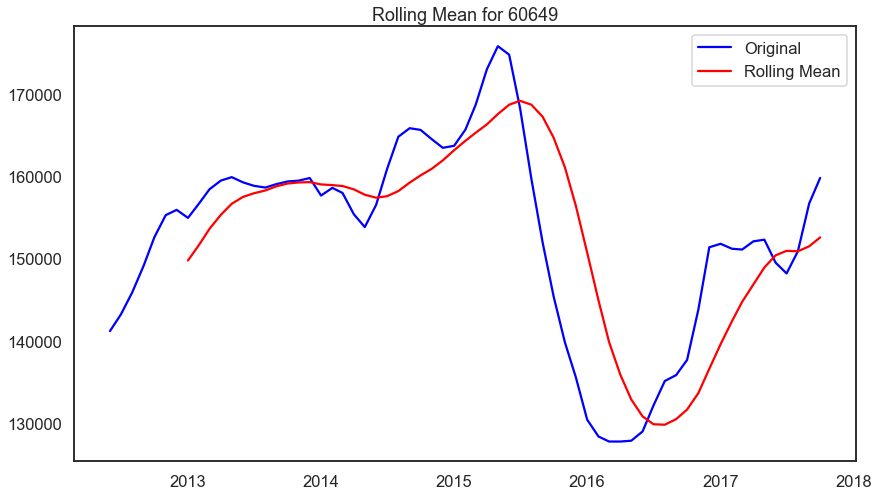

Results of Dickey-Fuller Test:
Test Statistic                 -2.354118
p-value                         0.155107
#Lags Used                      3.000000
Number of Observations Used    61.000000
Critical Value 1%              -3.542413
Critical Value 5%              -2.910236
Critical Value 10%             -2.592745
dtype: float64


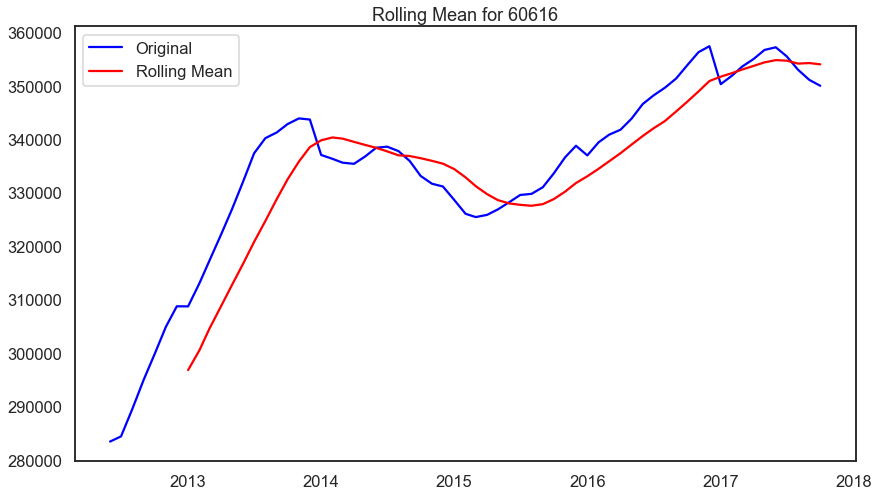

Results of Dickey-Fuller Test:
Test Statistic                 -3.516692
p-value                         0.007569
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


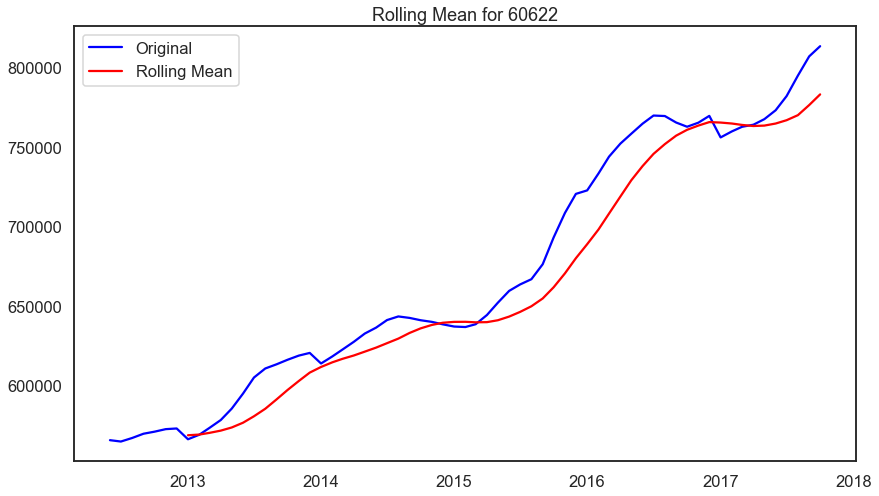

Results of Dickey-Fuller Test:
Test Statistic                  0.200546
p-value                         0.972292
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


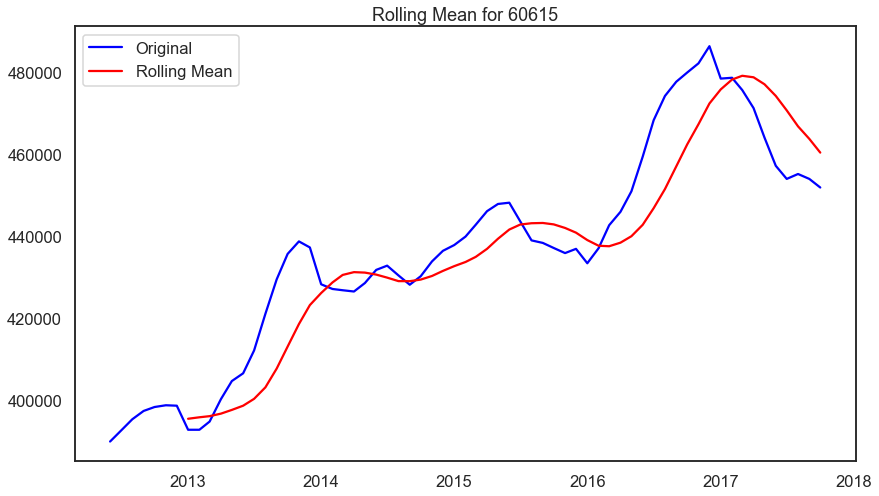

Results of Dickey-Fuller Test:
Test Statistic                 -1.829416
p-value                         0.365958
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


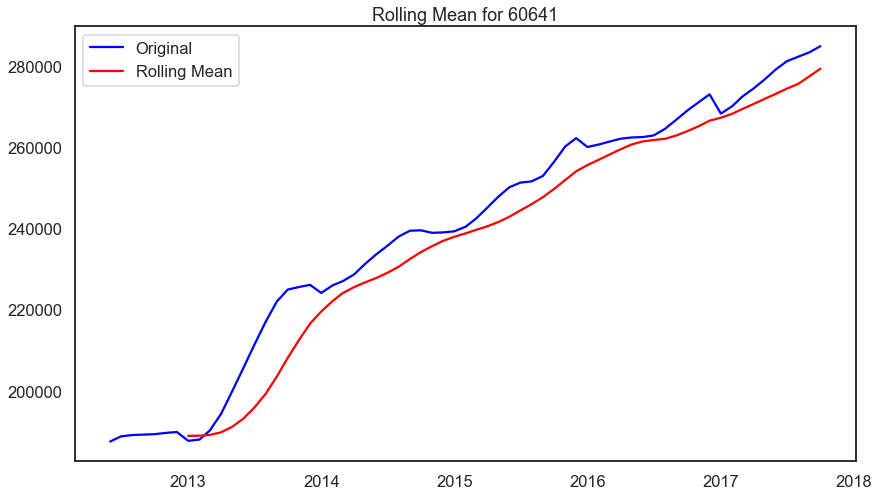

Results of Dickey-Fuller Test:
Test Statistic                 -0.907004
p-value                         0.785657
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


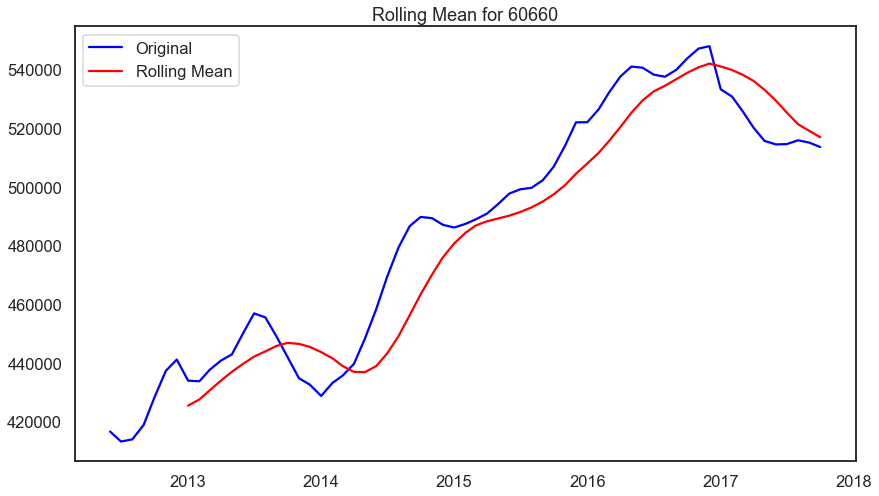

Results of Dickey-Fuller Test:
Test Statistic                 -1.892107
p-value                         0.335783
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


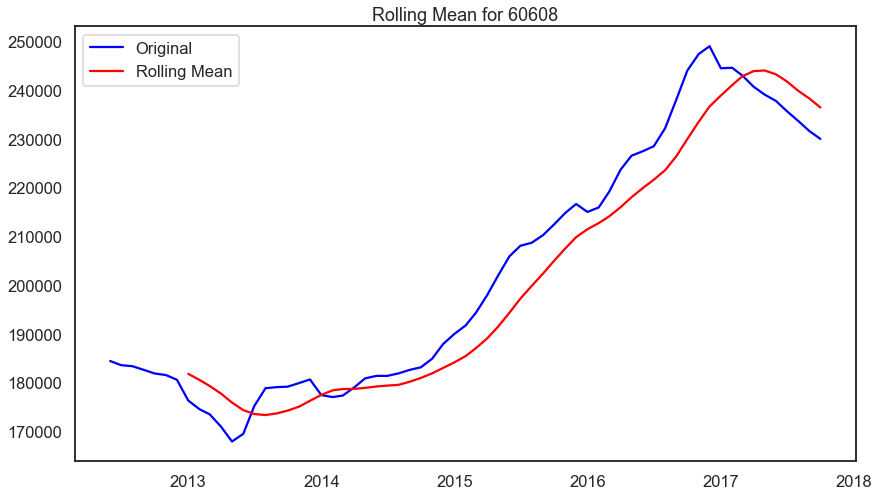

Results of Dickey-Fuller Test:
Test Statistic                 -0.584842
p-value                         0.874370
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


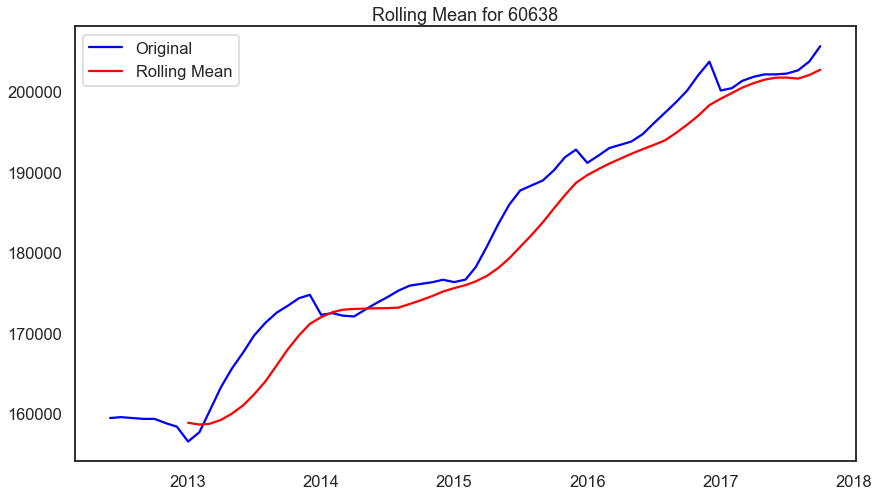

Results of Dickey-Fuller Test:
Test Statistic                 -0.332324
p-value                         0.920800
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


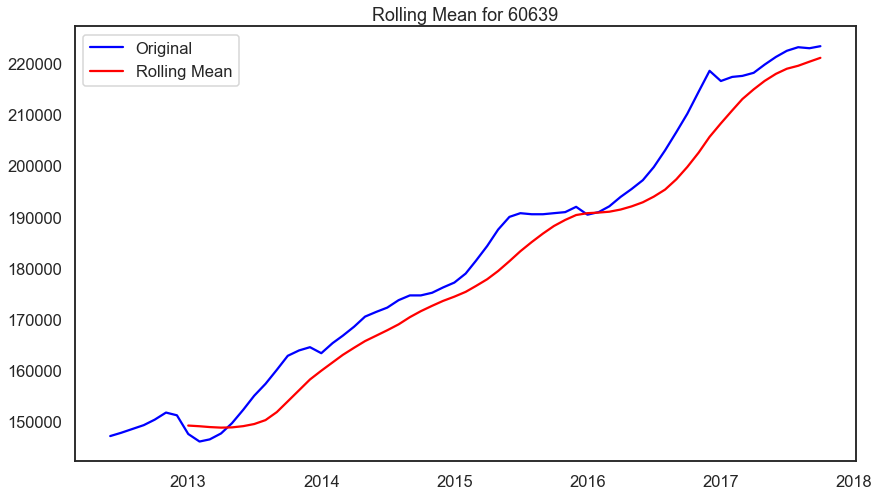

Results of Dickey-Fuller Test:
Test Statistic                 -0.105320
p-value                         0.948906
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


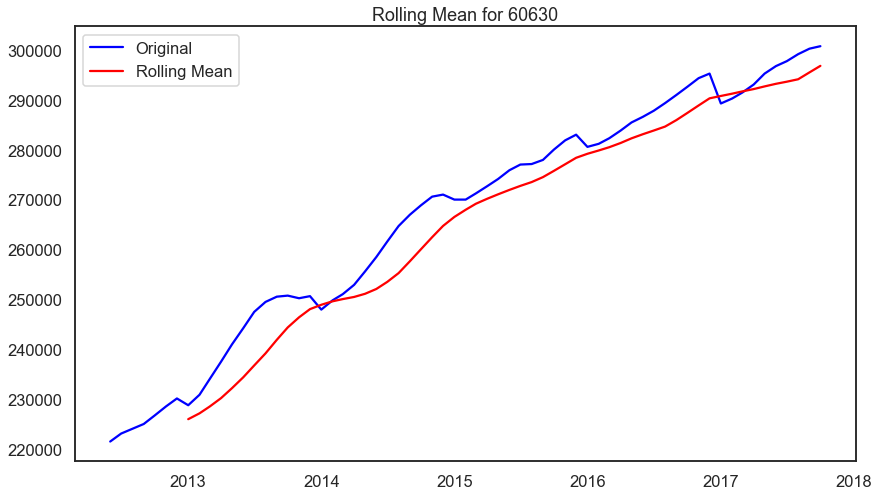

Results of Dickey-Fuller Test:
Test Statistic                 -4.096169
p-value                         0.000983
#Lags Used                     10.000000
Number of Observations Used    54.000000
Critical Value 1%              -3.557709
Critical Value 5%              -2.916770
Critical Value 10%             -2.596222
dtype: float64


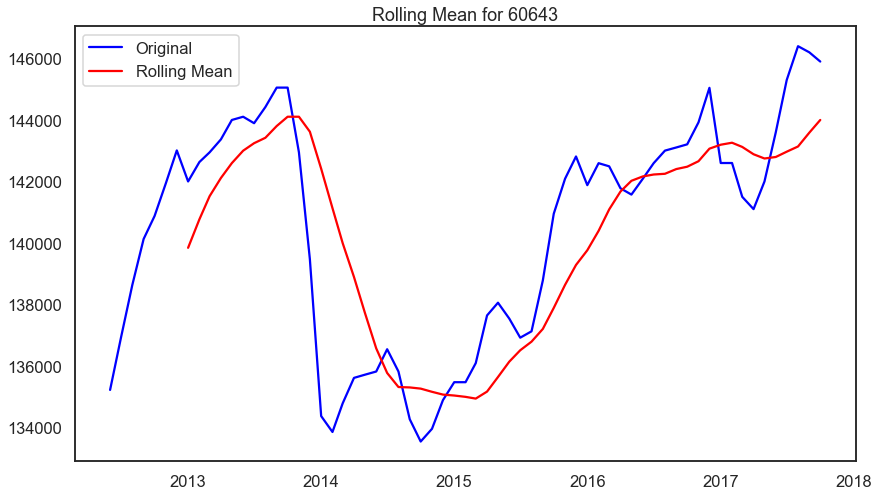

Results of Dickey-Fuller Test:
Test Statistic                 -2.217775
p-value                         0.199857
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


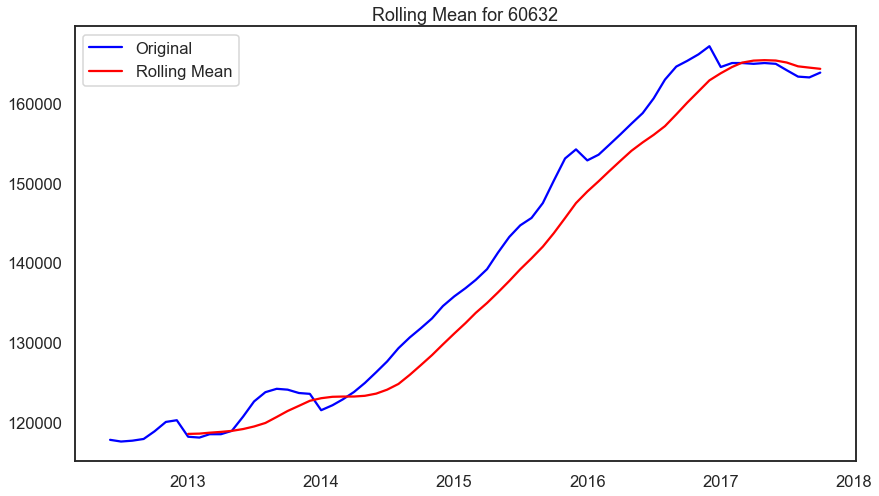

Results of Dickey-Fuller Test:
Test Statistic                 -0.455622
p-value                         0.900389
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


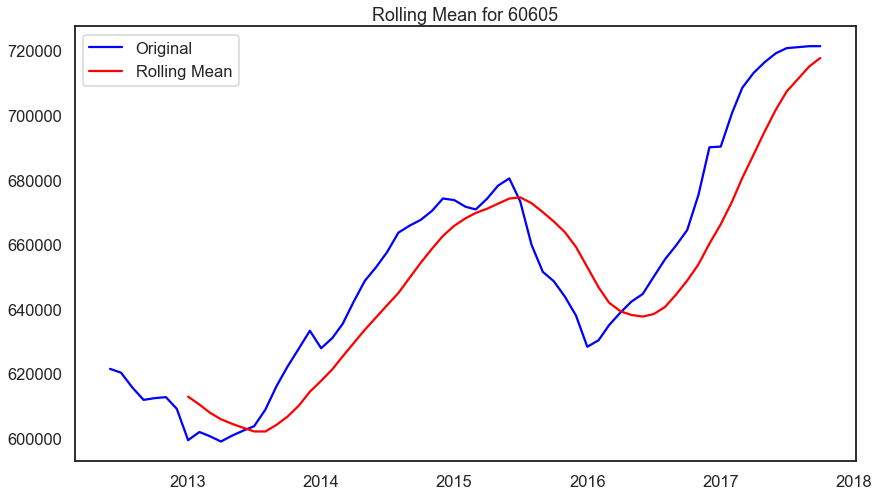

Results of Dickey-Fuller Test:
Test Statistic                 -0.606135
p-value                         0.869590
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


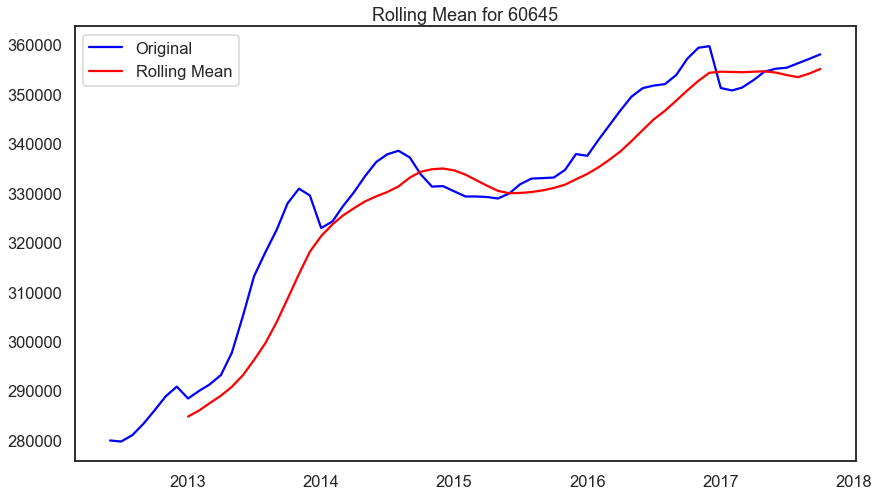

Results of Dickey-Fuller Test:
Test Statistic                 -2.059726
p-value                         0.261014
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


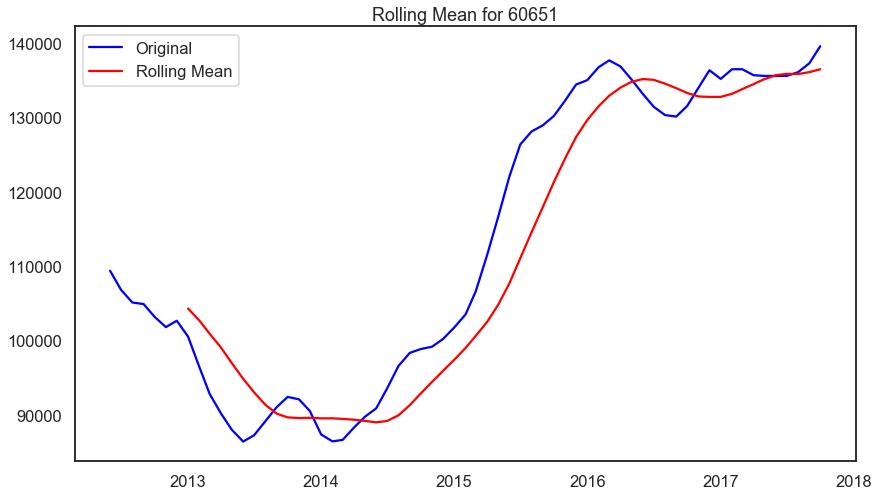

Results of Dickey-Fuller Test:
Test Statistic                 -0.402473
p-value                         0.909685
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


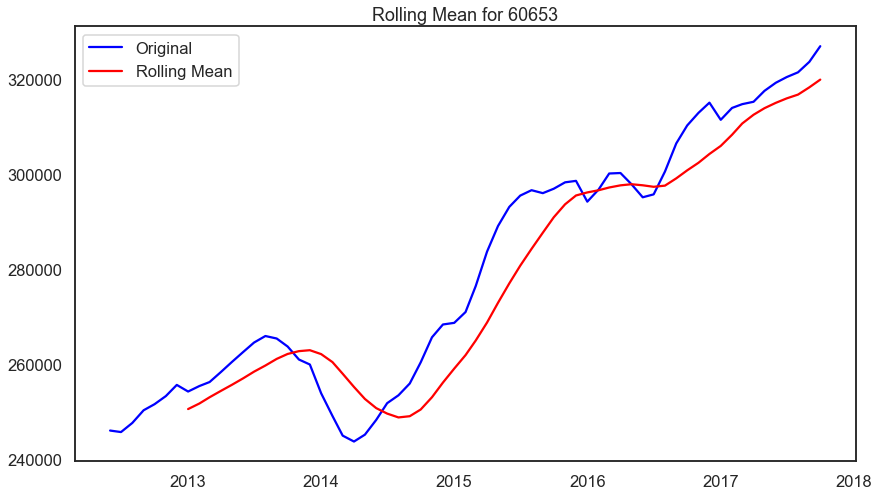

Results of Dickey-Fuller Test:
Test Statistic                 -0.331475
p-value                         0.920927
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


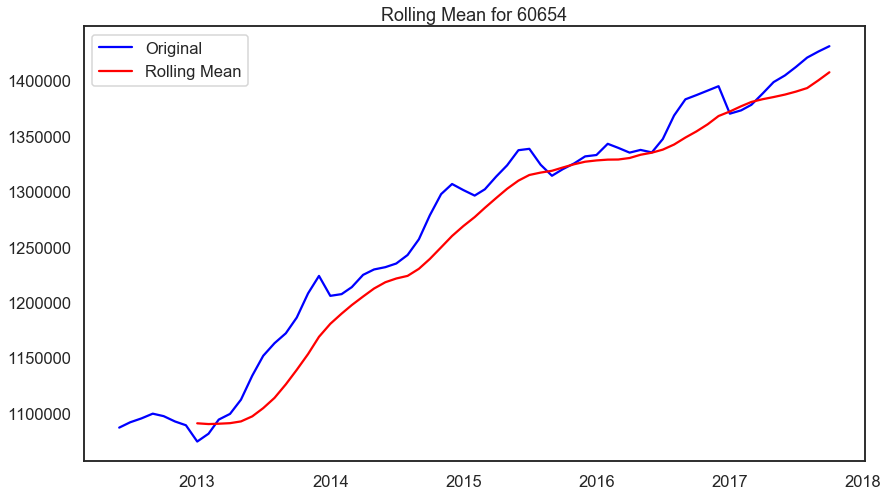

Results of Dickey-Fuller Test:
Test Statistic                 -0.802033
p-value                         0.818524
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


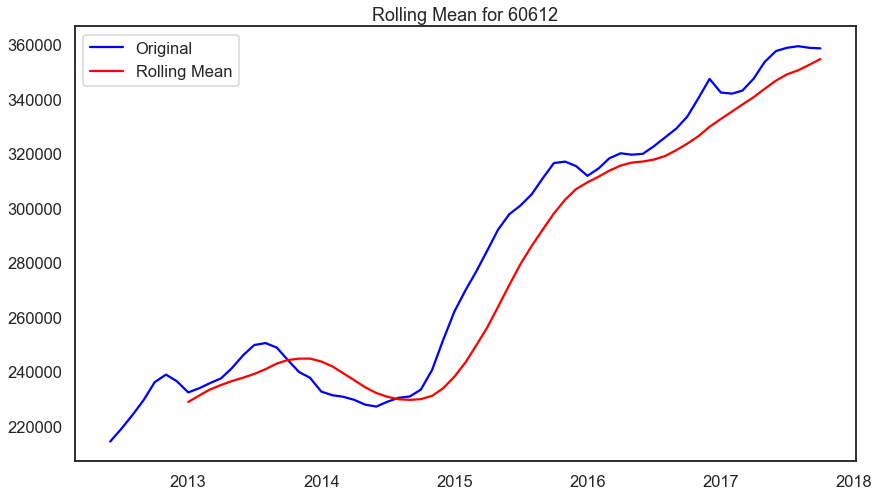

Results of Dickey-Fuller Test:
Test Statistic                 -0.163018
p-value                         0.942789
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


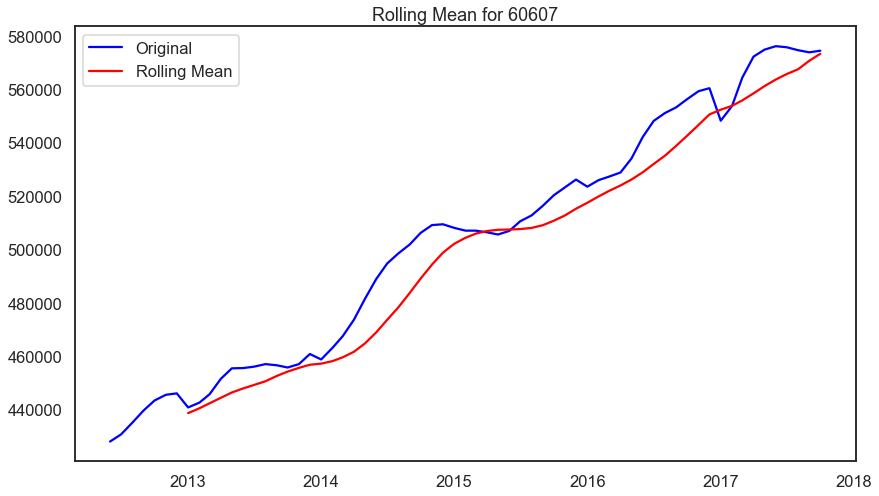

Results of Dickey-Fuller Test:
Test Statistic                 -0.622533
p-value                         0.865809
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


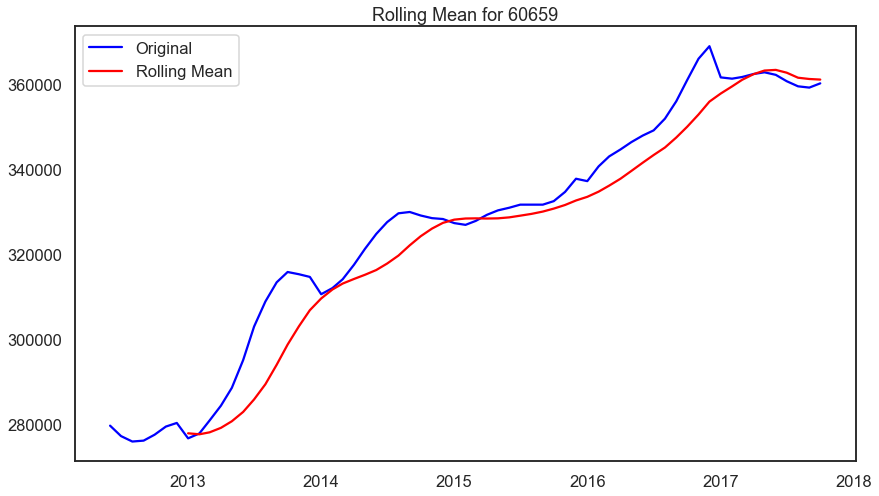

Results of Dickey-Fuller Test:
Test Statistic                 -1.600722
p-value                         0.483231
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


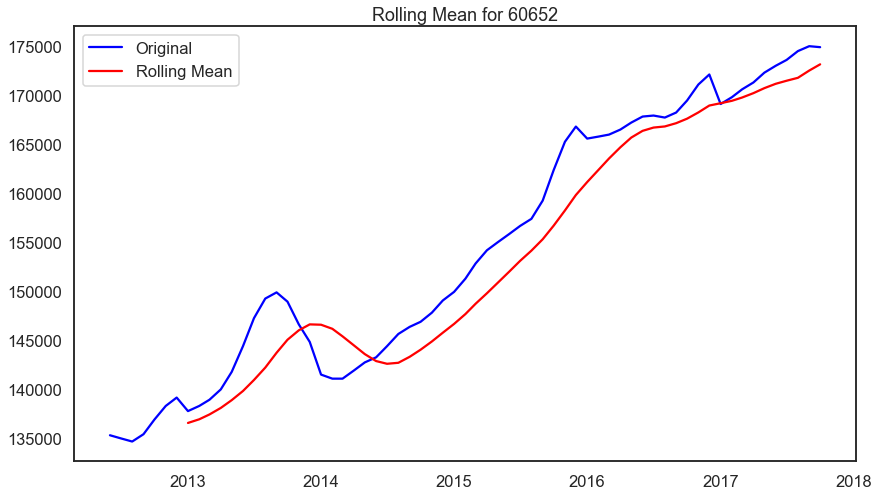

Results of Dickey-Fuller Test:
Test Statistic                 -0.836613
p-value                         0.808130
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


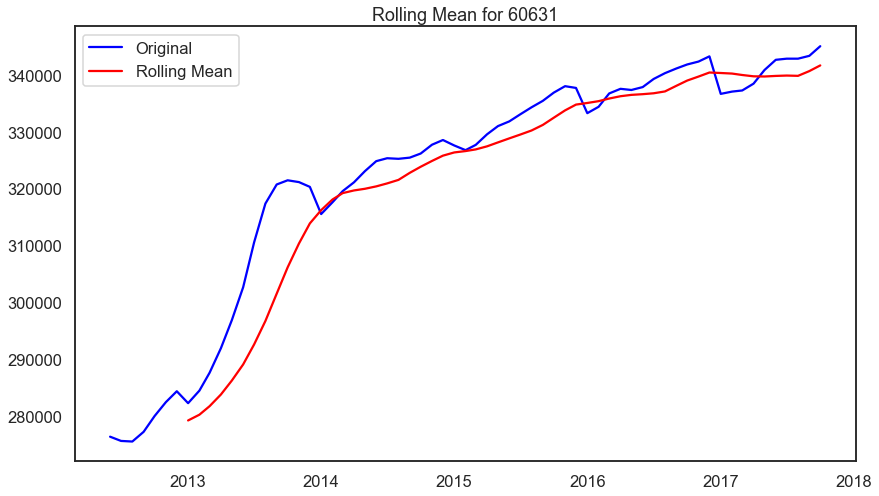

Results of Dickey-Fuller Test:
Test Statistic                 -2.466452
p-value                         0.123852
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


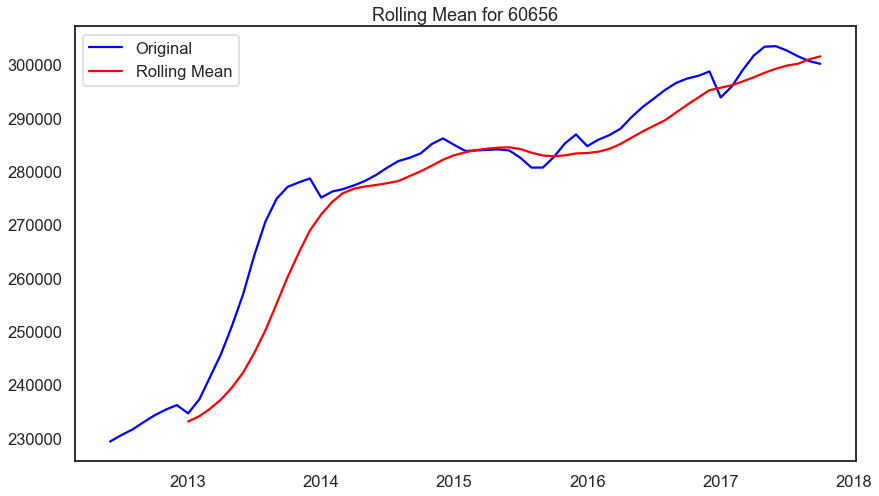

Results of Dickey-Fuller Test:
Test Statistic                 -2.260267
p-value                         0.185103
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


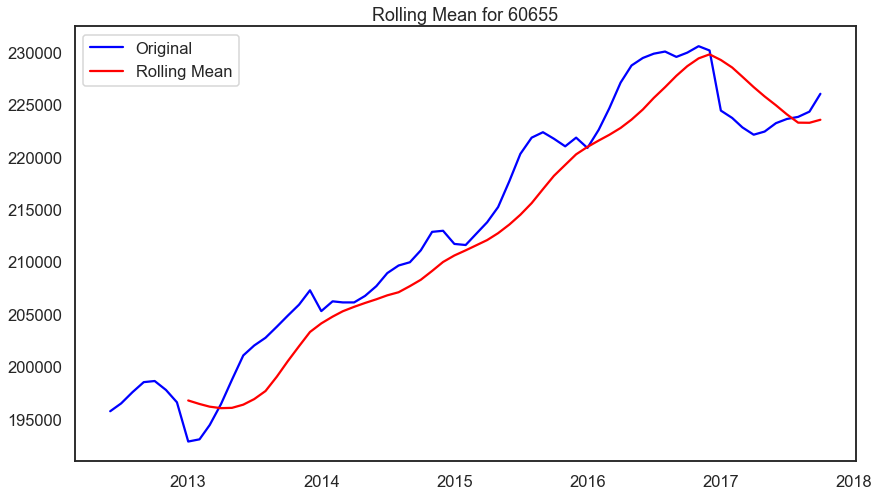

Results of Dickey-Fuller Test:
Test Statistic                 -1.036080
p-value                         0.739879
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


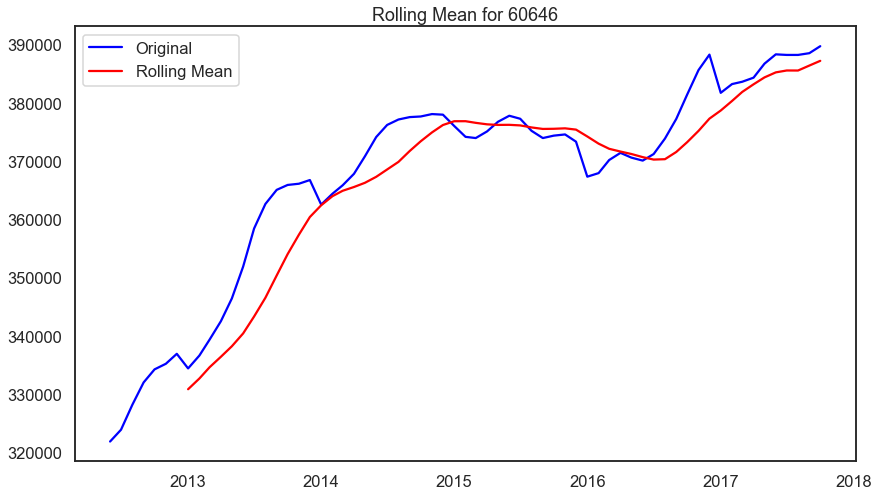

Results of Dickey-Fuller Test:
Test Statistic                 -2.457788
p-value                         0.126086
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


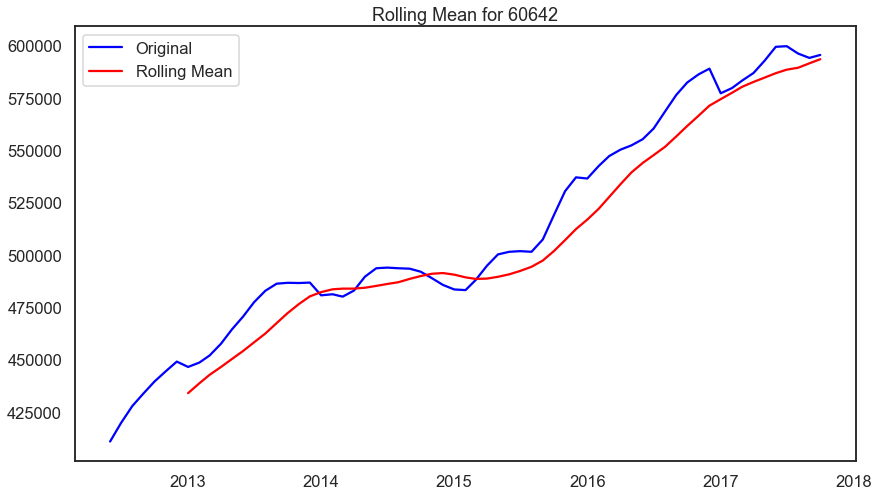

Results of Dickey-Fuller Test:
Test Statistic                 -0.718584
p-value                         0.841877
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


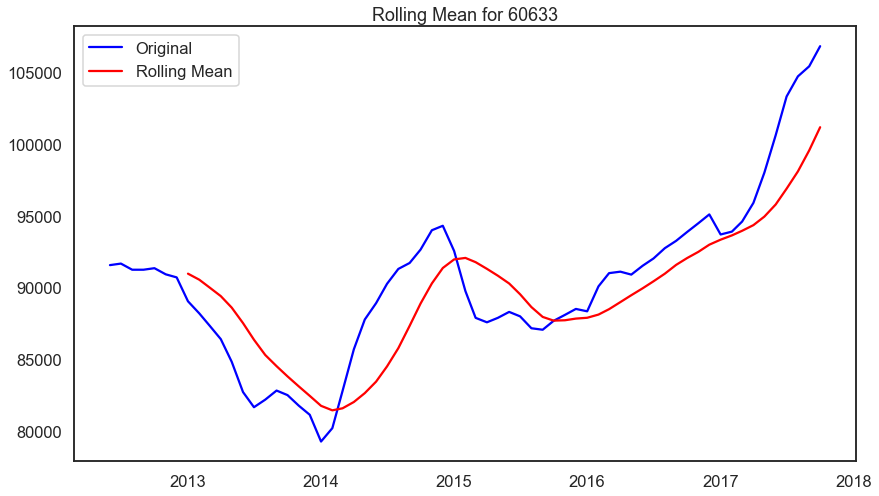

Results of Dickey-Fuller Test:
Test Statistic                  0.086287
p-value                         0.965112
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [32]:
[stationarity_check(chicago_df_defl_train,x, plot_std=False) for x in list(chicago_df_defl_train.columns)]

## Removing Trends

### Function to test what transformation produces the most stationary line

In [33]:
def detrend_test(TS, alpha=0.05, maxlag=4):
    '''Selecting the best method for detrending timeseries based on lowest p-value of the augmented Dickey-Fuller.
       TS: timeseries dataframe
       alpha: alpha value for Dickey-Fuller '''
    
    new_TS = pd.DataFrame()
    
    plist = []  
    plist_zips = []
    
    # Keep track of which zipcodes require a log 1st difference transformation
    log_1diff = []
    
    for column in list(TS.columns):  #go through each zipcode in the DF
        p_values = []
        
        # First Difference
            # find the first difference for each row in the zipcode
        data_1diff = TS[column].diff(periods=1) 
            # perform Dickey Fuller test on first difference
        dftest = adfuller(data_1diff.dropna(),maxlag=maxlag)
            # Place first 4 outputs of the Dickey Fuller test in a dataframe and label the outputs appropriately in the index
        dfoutput_1diff = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput_1diff['Critical Values {}'.format(key)] = value
            # Add p-value of first difference Dickey-Fuller p-value list
        p_values.append(dfoutput_1diff[1])
    
        # Log First Difference
            # find the log first difference for each row in the zipcode
        data_log_1diff = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            # perform Dickey Fuller test on first difference
        dftest = adfuller(data_log_1diff.dropna(),maxlag=maxlag)
            # Take first 4 outputs of the Dickey Fuller test and label the outputs appropriately
        dfoutput_log_1diff = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput_log_1diff['Critical Values {}'.format(key)] = value
            # Add p-value of log first difference Dickey-Fuller p-value list
        p_values.append(dfoutput_log_1diff[1])

        # If first difference performed better, print the Dickey-Fuller results and plot
        if np.argmin(p_values)==0:
            data_1diff.plot(figsize=(20,6))
            plt.title('{} First Difference'.format(column))
            plt.show();
            print(dfoutput_1diff)
            new_TS[column]=data_1diff
        
        # If log first difference performed better, print the Dickey-Fuller results and plot
        elif np.argmin(p_values)==1:
            log_1diff.append(column)
            data_log_1diff.plot(figsize=(20,6))
            plt.title('{} Log First Difference'.format(column))
            plt.show();
            print(dfoutput_log_1diff)
            new_TS[column]=data_log_1diff
        
        # Add the smallest p value from tests, to the plist
        plist.append(min(p_values))
        # Add zipcodes with high p-values to plist_zips
        if min(p_values)>alpha:
            plist_zips.append(column)
        
    print('\nNumber of p-values above alpha of {}:'.format(alpha),(np.array(plist)>alpha).sum())
    print('\nZipcodes with p-values above alpha of {}'.format(alpha), plist_zips)
    print('\nZipcodes requiring log first difference transformation: {}'.format(log_1diff))
    return new_TS, log_1diff

#### Use Function on training data to detrend

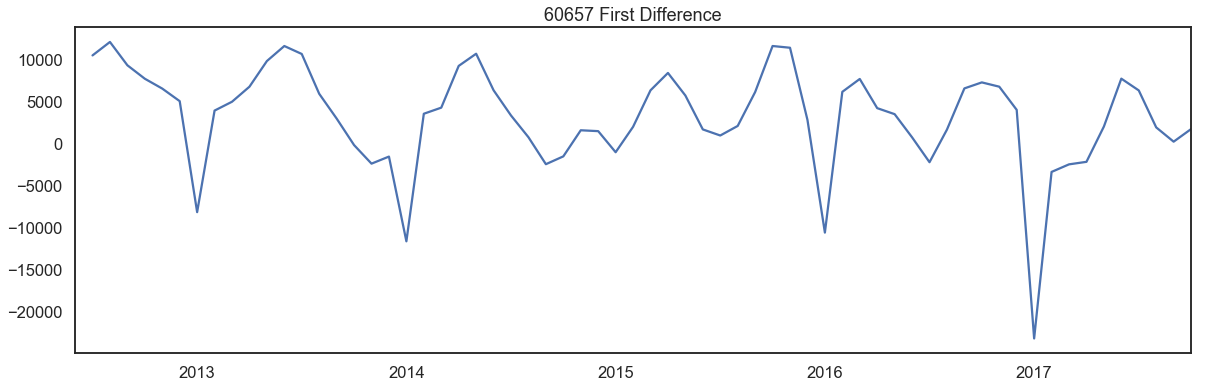

Test Statistic                 -5.168054
p-value                         0.000010
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


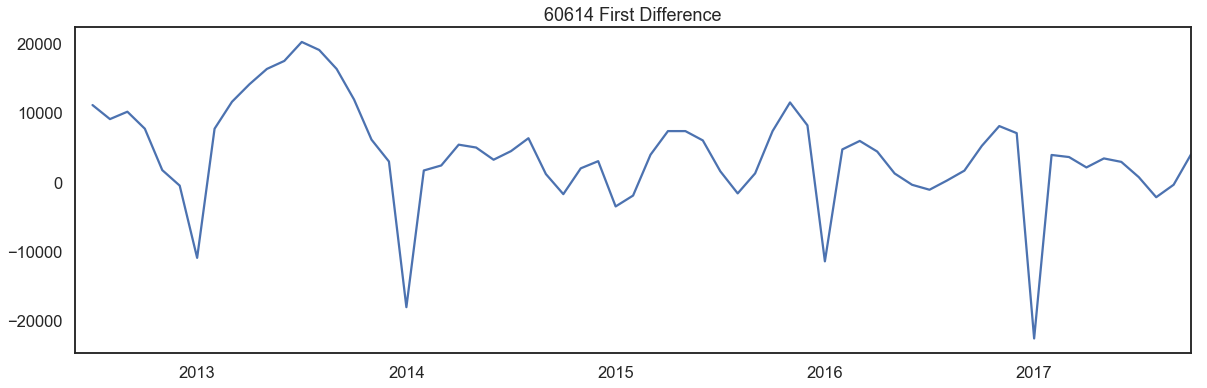

Test Statistic                 -5.029957
p-value                         0.000019
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


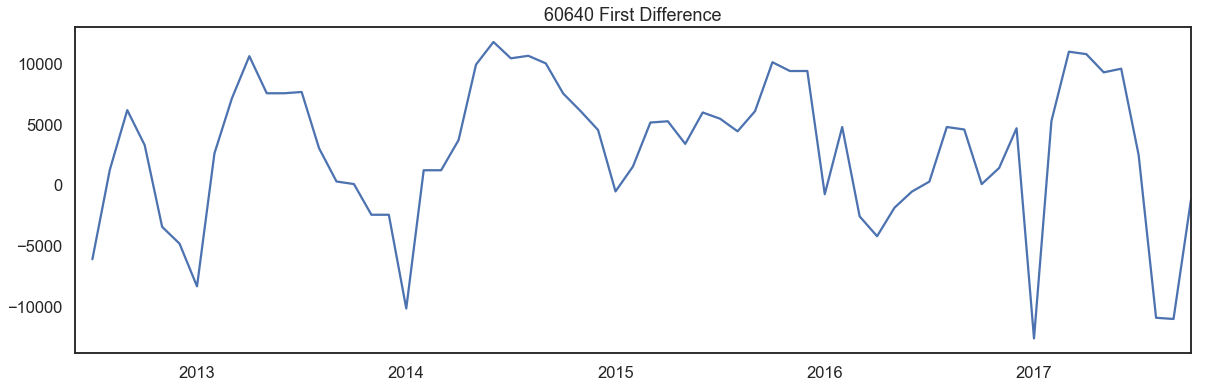

Test Statistic                 -4.159778
p-value                         0.000770
#Lags Used                      3.000000
Number of Observations Used    60.000000
Critical Values 1%             -3.544369
Critical Values 5%             -2.911073
Critical Values 10%            -2.593190
dtype: float64


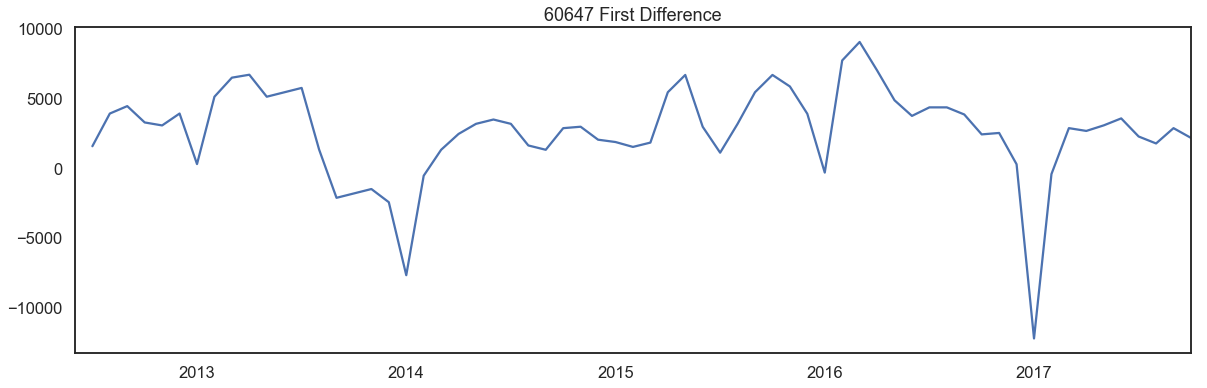

Test Statistic                 -4.232260
p-value                         0.000581
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


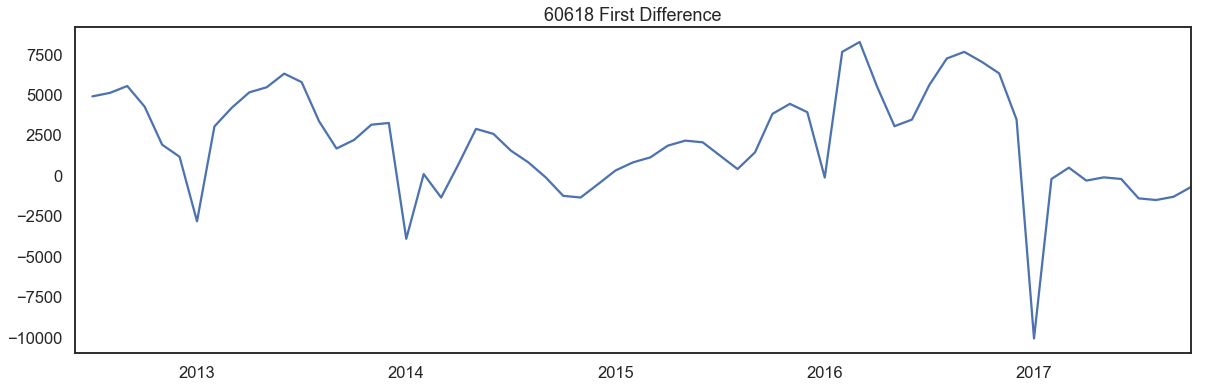

Test Statistic                 -4.090841
p-value                         0.001003
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


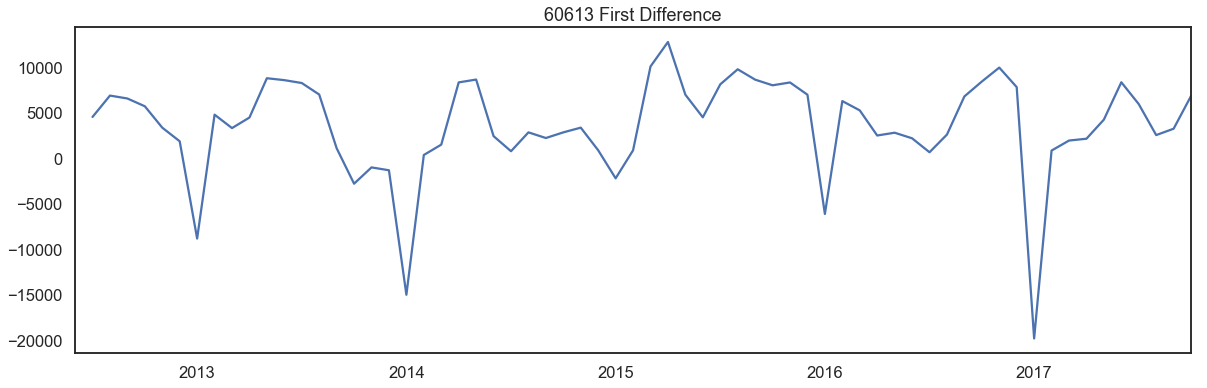

Test Statistic                -5.740825e+00
p-value                        6.281571e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.300000e+01
Critical Values 1%            -3.538695e+00
Critical Values 5%            -2.908645e+00
Critical Values 10%           -2.591897e+00
dtype: float64


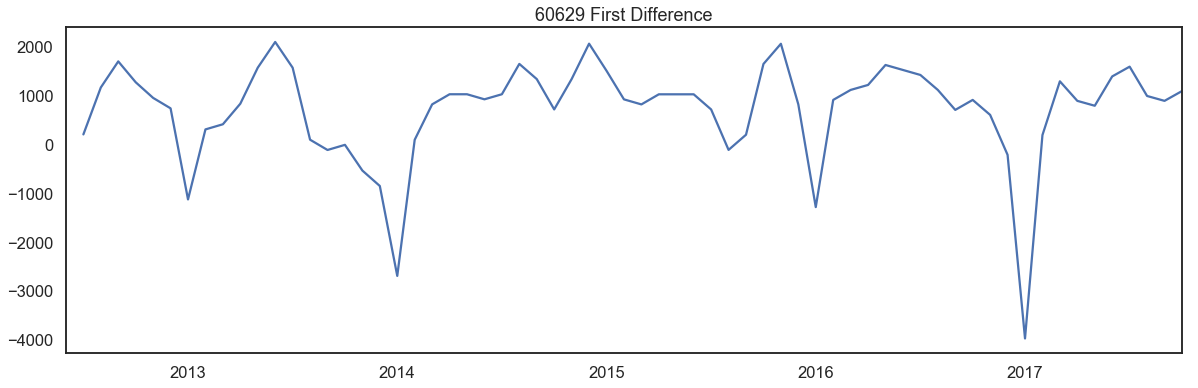

Test Statistic                 -4.873208
p-value                         0.000039
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


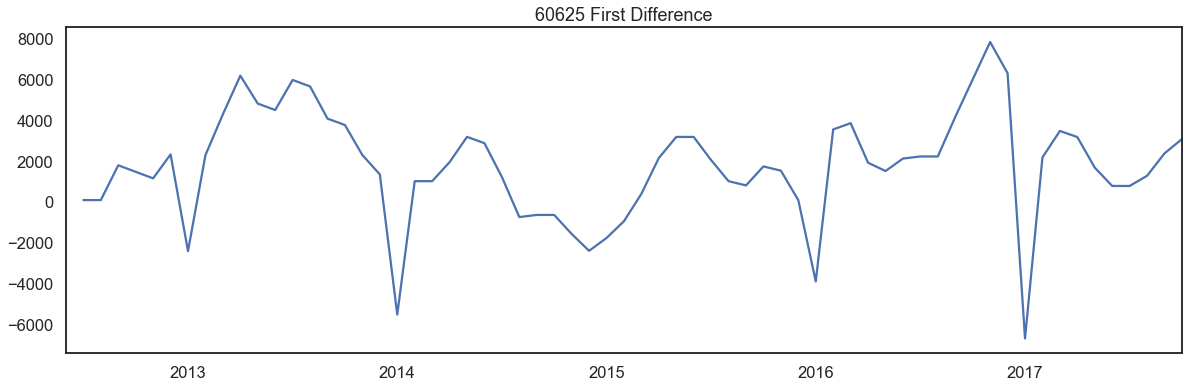

Test Statistic                 -5.052326
p-value                         0.000017
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


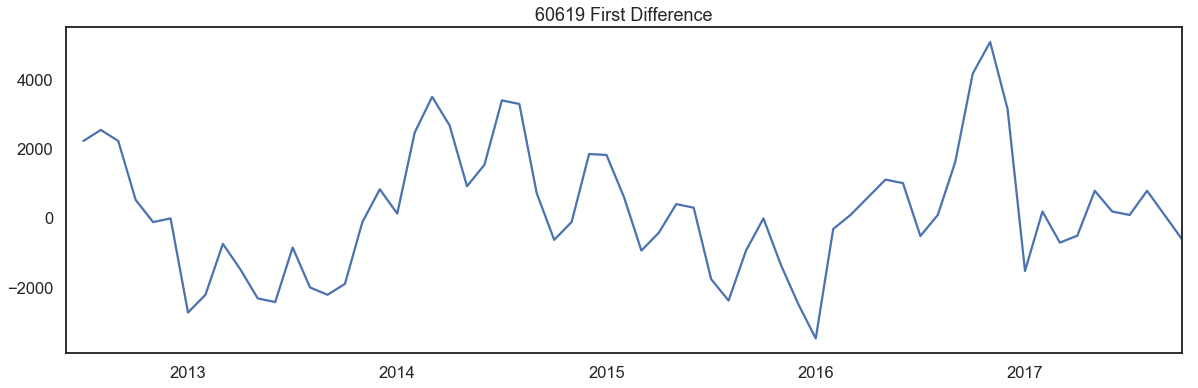

Test Statistic                 -2.981507
p-value                         0.036658
#Lags Used                      2.000000
Number of Observations Used    61.000000
Critical Values 1%             -3.542413
Critical Values 5%             -2.910236
Critical Values 10%            -2.592745
dtype: float64


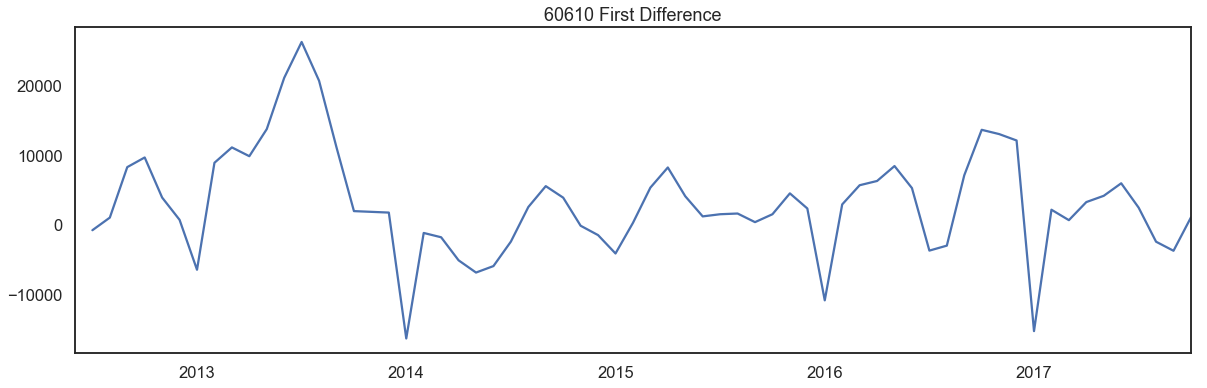

Test Statistic                 -4.177389
p-value                         0.000719
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


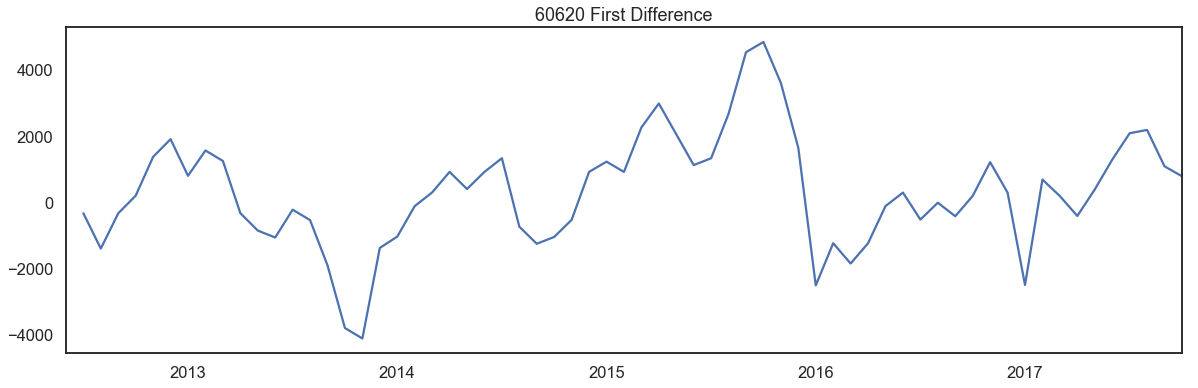

Test Statistic                 -3.602245
p-value                         0.005718
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


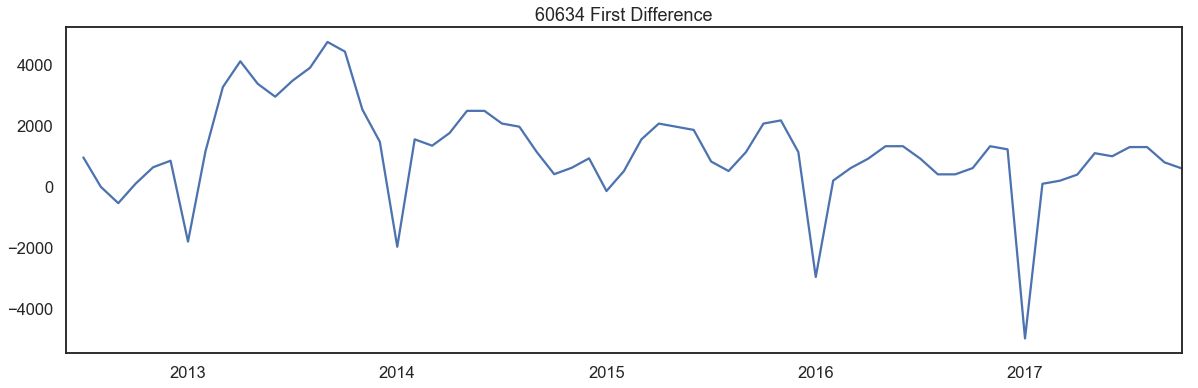

Test Statistic                 -4.470350
p-value                         0.000222
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


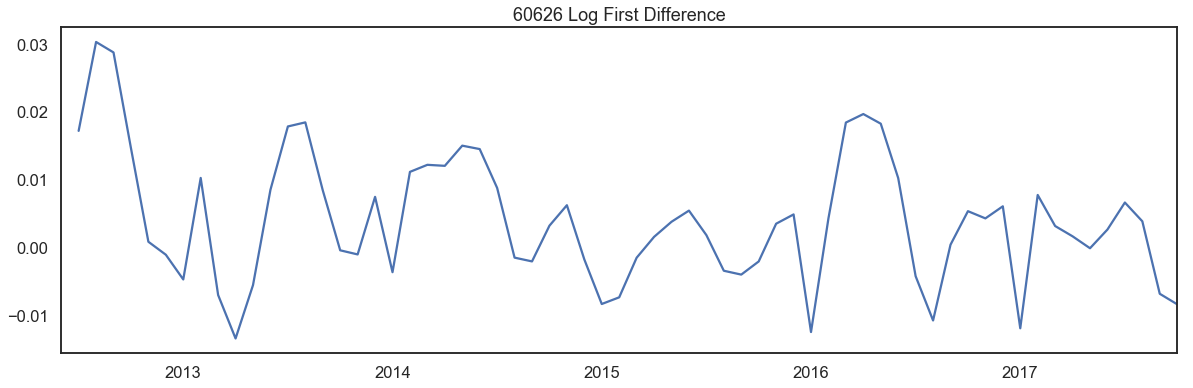

Test Statistic                 -5.333934
p-value                         0.000005
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


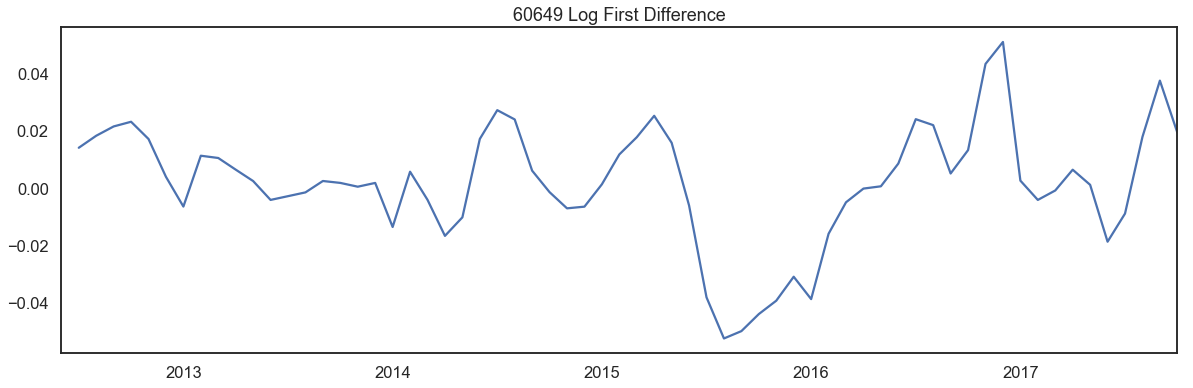

Test Statistic                 -3.052859
p-value                         0.030244
#Lags Used                      4.000000
Number of Observations Used    59.000000
Critical Values 1%             -3.546395
Critical Values 5%             -2.911939
Critical Values 10%            -2.593652
dtype: float64


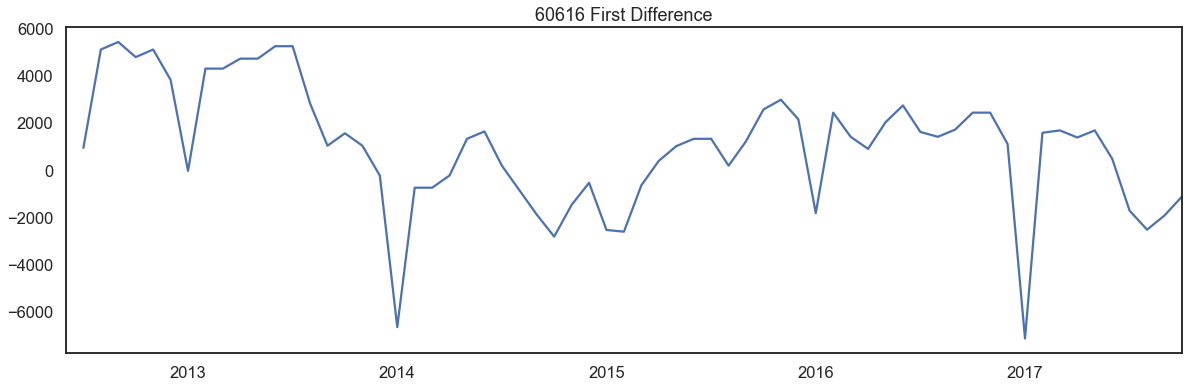

Test Statistic                 -3.989012
p-value                         0.001469
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


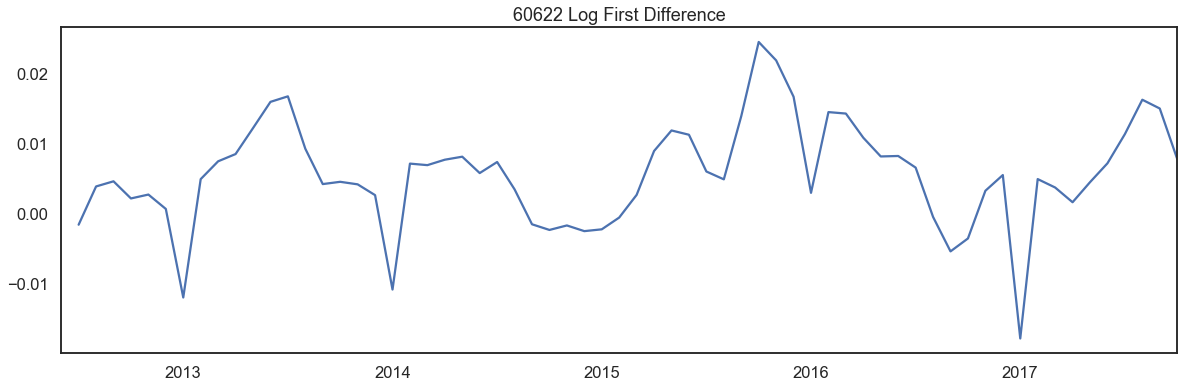

Test Statistic                 -4.262124
p-value                         0.000516
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


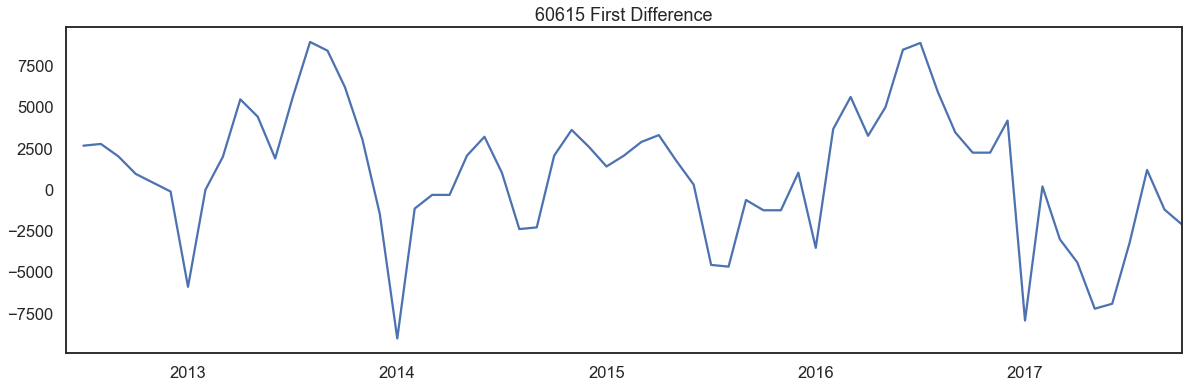

Test Statistic                 -3.721308
p-value                         0.003823
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


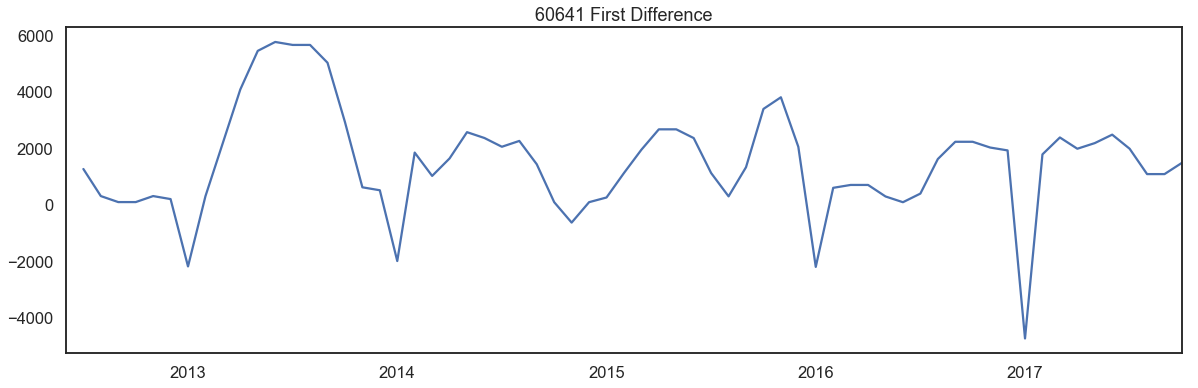

Test Statistic                 -4.088015
p-value                         0.001014
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


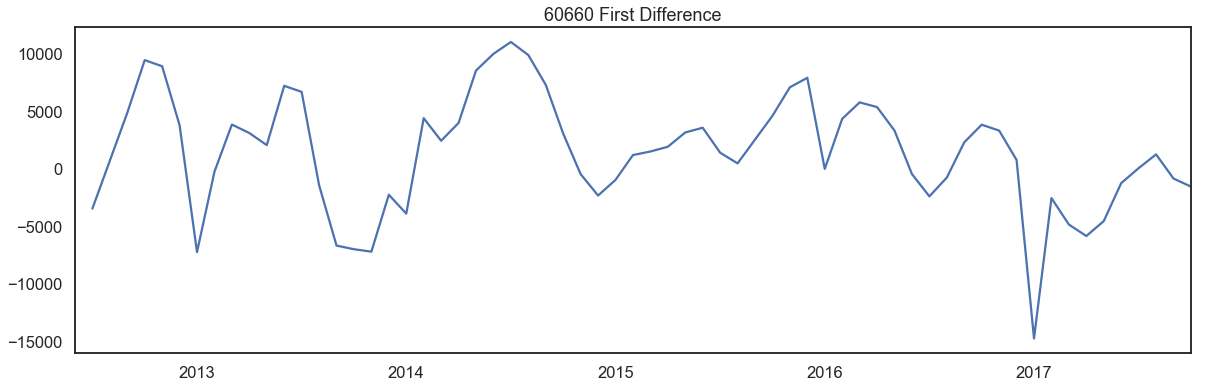

Test Statistic                 -3.782959
p-value                         0.003087
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


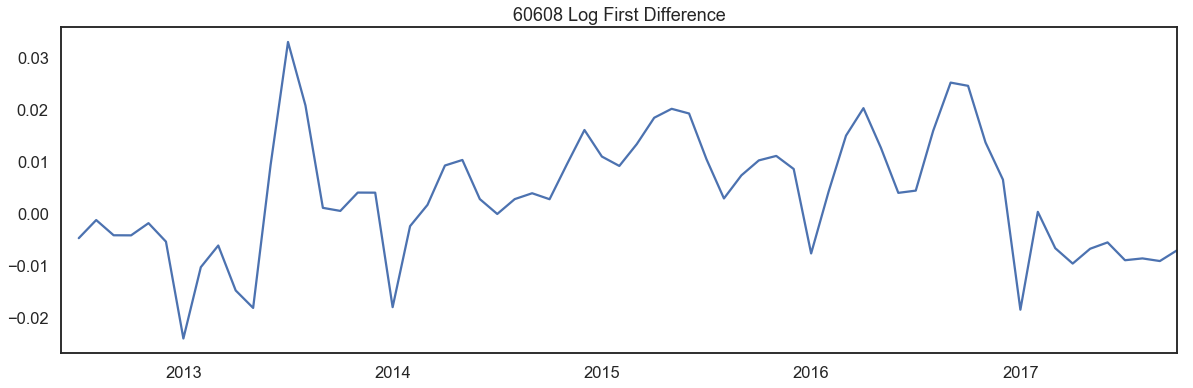

Test Statistic                 -3.949126
p-value                         0.001702
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


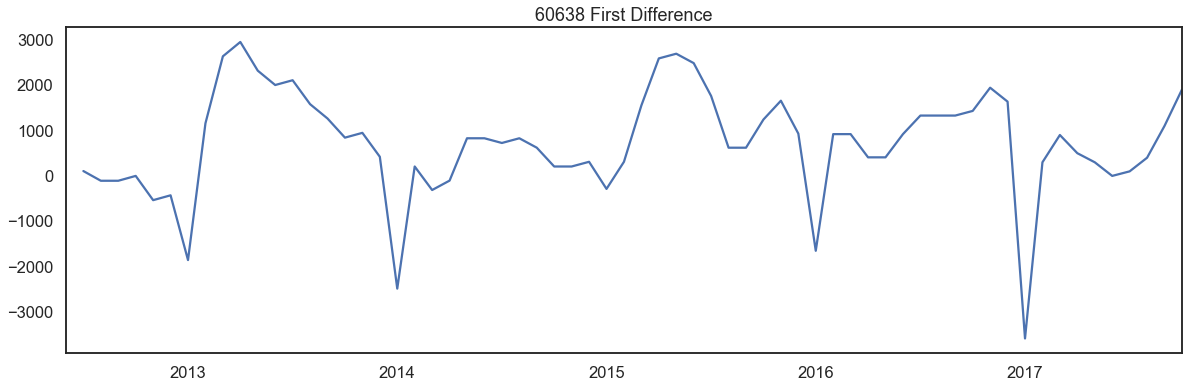

Test Statistic                 -4.837841
p-value                         0.000046
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


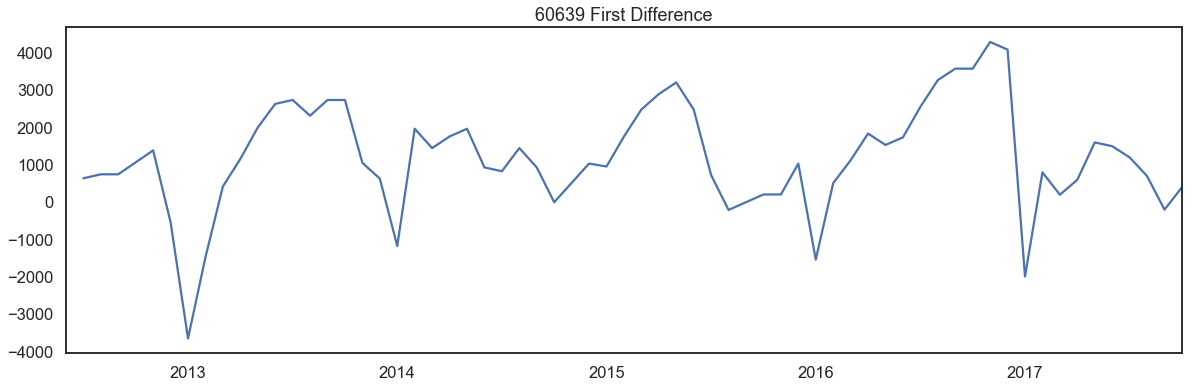

Test Statistic                 -4.063731
p-value                         0.001111
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


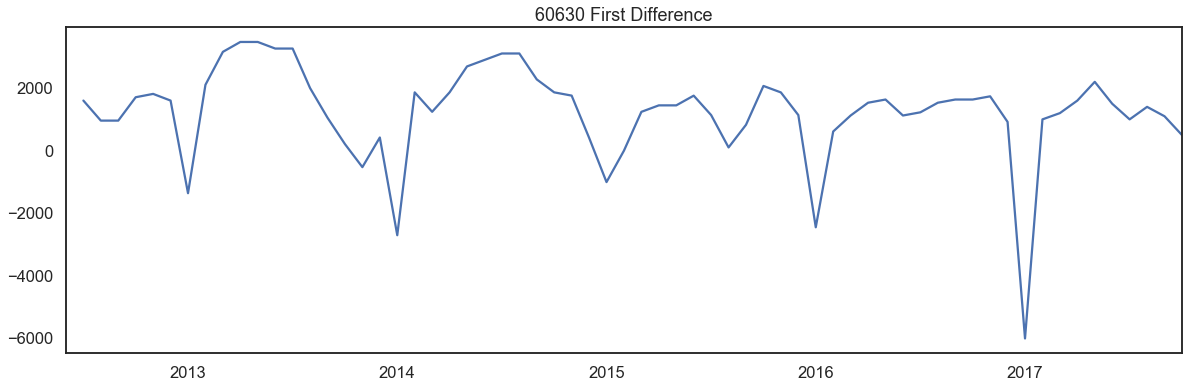

Test Statistic                 -5.528155
p-value                         0.000002
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


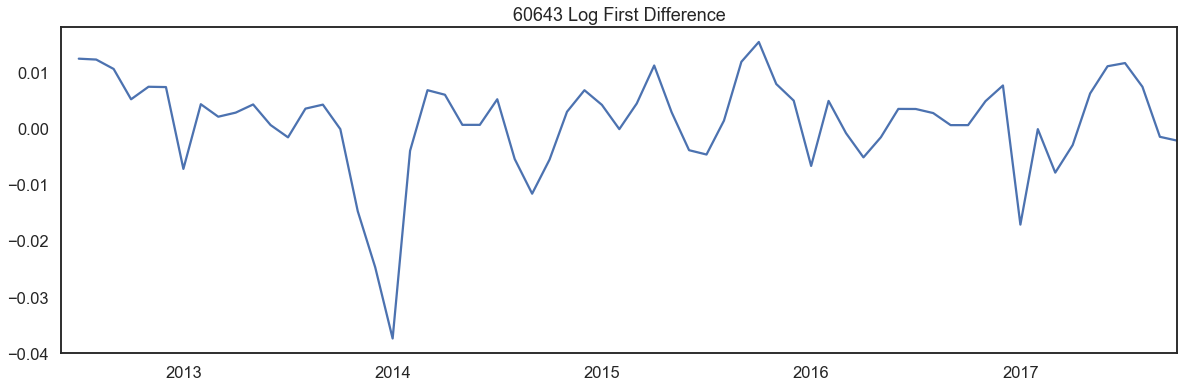

Test Statistic                 -4.724760
p-value                         0.000076
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


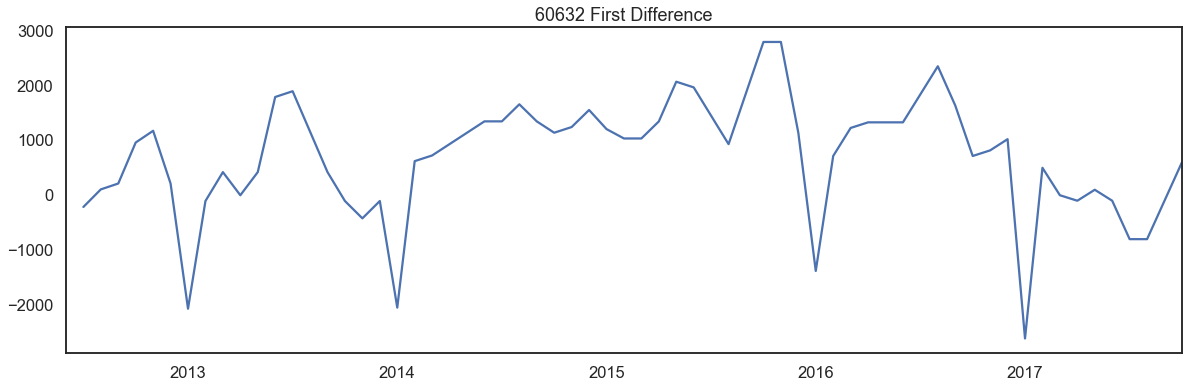

Test Statistic                 -4.484423
p-value                         0.000210
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


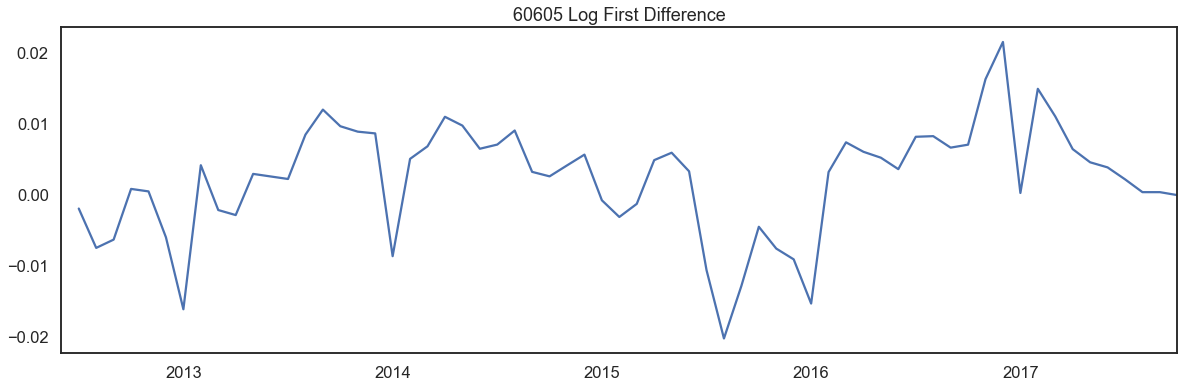

Test Statistic                 -3.938745
p-value                         0.001768
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


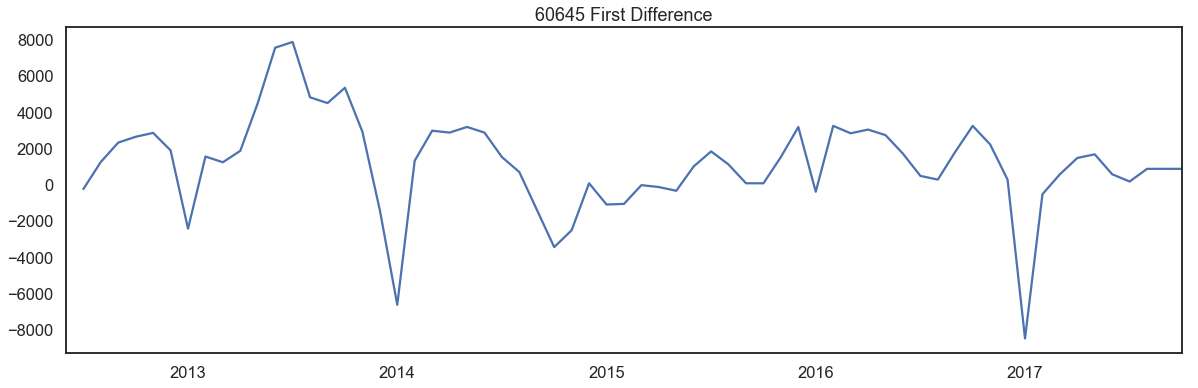

Test Statistic                 -4.287375
p-value                         0.000467
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


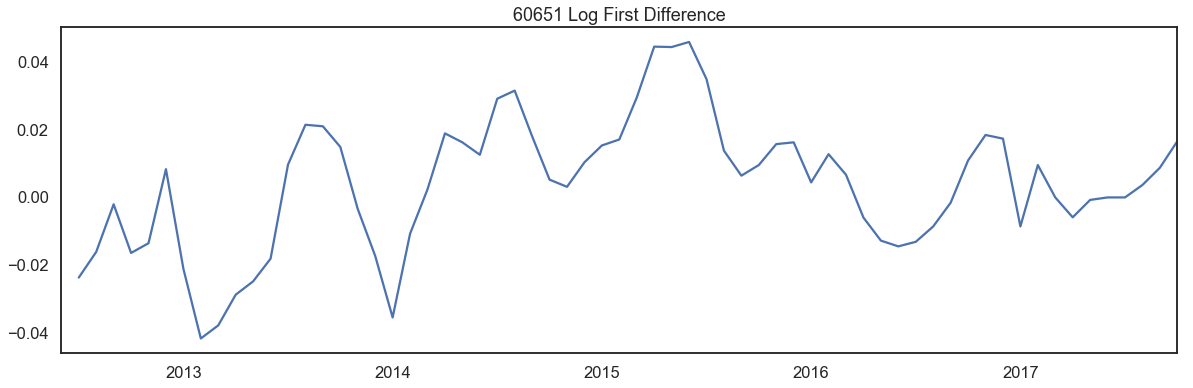

Test Statistic                 -3.311915
p-value                         0.014354
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


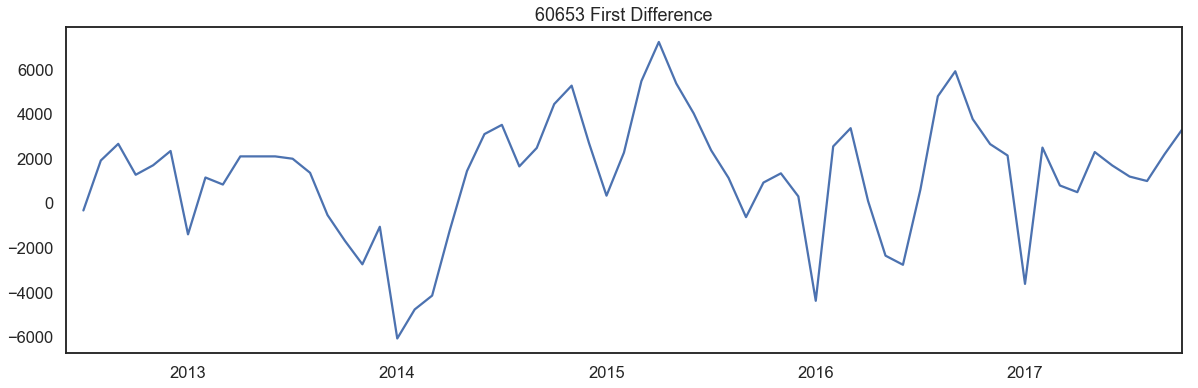

Test Statistic                 -3.823292
p-value                         0.002678
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


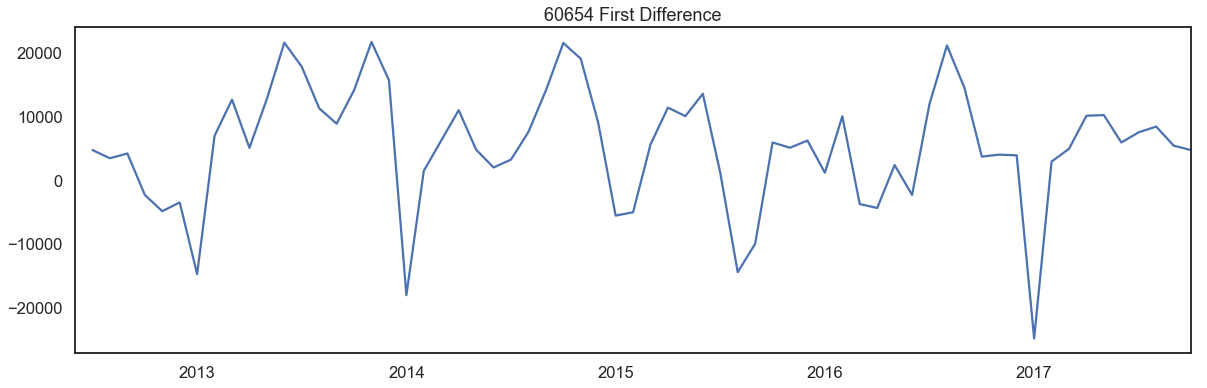

Test Statistic                 -5.085669
p-value                         0.000015
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


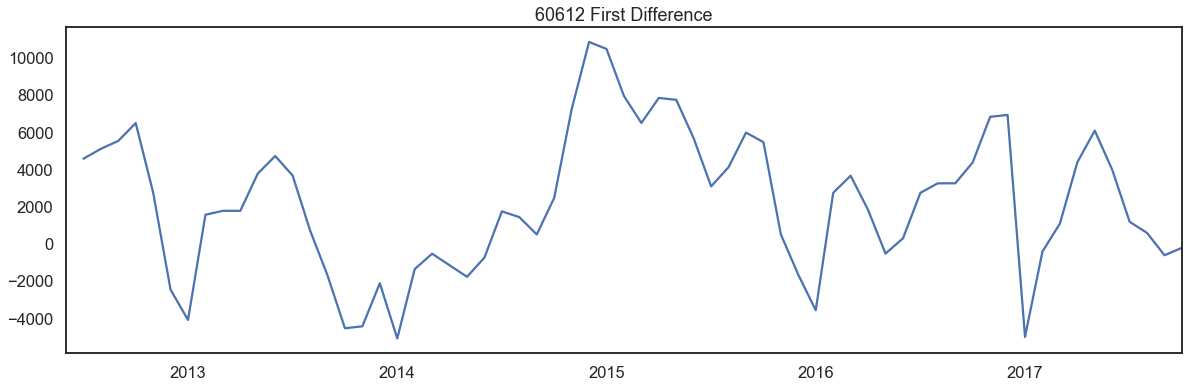

Test Statistic                 -3.737266
p-value                         0.003618
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


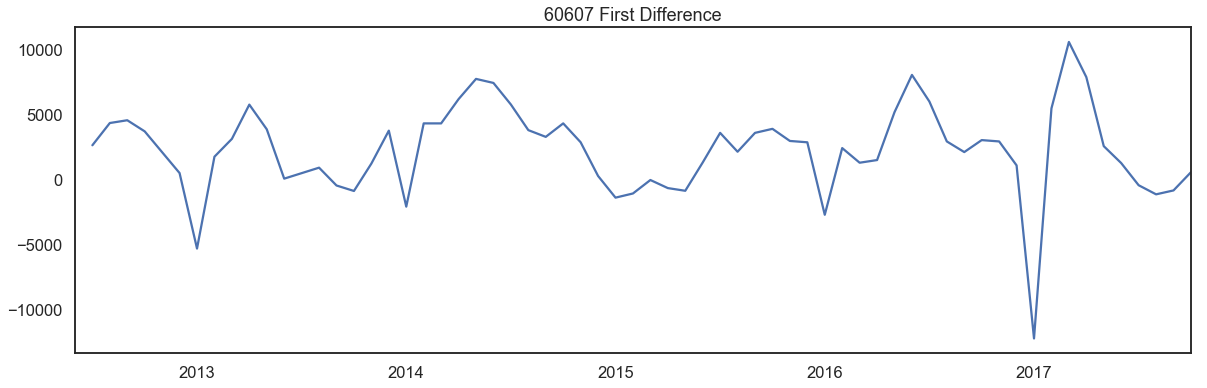

Test Statistic                 -5.204733
p-value                         0.000009
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


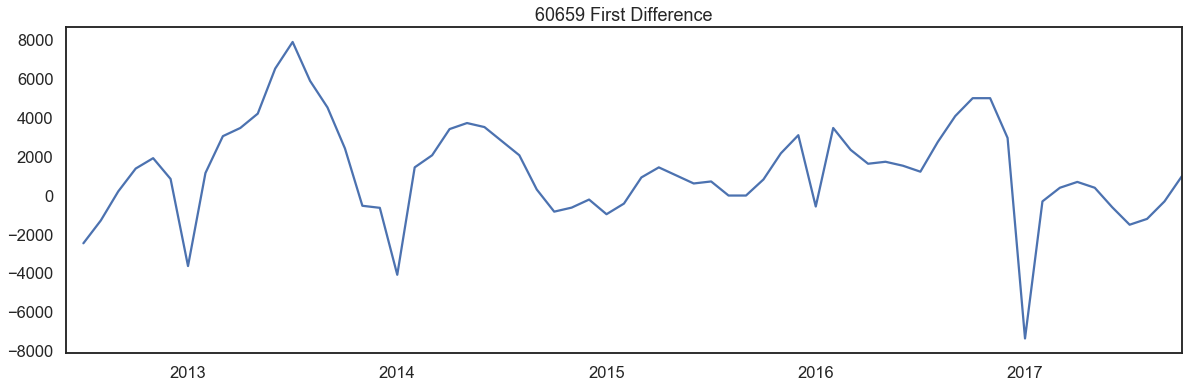

Test Statistic                 -4.273585
p-value                         0.000493
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


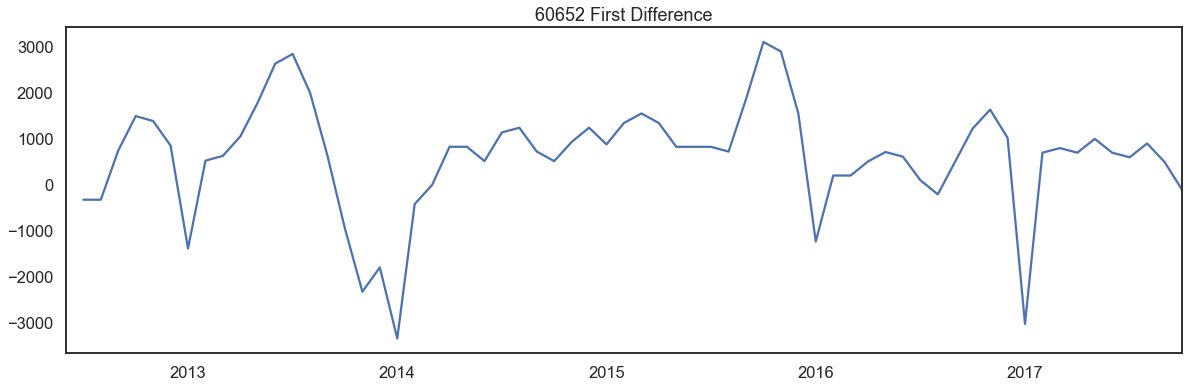

Test Statistic                 -4.193289
p-value                         0.000676
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


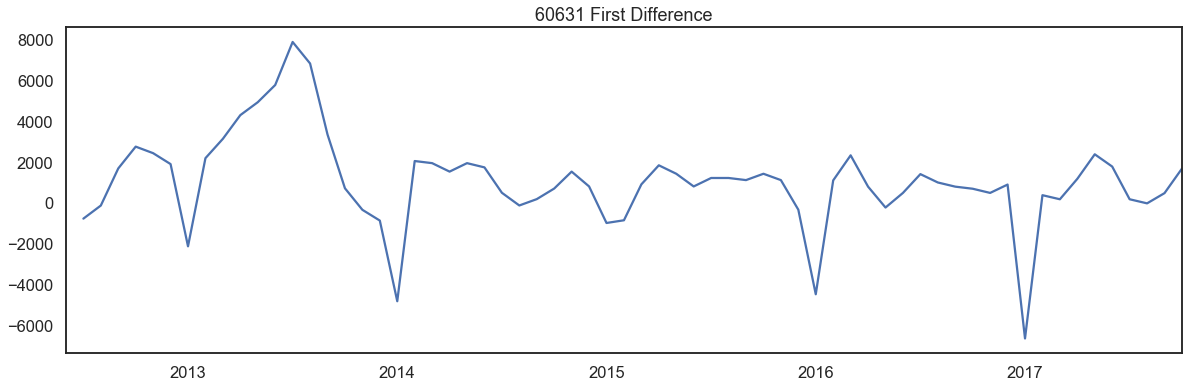

Test Statistic                 -4.546684
p-value                         0.000162
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


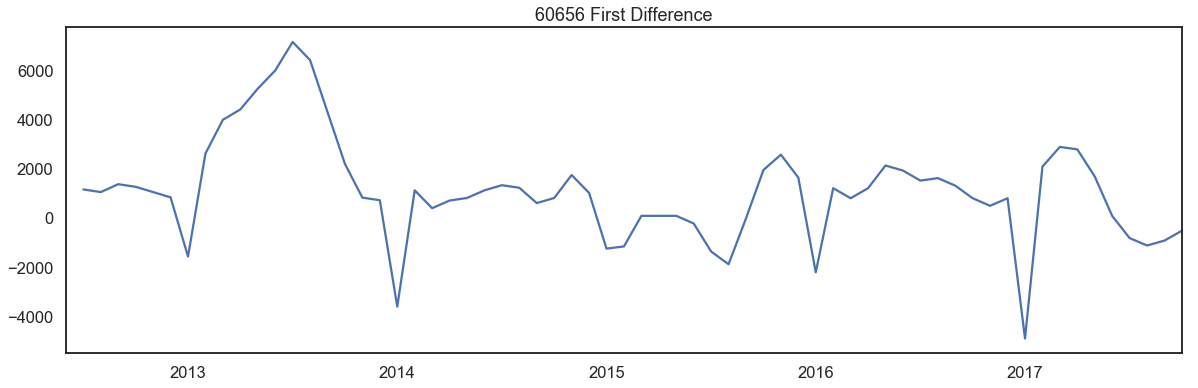

Test Statistic                 -3.786009
p-value                         0.003054
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


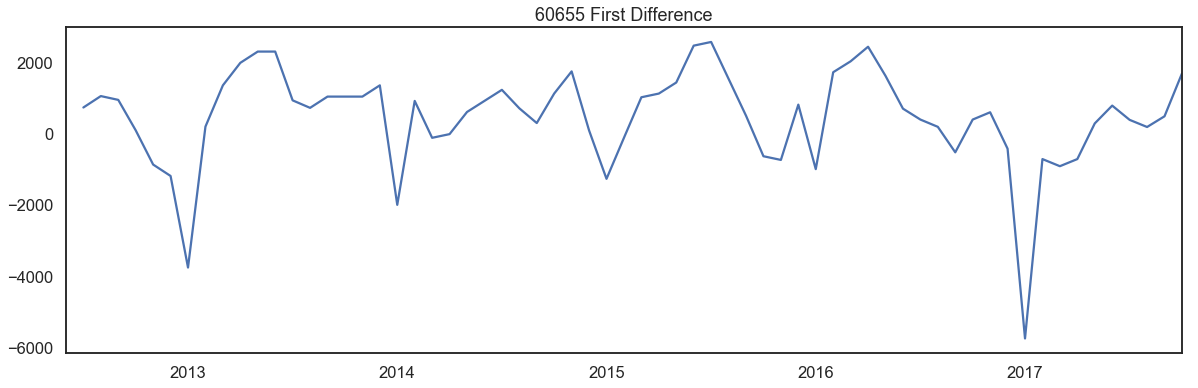

Test Statistic                 -4.883776
p-value                         0.000038
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


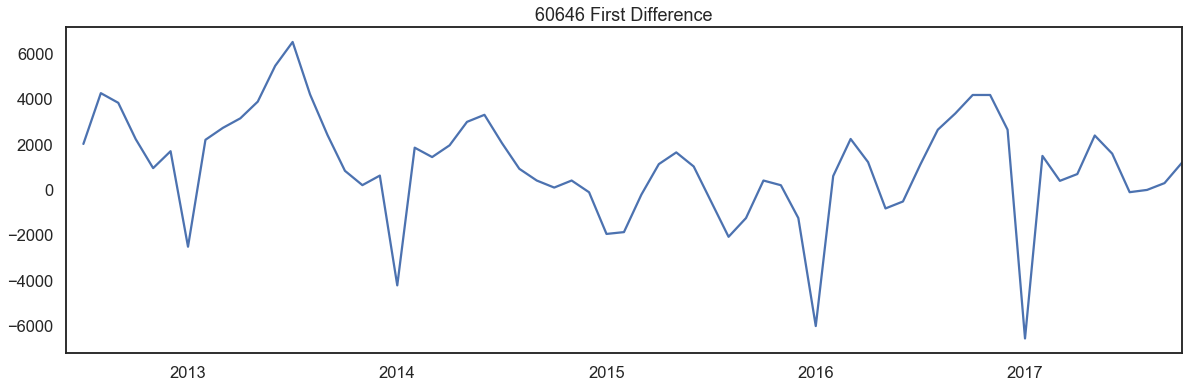

Test Statistic                 -4.891457
p-value                         0.000036
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


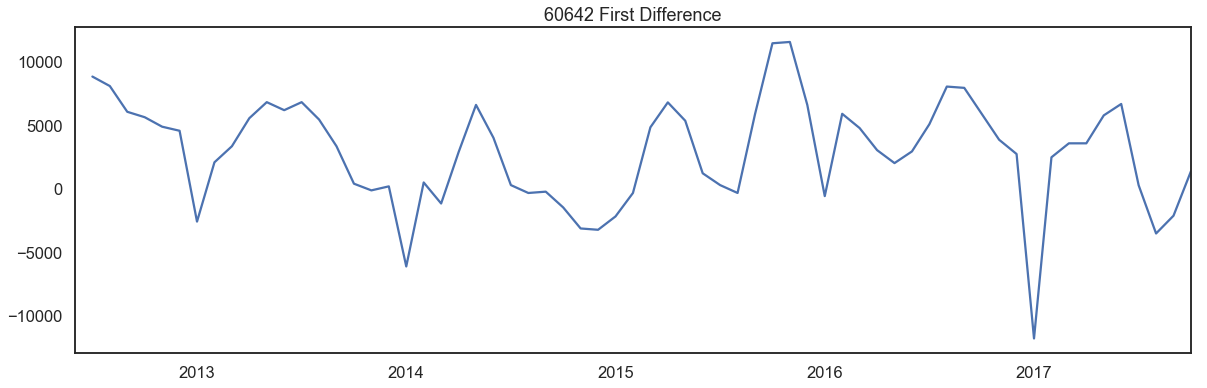

Test Statistic                 -4.468587
p-value                         0.000224
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


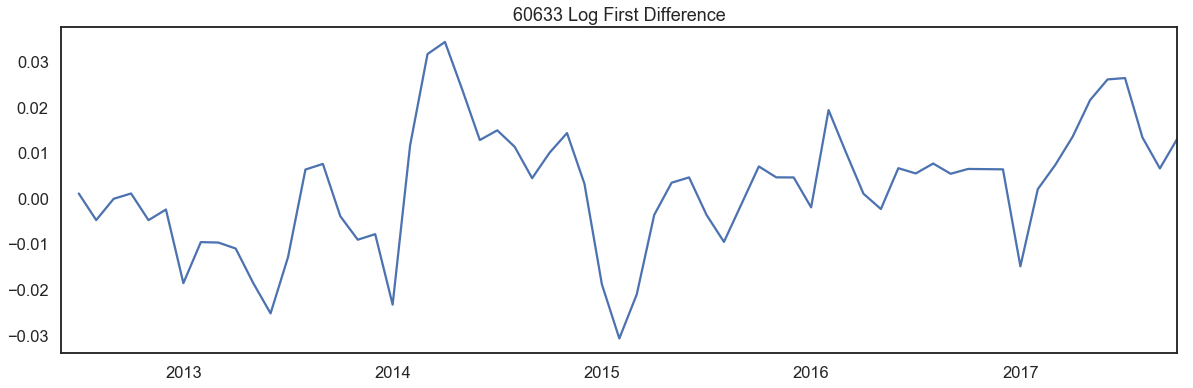

Test Statistic                 -3.909838
p-value                         0.001964
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64

Number of p-values above alpha of 0.05: 0

Zipcodes with p-values above alpha of 0.05 []

Zipcodes requiring log first difference transformation: [60626, 60649, 60622, 60608, 60643, 60605, 60651, 60633]


In [34]:
chicago_df_defl_train_dt, log_diff_list = detrend_test(chicago_df_defl_train)

# save new data to csv
chicago_df_defl_train_dt.to_csv('../data/processed/chicago_june2012_to_april2018_deflated_traindata_detrended')

* Number of p-values above our alpha of 0.05 was 0
* Some zipcodes required a log first difference

### Remove zipcodes requiring log first difference (to focus on first difference zipcodes)

In [35]:
# Remove log first difference columns, to focus on first difference columns only
    # NB that log_diff_list are Zipcodes which require a log first difference to transform
chicago_df_defl_train_fd = chicago_df_defl_train.drop(log_diff_list, axis=1)
chicago_df_defl_test_fd  = chicago_df_defl_test.drop(log_diff_list, axis=1)

# Save first difference train and test data to csv
chicago_df_defl_train_fd.to_csv('../data/processed/chicago_june2012_to_april2018_deflated_traindata_firstdifference')
chicago_df_defl_test_fd.to_csv('../data/processed/chicago_june2012_to_april2018_deflated_testdata_firstdifference')

### Detrend test data

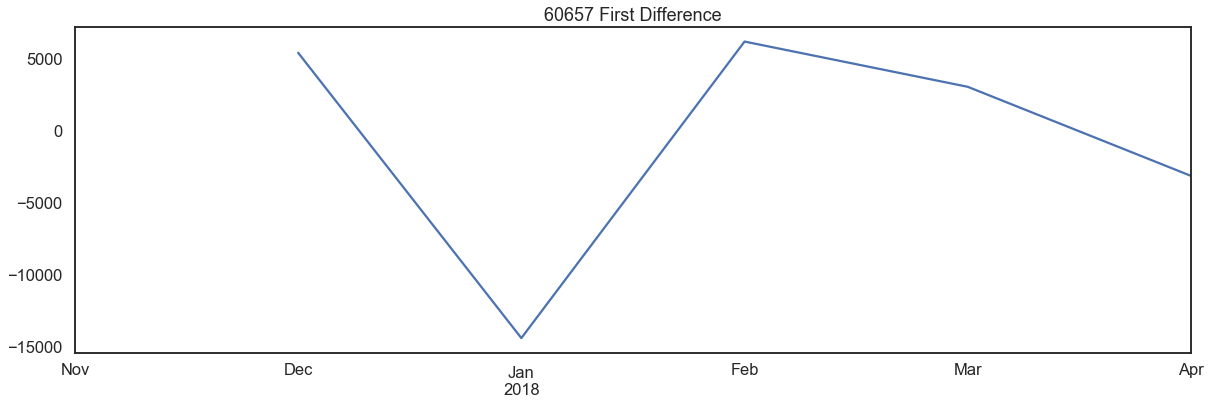

Test Statistic                -2.922198
p-value                        0.042827
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


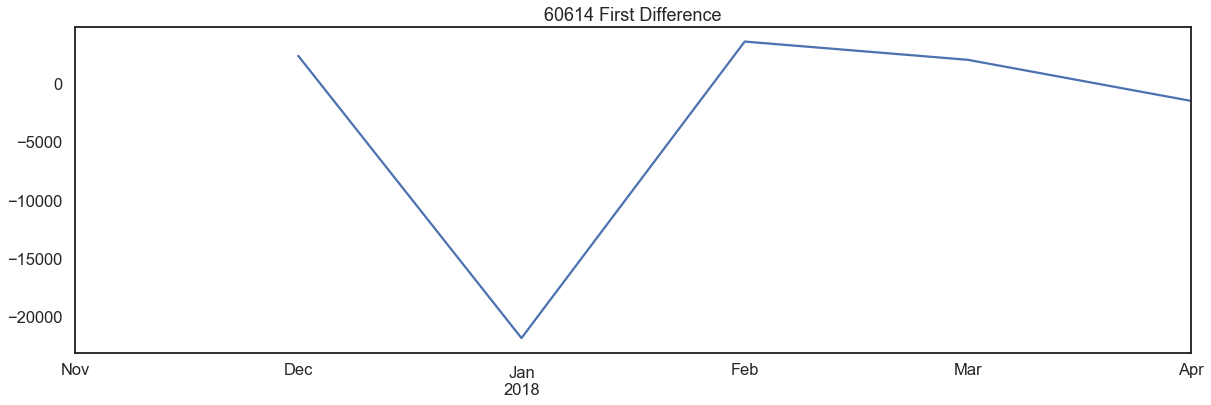

Test Statistic                -2.305512
p-value                        0.170196
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


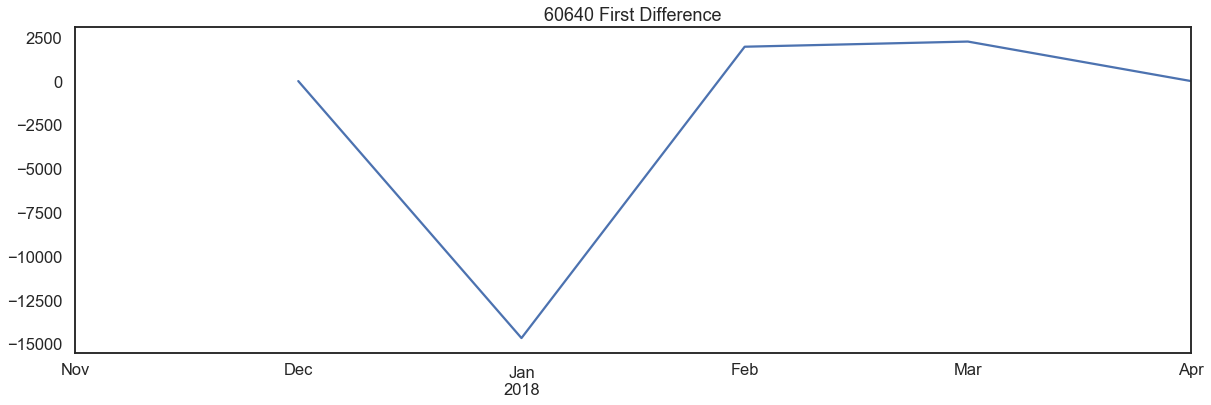

Test Statistic                -1.850312
p-value                        0.355784
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


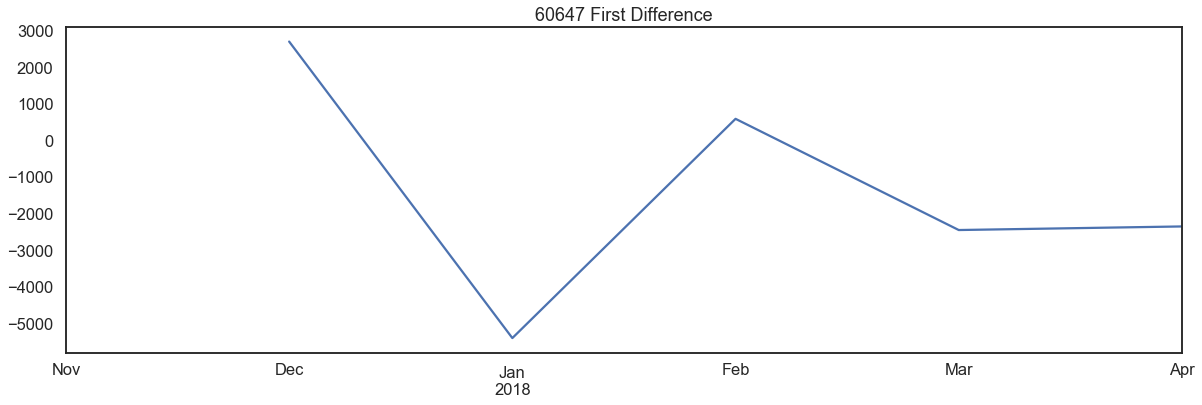

Test Statistic                -9.865718e+00
p-value                        4.119338e-17
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+00
Critical Values 1%            -7.355441e+00
Critical Values 5%            -4.474365e+00
Critical Values 10%           -3.126933e+00
dtype: float64


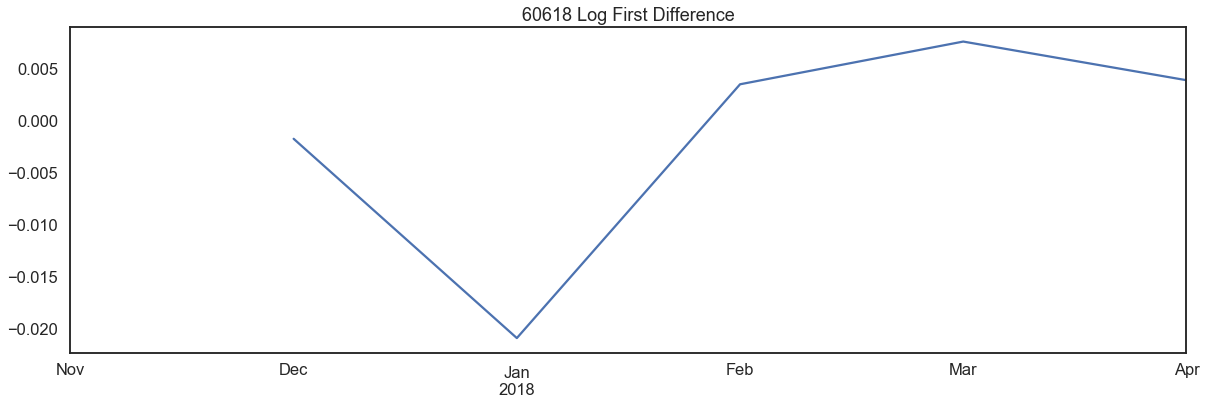

Test Statistic                -1.355802
p-value                        0.603272
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


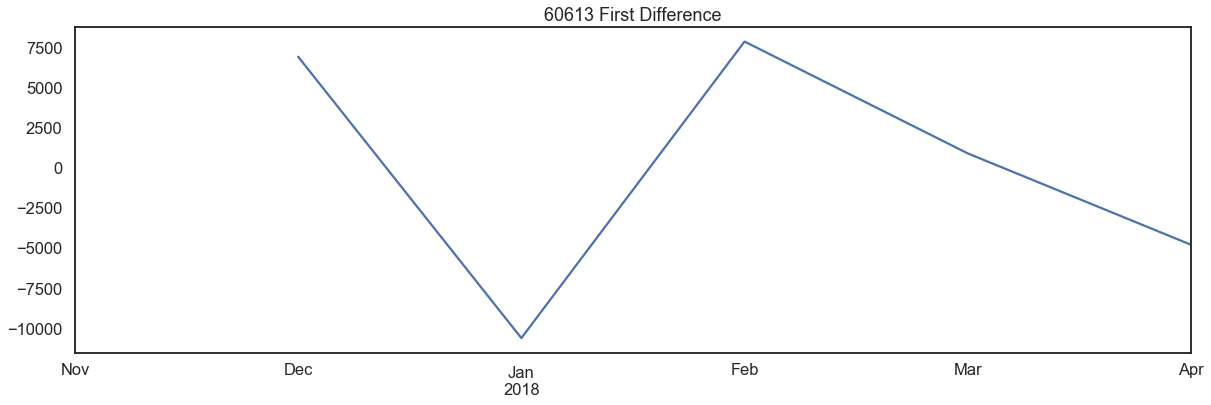

Test Statistic                -3.685630
p-value                        0.004320
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


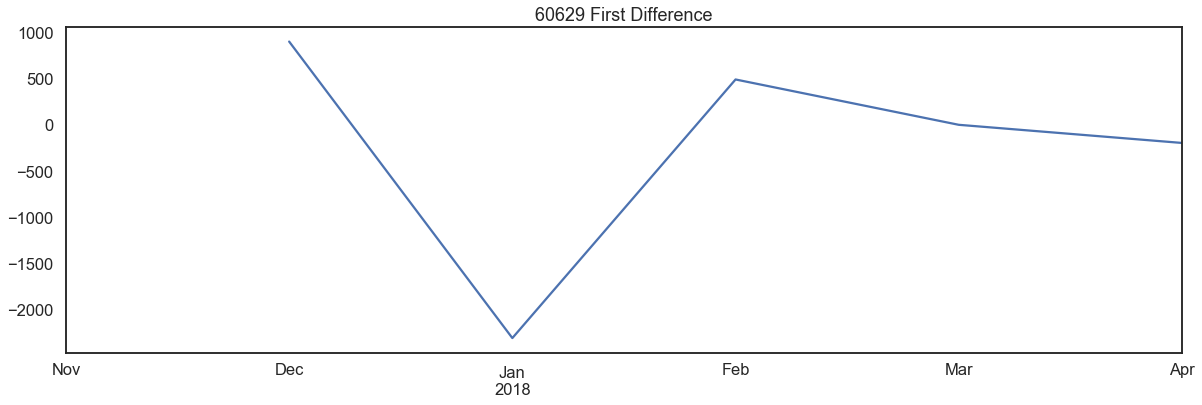

Test Statistic                -3.612980
p-value                        0.005518
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


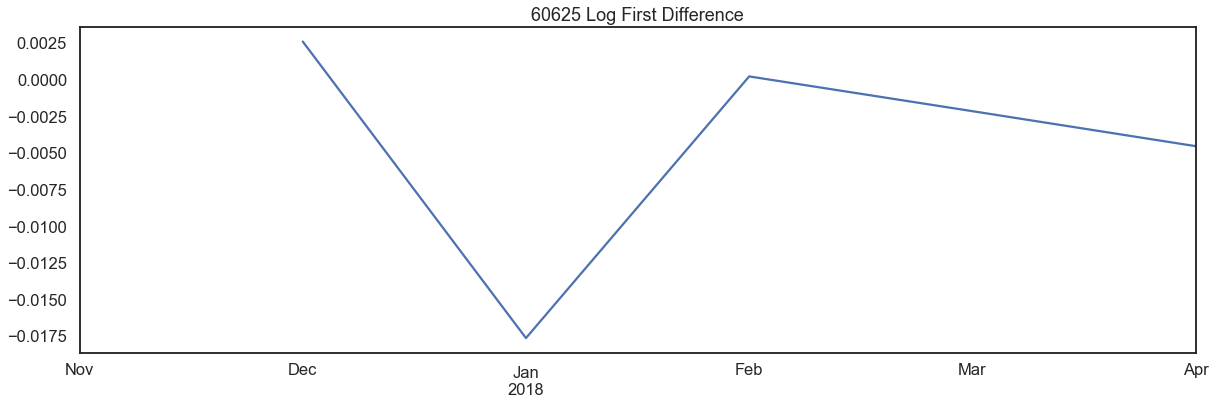

Test Statistic                -3.353329
p-value                        0.012657
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


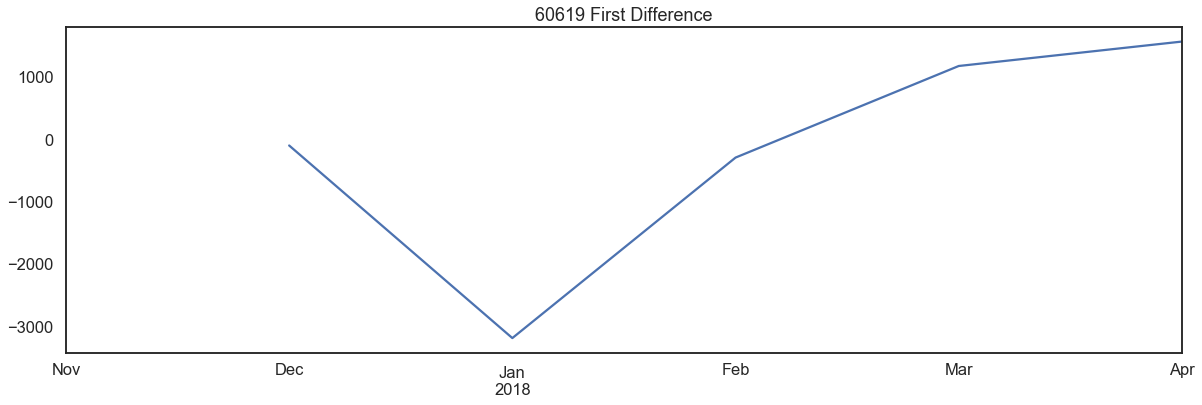

Test Statistic                -0.953514
p-value                        0.769839
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


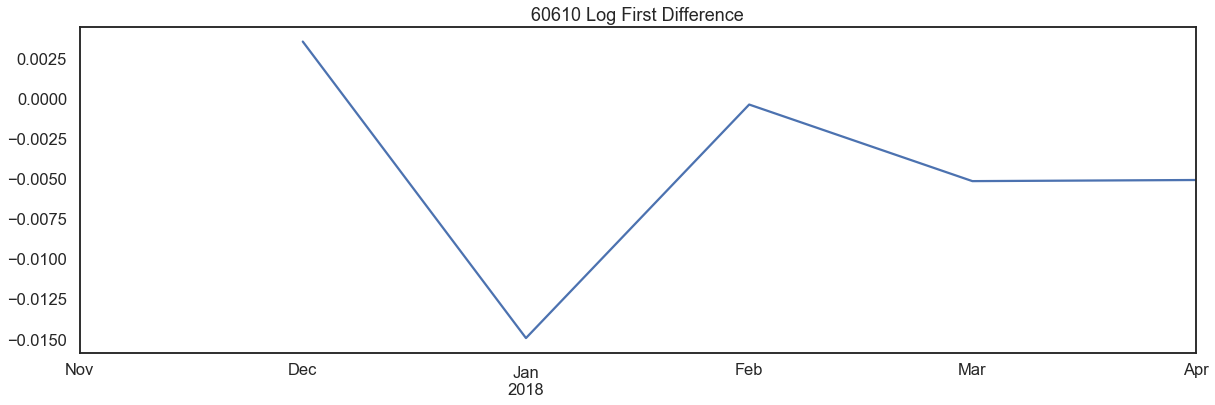

Test Statistic                -6.206593e+00
p-value                        5.638240e-08
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+00
Critical Values 1%            -7.355441e+00
Critical Values 5%            -4.474365e+00
Critical Values 10%           -3.126933e+00
dtype: float64


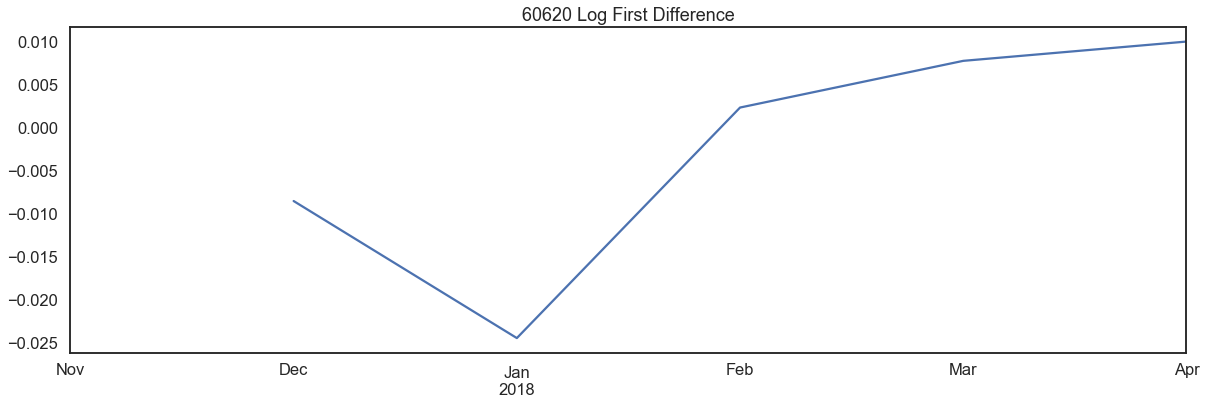

Test Statistic                -0.846167
p-value                        0.805183
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


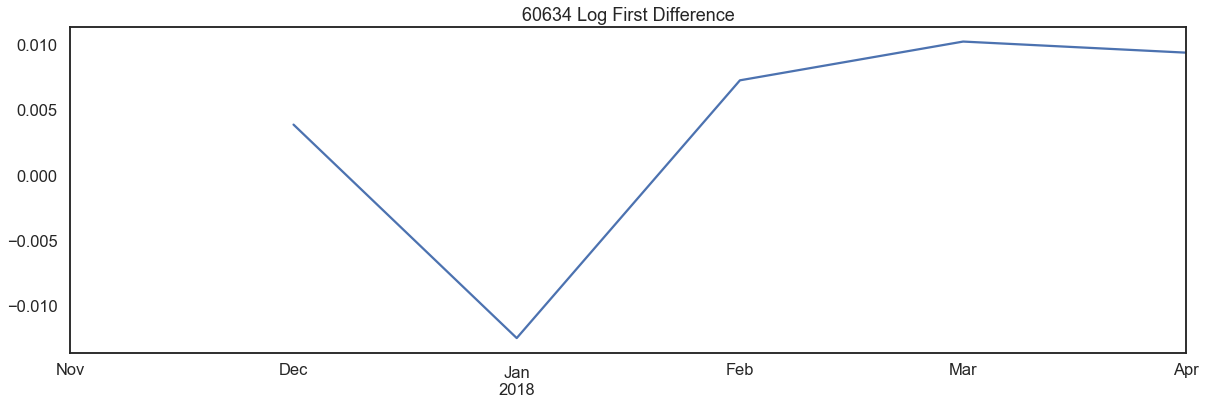

Test Statistic                -1.331498
p-value                        0.614642
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


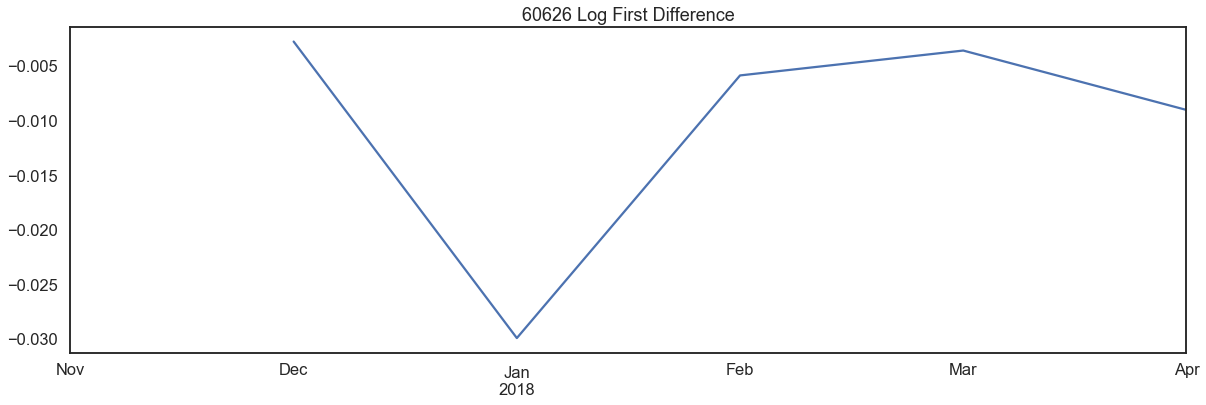

Test Statistic                -2.331284
p-value                        0.162077
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


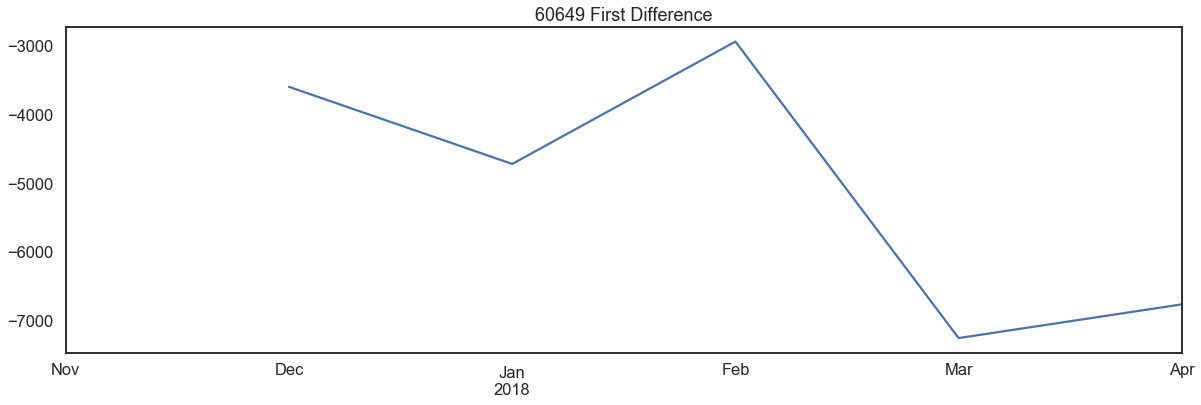

Test Statistic                -1.241842
p-value                        0.655343
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


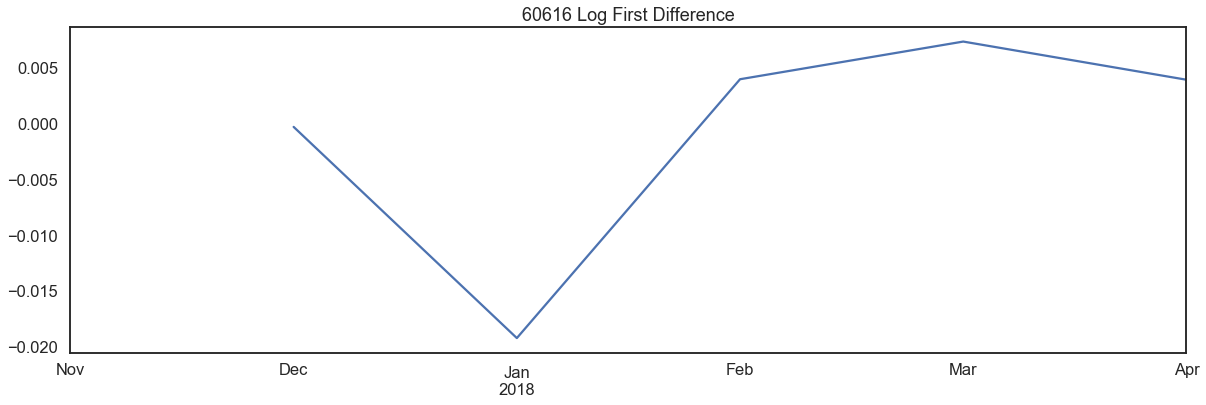

Test Statistic                -1.438012
p-value                        0.563923
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


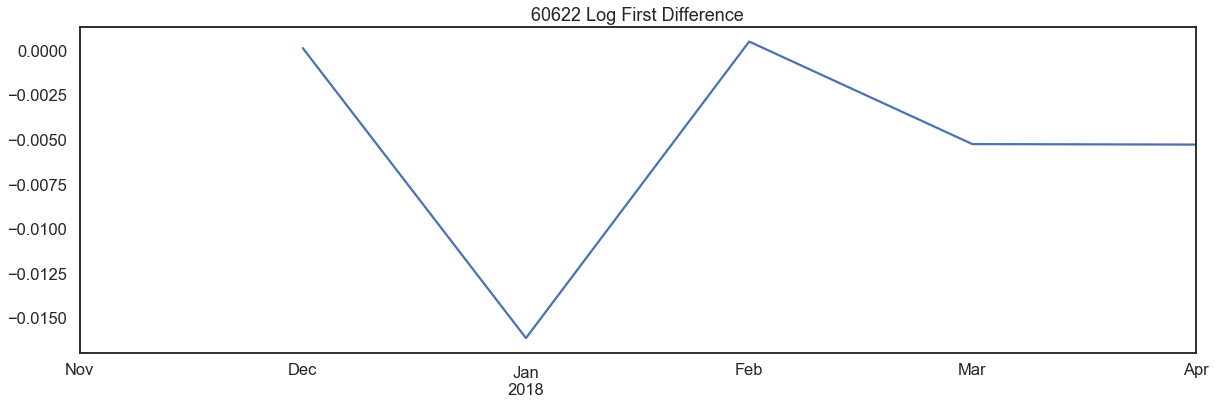

Test Statistic                -3.968239
p-value                        0.001586
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


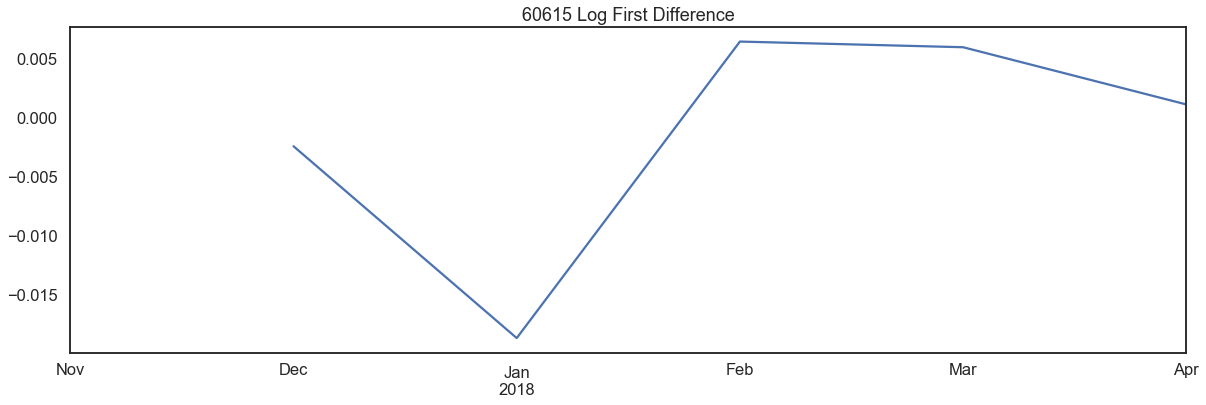

Test Statistic                -1.548651
p-value                        0.509322
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


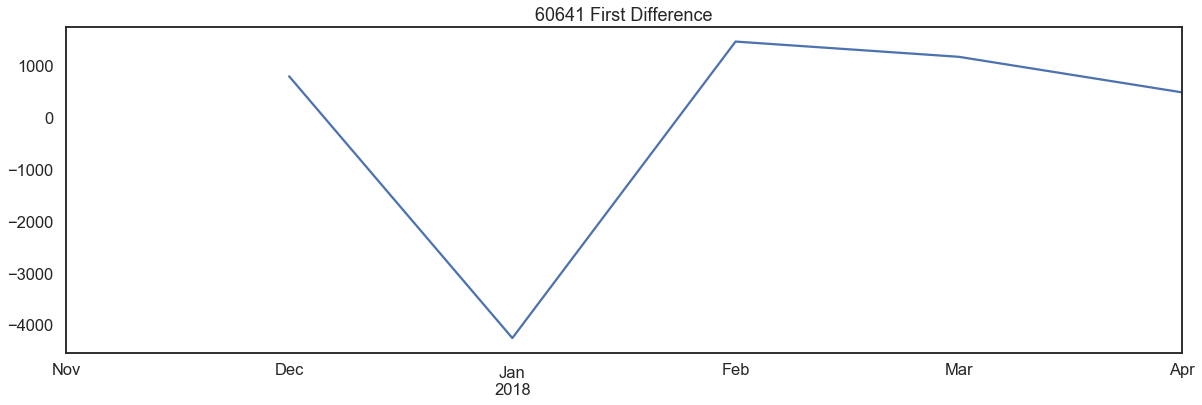

Test Statistic                -2.049956
p-value                        0.265108
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


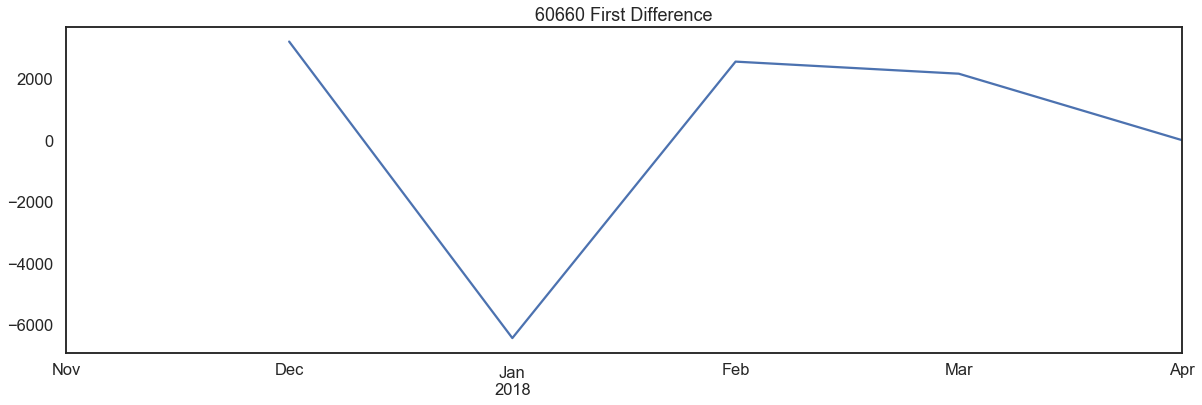

Test Statistic                -2.762883
p-value                        0.063774
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


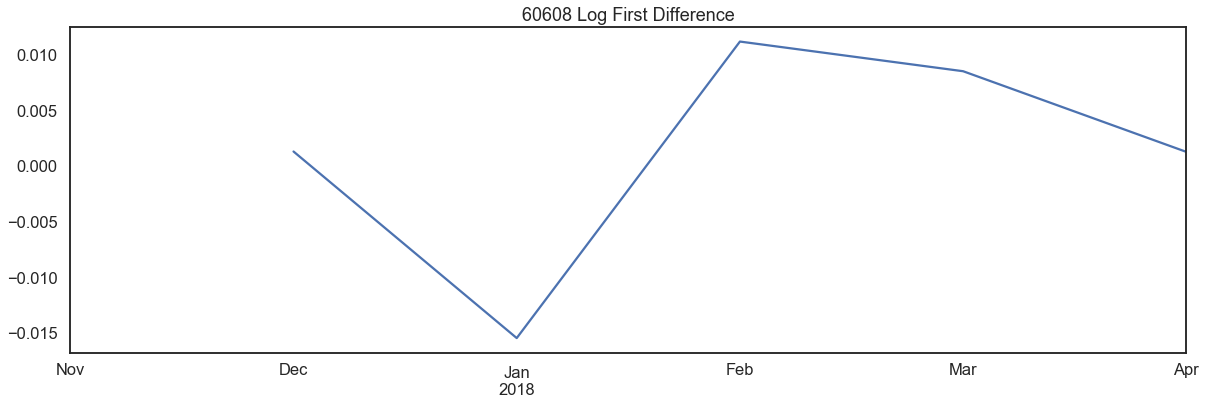

Test Statistic                -1.768070
p-value                        0.396425
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


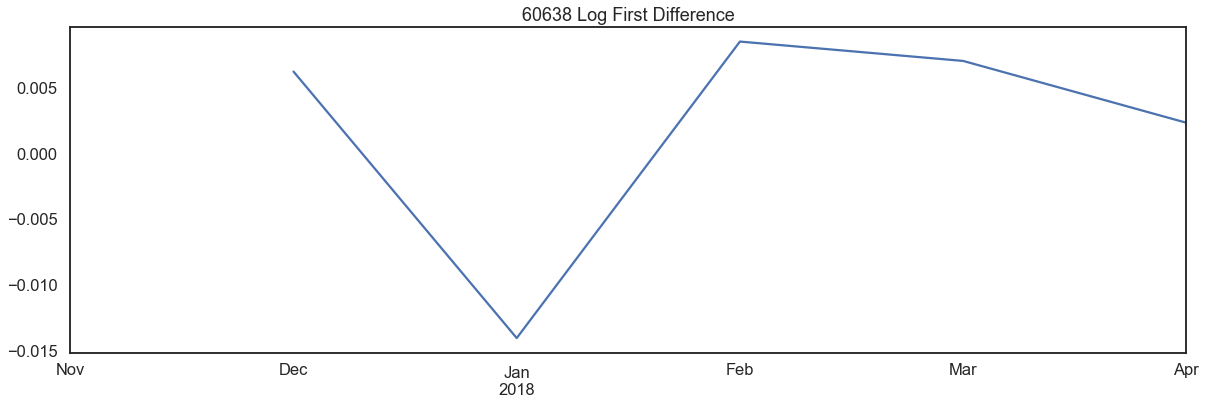

Test Statistic                -2.255064
p-value                        0.186870
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


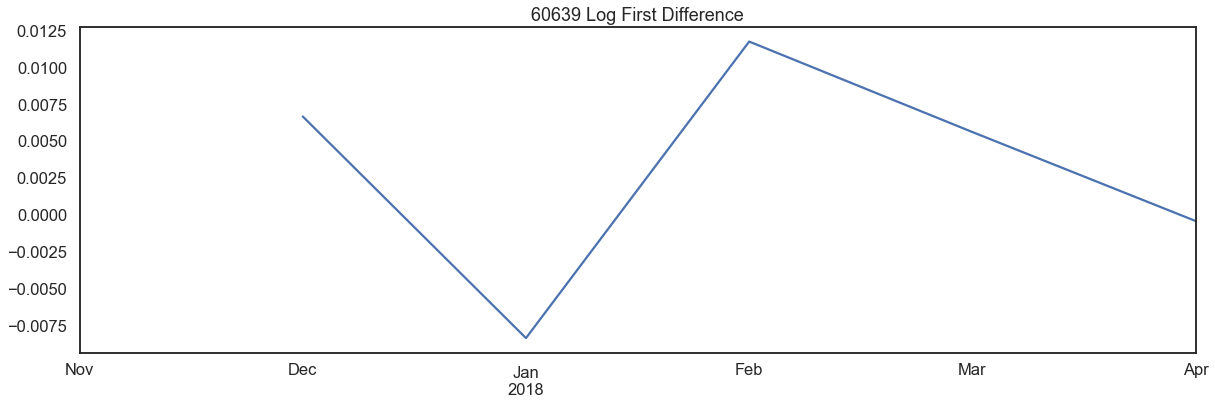

Test Statistic                -2.663600
p-value                        0.080552
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


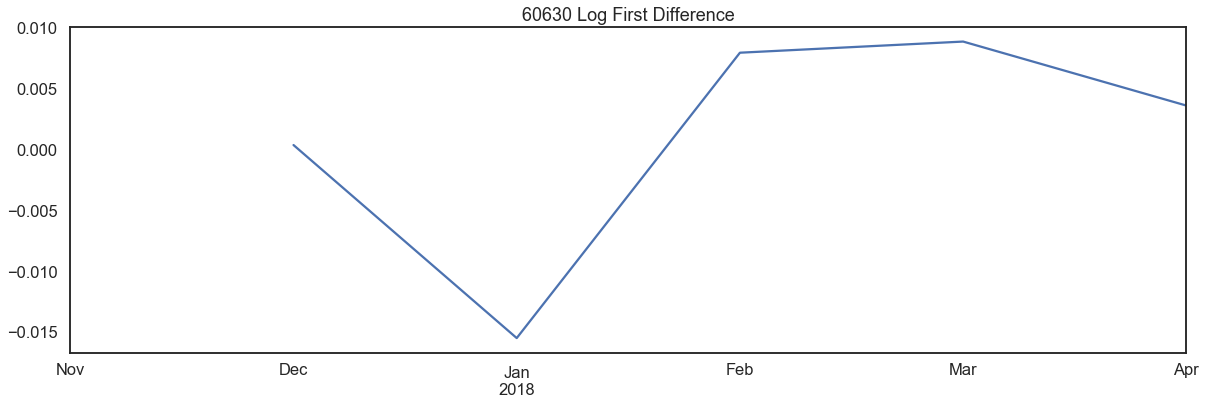

Test Statistic                -1.509017
p-value                        0.529046
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


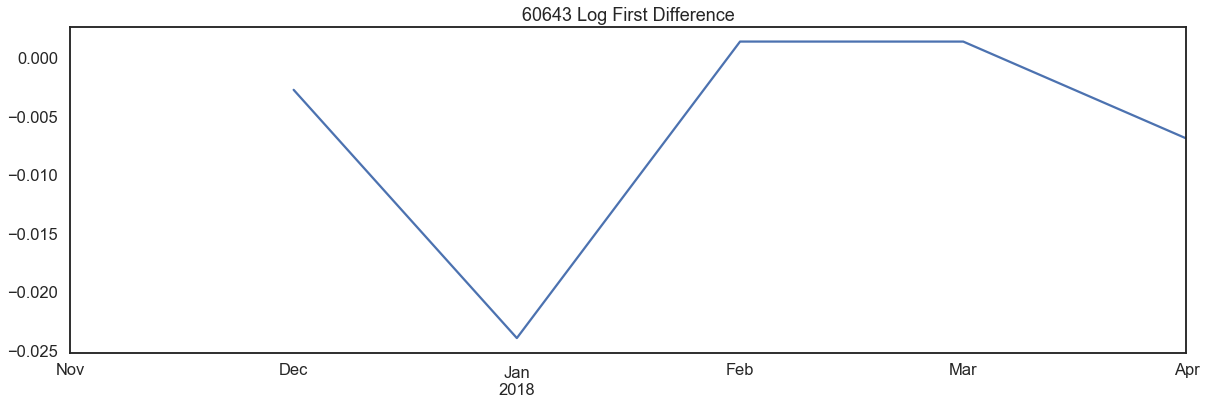

Test Statistic                -2.014926
p-value                        0.280067
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


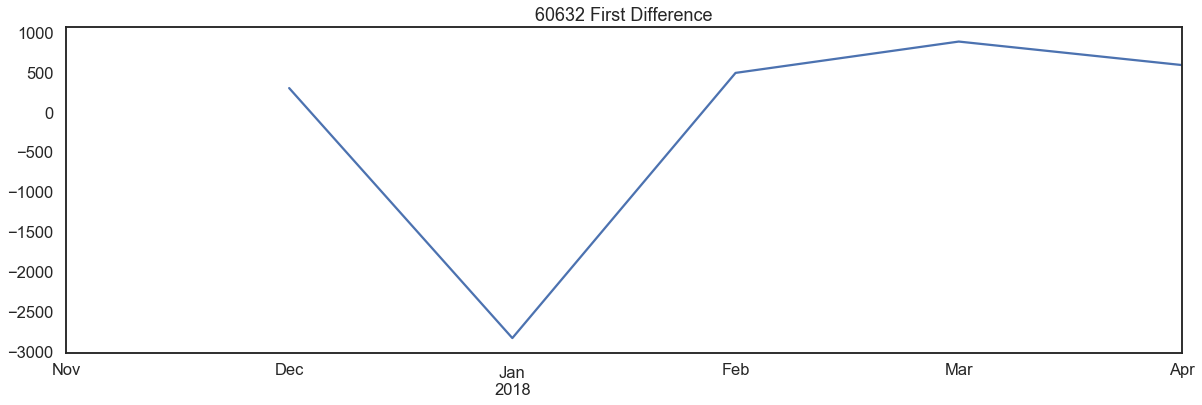

Test Statistic                -1.649052
p-value                        0.457535
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


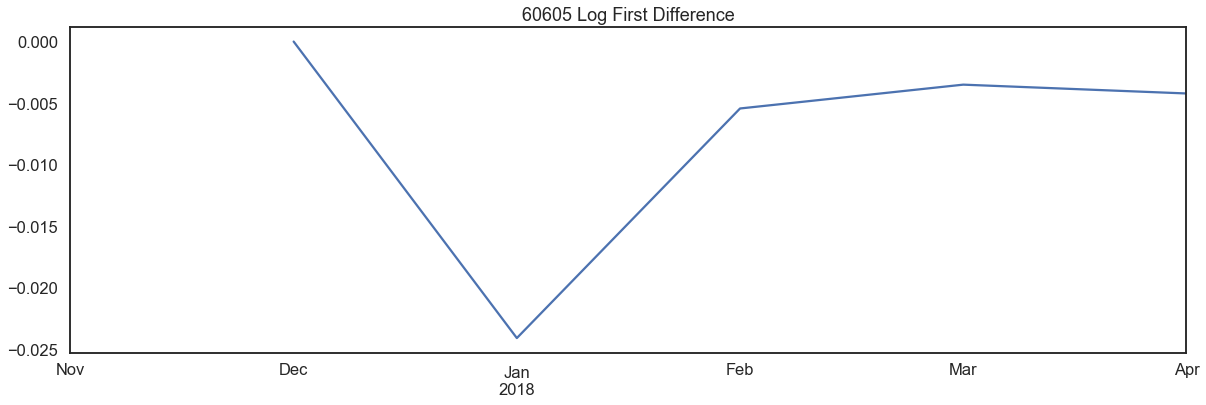

Test Statistic                -2.429934
p-value                        0.133465
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


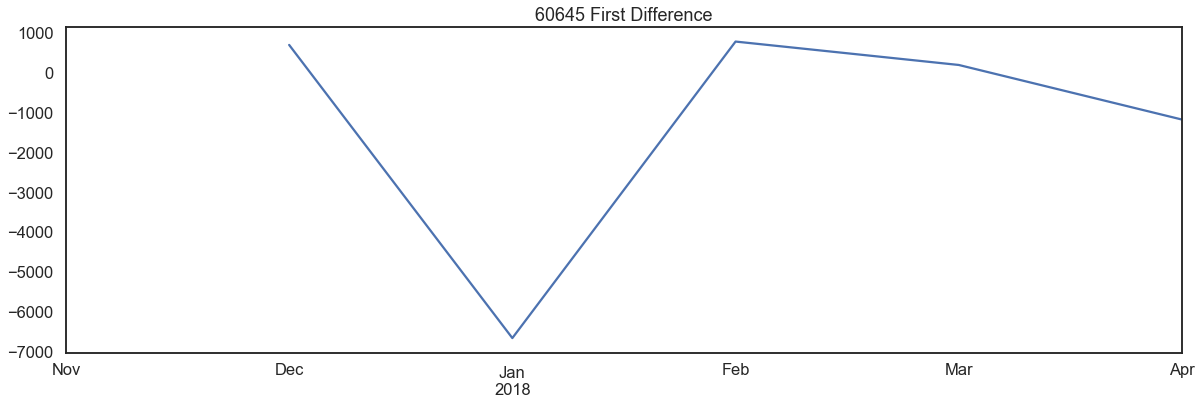

Test Statistic                -2.559435
p-value                        0.101674
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


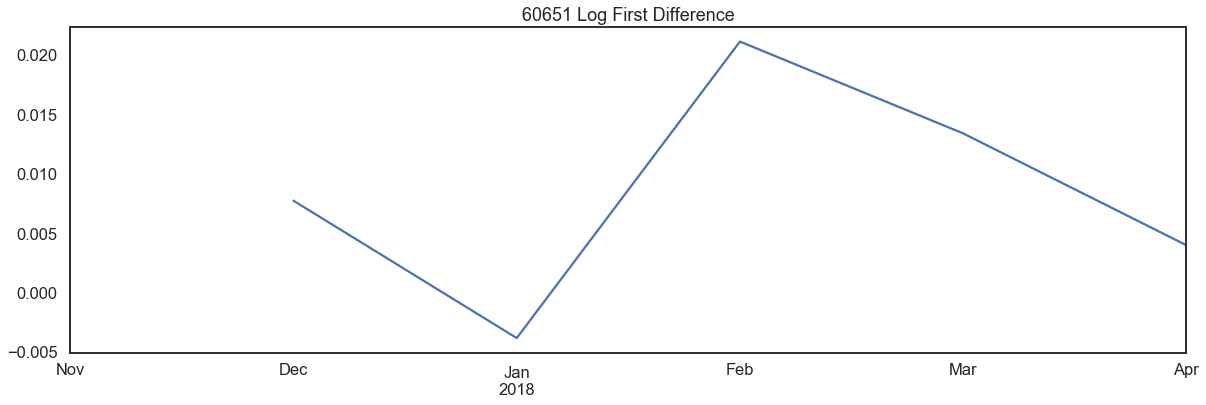

Test Statistic                -1.901469
p-value                        0.331371
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


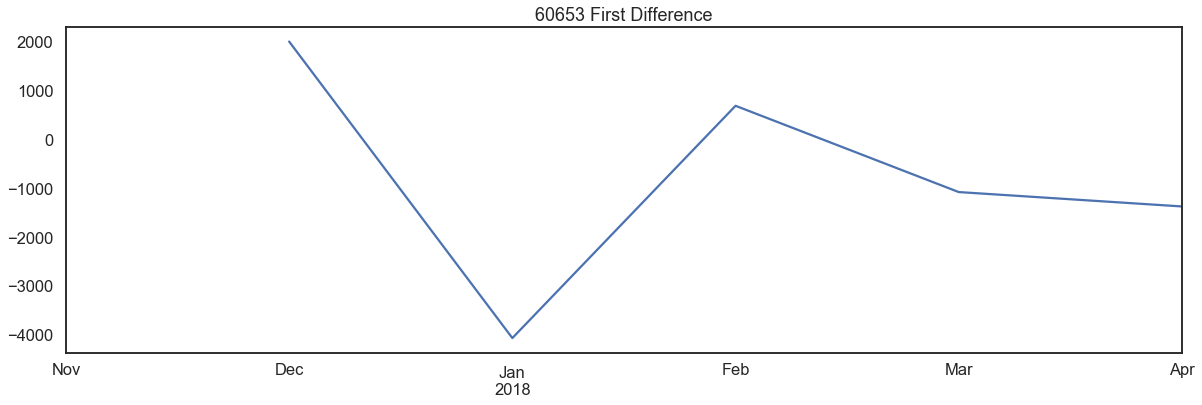

Test Statistic                -6.948862e+00
p-value                        9.810309e-10
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+00
Critical Values 1%            -7.355441e+00
Critical Values 5%            -4.474365e+00
Critical Values 10%           -3.126933e+00
dtype: float64


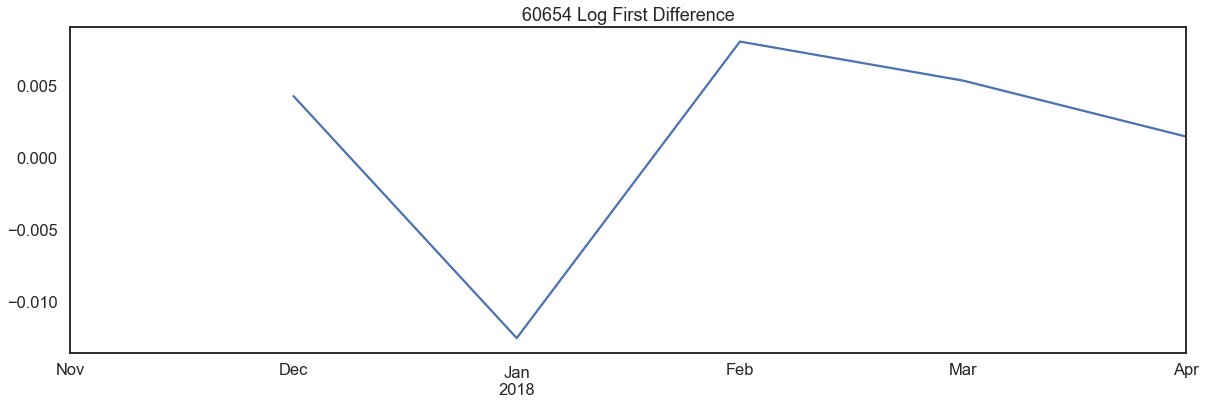

Test Statistic                -2.233869
p-value                        0.194183
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


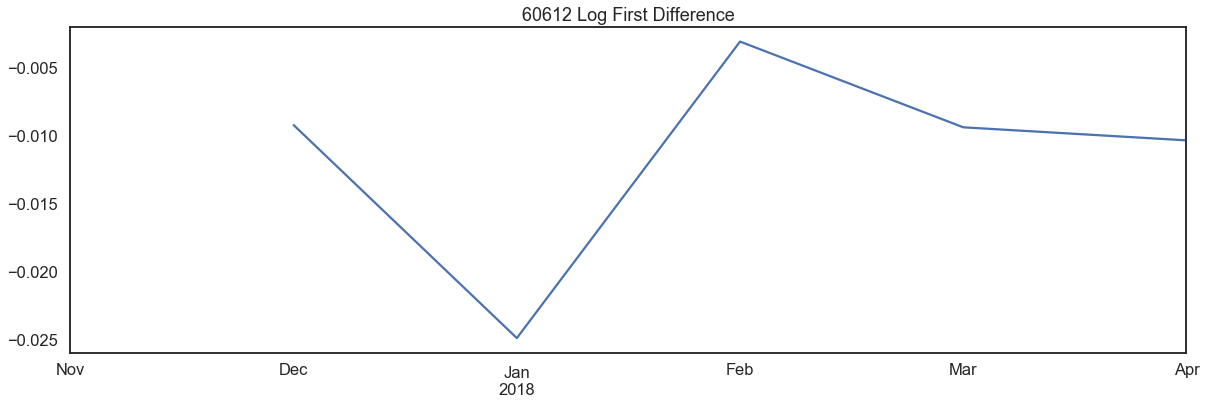

Test Statistic                -2.395764
p-value                        0.142936
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


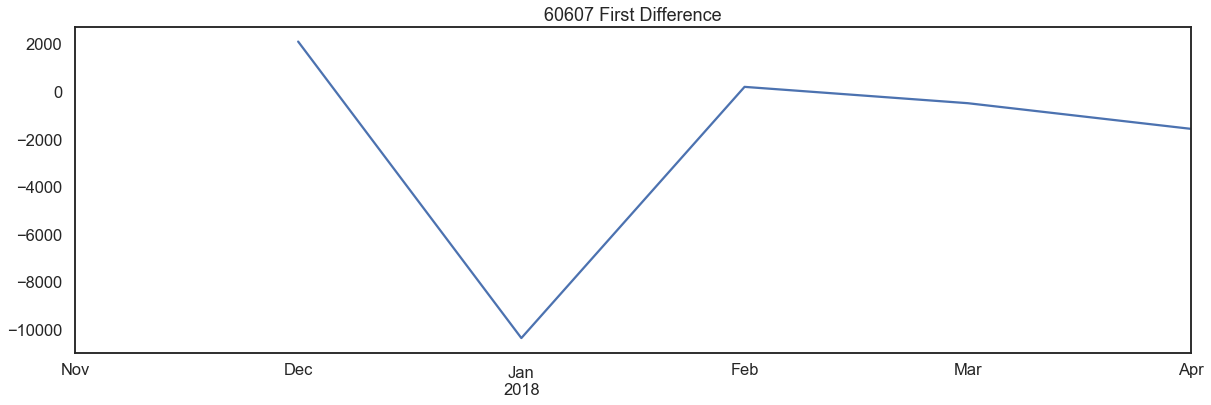

Test Statistic                -3.051503
p-value                        0.030357
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


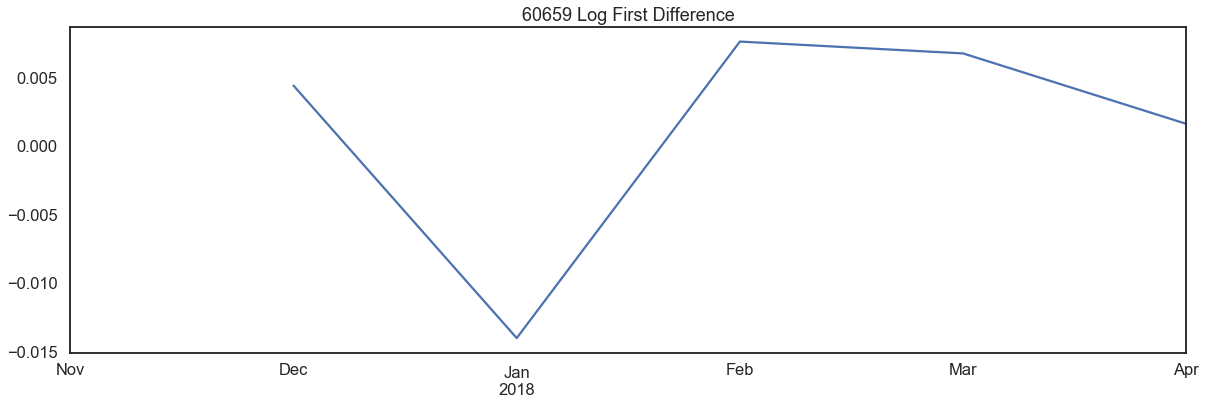

Test Statistic                -2.074248
p-value                        0.254995
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


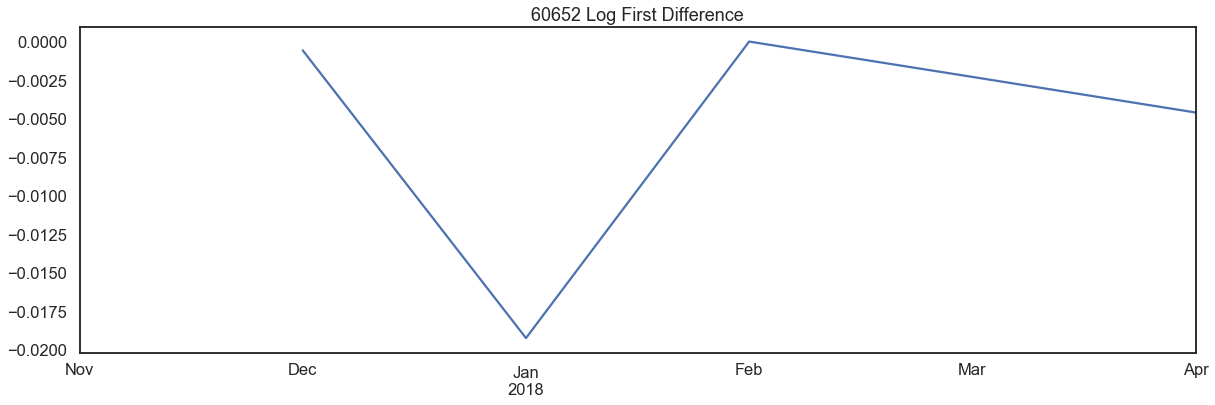

Test Statistic                -2.592341
p-value                        0.094591
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


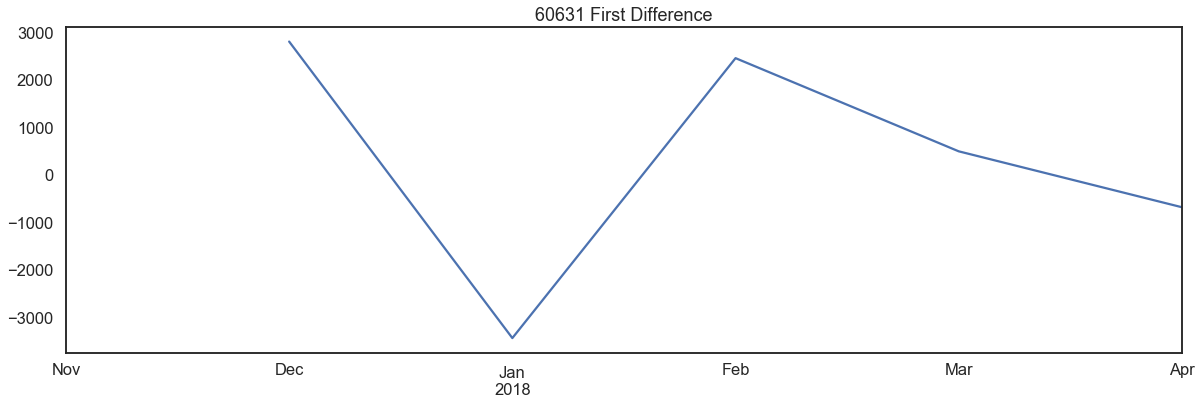

Test Statistic                -4.396752
p-value                        0.000301
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


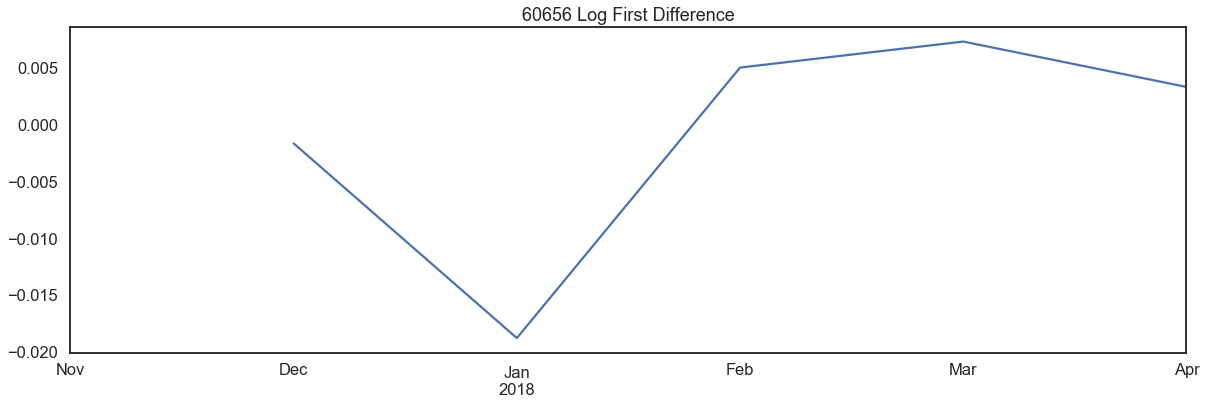

Test Statistic                -1.407081
p-value                        0.578877
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


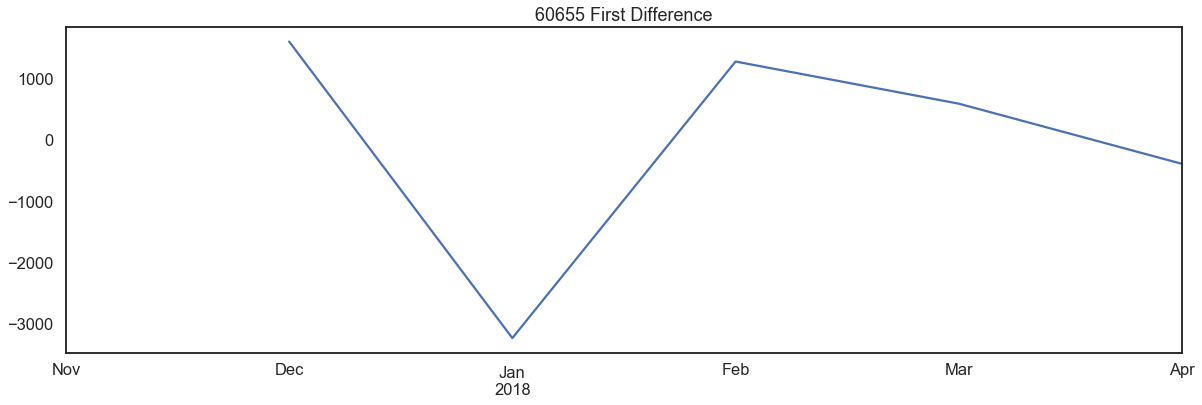

Test Statistic                -3.320648
p-value                        0.013980
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


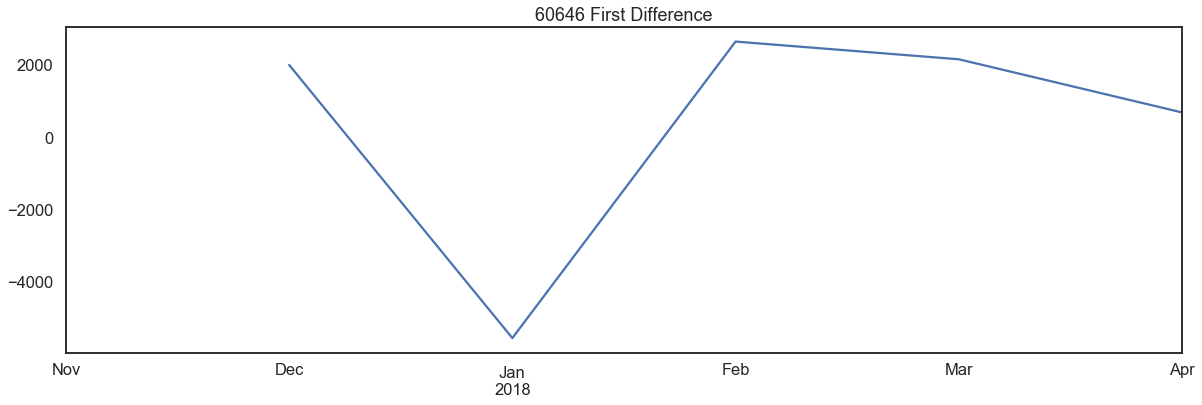

Test Statistic                -2.262681
p-value                        0.184287
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


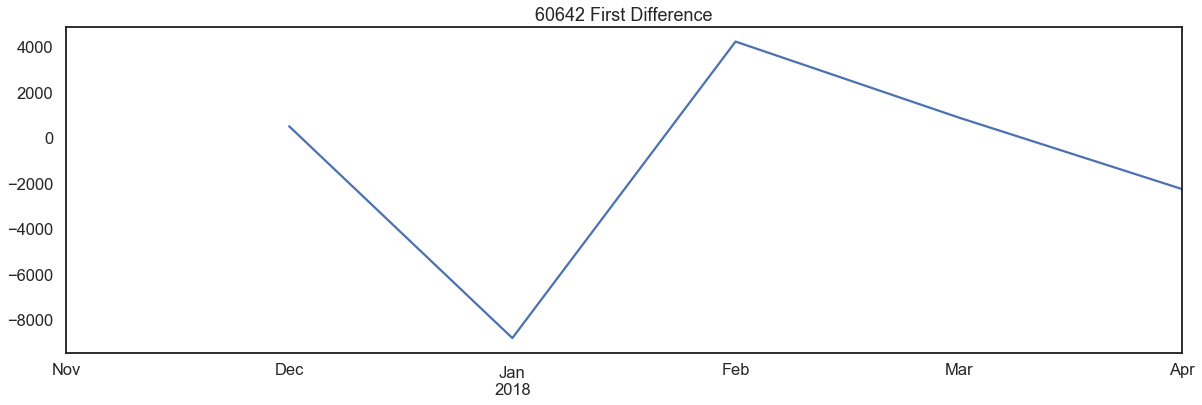

Test Statistic                -2.396224
p-value                        0.142805
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64


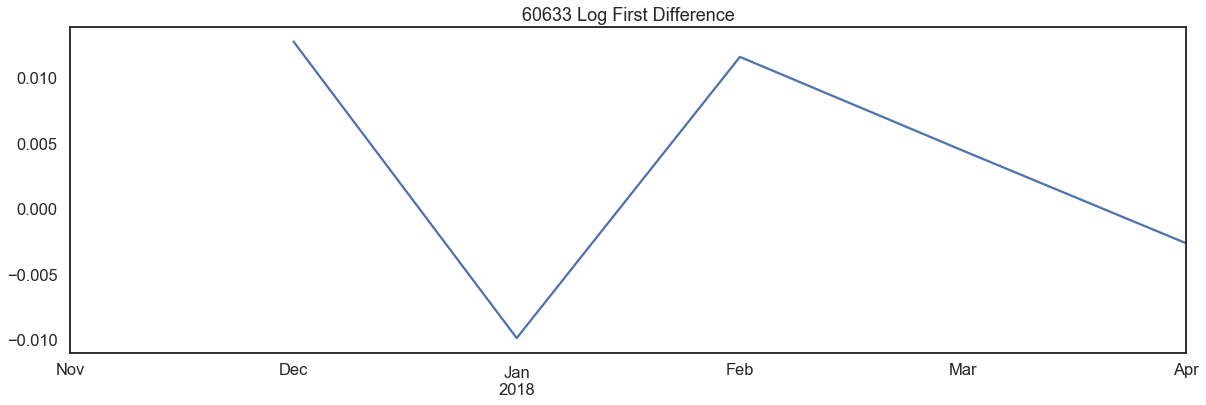

Test Statistic                -4.057963
p-value                        0.001136
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values 1%            -7.355441
Critical Values 5%            -4.474365
Critical Values 10%           -3.126933
dtype: float64

Number of p-values above alpha of 0.05: 28

Zipcodes with p-values above alpha of 0.05 [60614, 60640, 60618, 60619, 60620, 60634, 60626, 60649, 60616, 60615, 60641, 60660, 60608, 60638, 60639, 60630, 60643, 60632, 60605, 60645, 60651, 60654, 60612, 60659, 60652, 60656, 60646, 60642]

Zipcodes requiring log first difference transformation: [60618, 60625, 60610, 60620, 60634, 60626, 60616, 60622, 60615, 60608, 60638, 60639, 60630, 60643, 60605, 60651, 60654, 60612, 60659, 60652, 60656, 60633]


AttributeError: 'tuple' object has no attribute 'drop'

In [36]:
# detrend test data
chicago_df_defl_test_dt = detrend_test(chicago_df_defl_test, 0.05, maxlag=0)
# Remove log first difference columns, to focus on first difference columns only
chicago_df_defl_test_dt.drop(log_diff_list, axis=1, inplace=True)
# save detrended test data
chicago_df_defl_test_dt.to_csv('../data/processed/chicago_june2012_to_april2018_deflated_testdata_detrended')

# Auto-Correlation Function & Partial Auto-Correlation Function

### Function to plot the ACF and PACF of each zipcode

In [ ]:
def ACF_PACF(TS, lags=30):
    for column in list(TS.columns):
        # Put column's heading in top left
        print('\nACF & PACF for {}'.format(column))
        
        # Plot
        plt.figure(figsize=(20,6));
            # Plot ACF
        plot_acf(TS[column].dropna(), lags=lags);
        plt.title('Auto-correlation Function for {}'.format(column));
        plt.xlabel('Lag');
        plt.ylabel('Auto-correlation');
        plt.show();
            # Plot PACF
        plot_pacf(TS[column].dropna(), lags=lags);
        plt.title('Partial Auto-correlation Function for {}'.format(column));
        plt.xlabel('Lag');
        plt.ylabel('Auto-correlation');
        plt.show();
        
        # Divide up each column's pair of plots
        print('__________________________________________________________________________________')

#### Plotting each zipcode's ACF and PACF

In [ ]:
ACF_PACF(chicago_df_defl_train_dt);

### Findings from ACF & PACF Plots

* From the plots above, we can conclude an AR model with one lag would be an appropriate model to fit the data.

# ARIMA

## Function to evaluate our ARIMA model

## Possible list of p, d and q

In [ ]:
def evaluate_arima_model(X, test, arima_order):
    '''Provides the Mean Squared Error for the train vs test
    arima_order = configuration of (p,d,q)'''
    # prepare training dataset
    history = [x for x in X]
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(np.array(X.dropna()), order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    return mse

In [37]:
p_list = [0,1,2,3]
d_list = [1]
q_list = [0,1,2,3]

## Function to evaluate our model

#### Test evaluate_models()

In [ ]:
def evaluate_models(train_column, test, p_values, d_values, q_values):
    best_pdq, best_score = None, float('inf')
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p,d,q)
                try:
                    rmse = np.sqrt(evaluate_arima_model(train_column, test, arima_order))
                    if rmse < best_score:
                        best_pdq, best_score = arima_order, rmse
                except:
                    continue
    print('Best ARIMA {} RMSE= {}'.format(best_pdq, best_score))
    return best_pdq

In [40]:
column = 60618
evaluate_models(chicago_df_defl_train_fd[column], test=chicago_df_defl_test_fd[column], p_values= p_list, d_values=d_list, q_values=q_list)


Best ARIMA (1, 1, 3) RMSE= 6838.58369420071


(1, 1, 3)

## Find best ARIMA model configuration and its RMSE for each zipcode

In [ ]:
arima_order_rmse_values = [] # list of tuples, where each tuple is an arima order and an associated RMSE value
for column in list(chicago_df_defl_train_fd.columns):
    print(column) 
    order_value = evaluate_models(chicago_df_defl_train_fd[column], test=chicago_df_defl_test_fd[column],
                    p_values= p_list, d_values=d_list, q_values=q_list)
    arima_order_rmse_values.append(order_value)

# Plot Forecasted House Prices

# NEED TO FIX WHAT RES IS ON PLOT_TIMESERIES_MODEL

## Function to display estimation, validation and prediction house prices

In [ ]:
def plot_timeseries_model(data,column,res):
    '''Function will plot the original data, alongside any data for validation and prediction
    
       data: dataframe to be used
       column: the column to be plotted in your dataframe
       res: results
       '''
    
    # Model in Validation Period
    column = column # zipcode column to be put in (string or integer format, depending on how you've referenced before)
    data = data

    # Set the x axis/timeline (in months)
    # (2013-01) till (2017-10) is 57 months (inclusive)
    date_start = 57 # this is number of months since the start of data to start of validation period
    date_end = 63   # this is the number of months since the start of data to end of validation period

    # Produce a new column with the forecast for 2017-11 to 2018-04 (validation period)
    data['{}_forecast'.format(column)] = res.predict(start=date_start, end=date_end, dynamic=False)

    # Plot this new forecasted column with the original data column
    ax = data[[column, '{}_forecast'.format(column)]]
        # figsize
    ax.plot(figsize=(16,12))
        # Title and Axis
    date_start_year = data.index[date_start].year
    date_start_month = data.index[date_start].month
    date_end_year = data.index[date_end].year
    date_end_month = data.index[date_end].month
    
    # Chart formatting
    ax.set(title="Median House Price in Chicago's {} Zipcode\n Between {}-{} and {}-{}".format(column[0],
                data[date_start_year], data[date_start_month], data[date_end_year], data[date_end_month]),
                xlabel='Date', ylabel='House Price in Dollars (USD)')
    

In [ ]:
plot_timeseries_model(chicago_df_defl_train_dt,60638,)

## Function to show prediction for house prices in a zipcode

In [ ]:
def predict_arima_model(data, column, arima_order, periods, y_lim_min=100000, y_lim_max=1500000):
    '''Output: Final predicted median price for zipcode, the zipcode's price growth in absolute terms as well as %, 
    the risk associated with the zipcode investment and finally a prediction chart to illustrate the 
    prediction intervals'''
    
    # Perform ARIMA model on the chosen Zipcode
    model = ARIMA(np.array(data[column].dropna()), order=arima_order)
    res = model.fit(disp=0)
    pred= res.forecast(steps=periods)
    
    # Extend the date range of the dataframe
    start = datetime.strptime("2017-11-01", "%Y-%m-%d")
    date_list = [start + relativedelta(months=x) for x in range(0,periods)]
    future = pd.DataFrame(data=pred[0], index=date_list)
    complete= pd.concat([data[column], future])
    
    # plot the data, prediction and confidence intervals
        # Data
    plt.plot(data[column])
        # Prediction
    plt.plot(future, color='red', lw=5, ls='--')
        # Confidence Intervals
    lower = [pred[2][x][0] for x in range(len(pred[2]))]
    lower_bound = pd.DataFrame(data=lower, index=date_list)
    upper = [pred[2][x][1] for x in range(len(pred[2]))]
    upper_bound = pd.DataFrame(data=upper, index=date_list)
    plt.fill_between(upper_bound.index, upper, lower, color='r', alpha=.3)
    
    # Make the chart title and axis labels
    plt.xlabel('Time (years)')
    plt.ylim(y_lim_min,y_lim_max)
    plt.ylabel('Median Housing Price')
    plt.title('Median House Price Prediction for Zipcode {}'.format(column))
    
    # Print out Final Price, Growth ($ and %) and the associated risk
    final_price = future[0][-1]
    growth_level = final_price - data[column][-1]
    growth_perc = ((final_price - data[column][-1])/data[column][-1])*100
    risk = ((upper[-1]-lower[-1])/lower[-1])*100
    print(' Final Predicted Price: ${}'.format(round(final_price),0),'\n',
          'Total Growth: ${}'.format(round(growth_level,0)),'\n',
          'Percentage Growth: {}%'.format(round(growth_perc,2)),'\n',
          'Risk: {}%'.format(round(risk,2)))

## Plot the best zipcodes to invest in

### Plot all best zips

In [ ]:
final_zips = ['60638', '60659', '60654']
for zipcode, order in zip(chicago_df_defl_train_fd.columns,arima_order_rmse_values):
    if (str(zipcode) in final_zips):
        print(zipcode)
        predict_arima_model(chicago_df_defl_train_fd, zipcode, order, 12, y_lim_max=1_600_000)
plt.title('Median House Price Prediction for Zipcode')
plt.legend(loc=2)
plt.savefig('../reports/figures/best_zips_predictions.png')

### Plot 60638 and 60659

In [ ]:
final_zips = ['60638', '60659']
for zipcode, order in zip(chicago_df_defl_train_fd.columns,arima_order_rmse_values):
    if (str(zipcode) in final_zips):
        print(zipcode)
        predict_arima_model(chicago_df_defl_train_fd, zipcode, order, 12, y_lim_min=150_000, y_lim_max=400_000)
plt.title('Median House Price Prediction for Zipcodes {} and {}'.format(int(final_zips[0]),int(final_zips[1])))
plt.legend(loc=2);
plt.savefig('../reports/figures/best_zips_predictions_zoom_cheap.png')

### Plot 60654

In [ ]:
final_zips = ['60654']
for zipcode, order in zip(chicago_df_defl_train_fd.columns,arima_order_rmse_values):
    if (str(zipcode) in final_zips):
        print(zipcode)
        predict_arima_model(chicago_df_defl_train_fd, zipcode, order, 12, y_lim_min=1_000_000, y_lim_max=1_600_000)
plt.title('Median House Price Prediction for {}'.format(int(final_zips[0])))
plt.legend(loc=2);
plt.savefig('../reports/figures/best_zips_predictions_zoom_expensive.png')